# Цели и задачи проекта

## Цель 
Необходимо сопоставить влияние условий жизни учащихся в возрасте от 15 до 22 лет с их успеваемостью по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Задача
Необходимо построить модель, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

# Поэтапное описание работы

## 1. Первичная обработка данных

In [126]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, roc_auc_score

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [127]:
# Загрузка данных
stud = pd.read_csv('stud_math.csv')
stud.sample(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
163,GP,M,17,U,GT3,T,1.0,3.0,at_home,services,course,father,1.0,1.0,0.0,no,no,no,NaN,yes,-3.0,no,yes,no,5.0,3.0,3.0,2.0,2.0,50.0
176,GP,F,16,U,GT3,T,2.0,2.0,services,other,reputation,mother,2.0,2.0,0.0,no,no,yes,yes,no,-6.0,yes,yes,no,3.0,4.0,4.0,5.0,2.0,55.0
174,GP,F,16,U,LE3,NaN,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0
288,GP,M,18,U,GT3,T,2.0,1.0,services,services,reputation,mother,1.0,3.0,0.0,no,no,yes,yes,yes,-9.0,yes,yes,no,4.0,2.0,4.0,2.0,6.0,70.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
360,MS,F,18,R,NaN,A,1.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,no,yes,NaN,3.0,4.0,5.0,0.0,65.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,-6.0,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
182,GP,F,17,U,GT3,NaN,2.0,4.0,services,NaN,reputation,father,NaN,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,no,no,5.0,4.0,2.0,5.0,0.0,85.0
179,GP,M,17,U,GT3,T,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,2.0,3.0,2.0,4.0,55.0


In [128]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

### Самые первые рассуждения и выводы:
- Общее кол-во колонок = 30, из них первоначально:
  * числовых = 13
  * текстовых = 17
  
  Возможно часть текстовых колонок понадобится переделать в числовые как, например, колонку "sex"
- Кол-во колонок без пропусков = 3. В первую очередь с ними будем сопоставлять колонки с пропусками
- Остальные колонки (27) в большей или меньшей степени имеют пропуски
- Колонка "studytime, granular":
  * для удобства использования необходимо переименовать в колонку "studytime_gran"
  * эта колонка без описания - необходимо догадаться об ее назначении. Если колонка не имеет смысла, ее стоит удалить
- В целом: возможно будут какие-то колонки к удалению
- Поскольку имеющихся пропусков относительно немного для каждой колонки с пропусками, будем пытаться заполнять их подходящими значениями

### Первые 3 колонки -  без пропусков

#### 1 school — аббревиатура школы, в которой учится ученик

,school
GP,349
MS,46


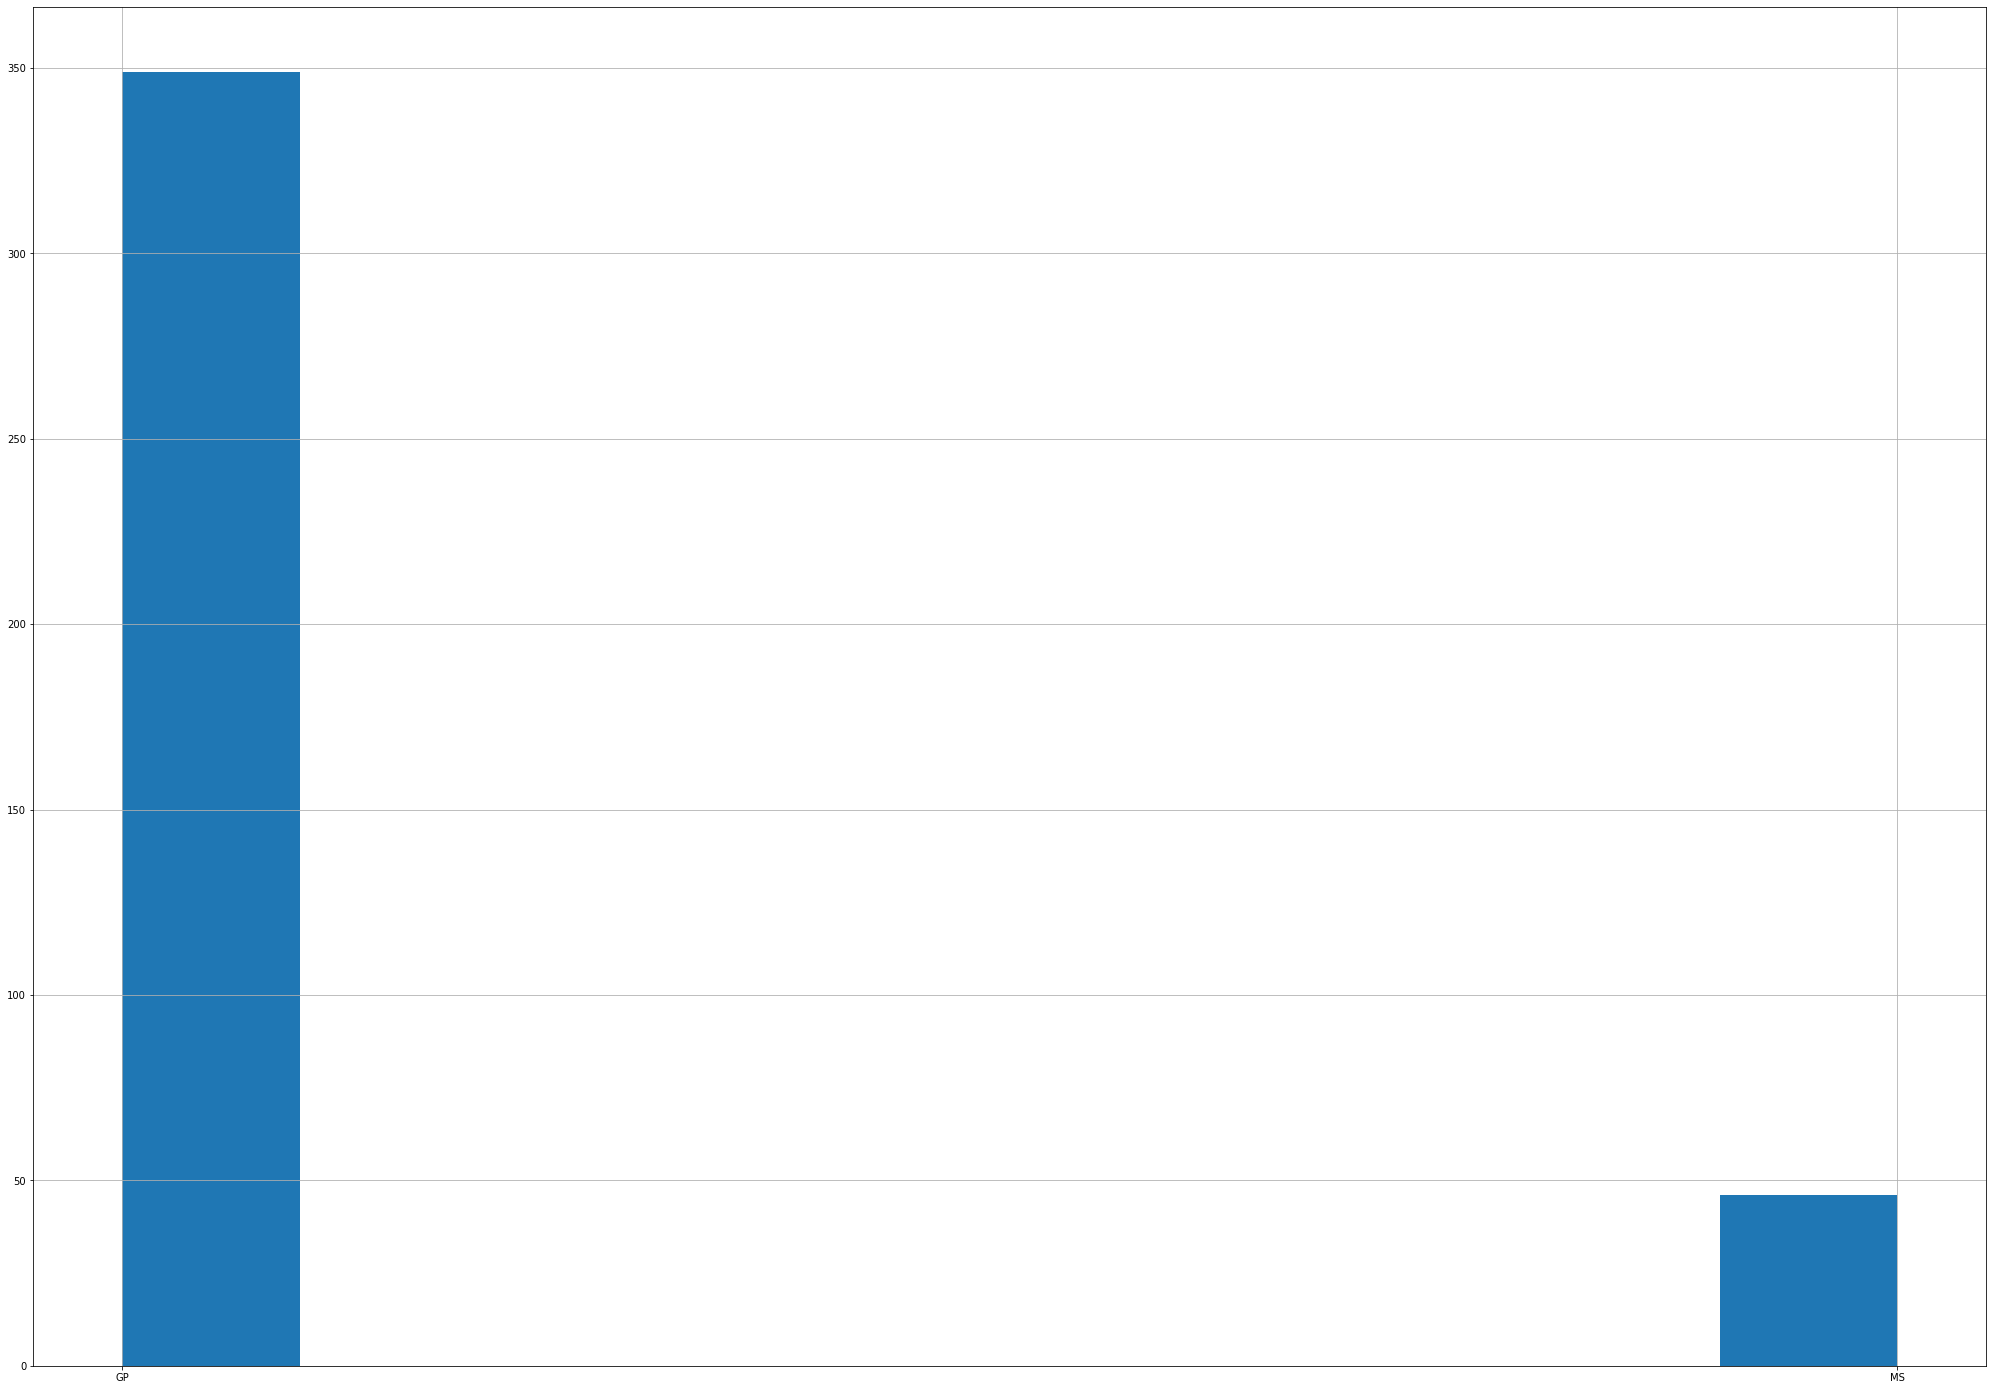

In [129]:
# Уникальные значения и их кол-во
stud.school.hist()
pd.DataFrame(stud.school.value_counts())

school  sex
GP      F      AxesSubplot(0.125,0.125;0.775x0.755)
        M      AxesSubplot(0.125,0.125;0.775x0.755)
MS      F      AxesSubplot(0.125,0.125;0.775x0.755)
        M      AxesSubplot(0.125,0.125;0.775x0.755)
Name: sex, dtype: object

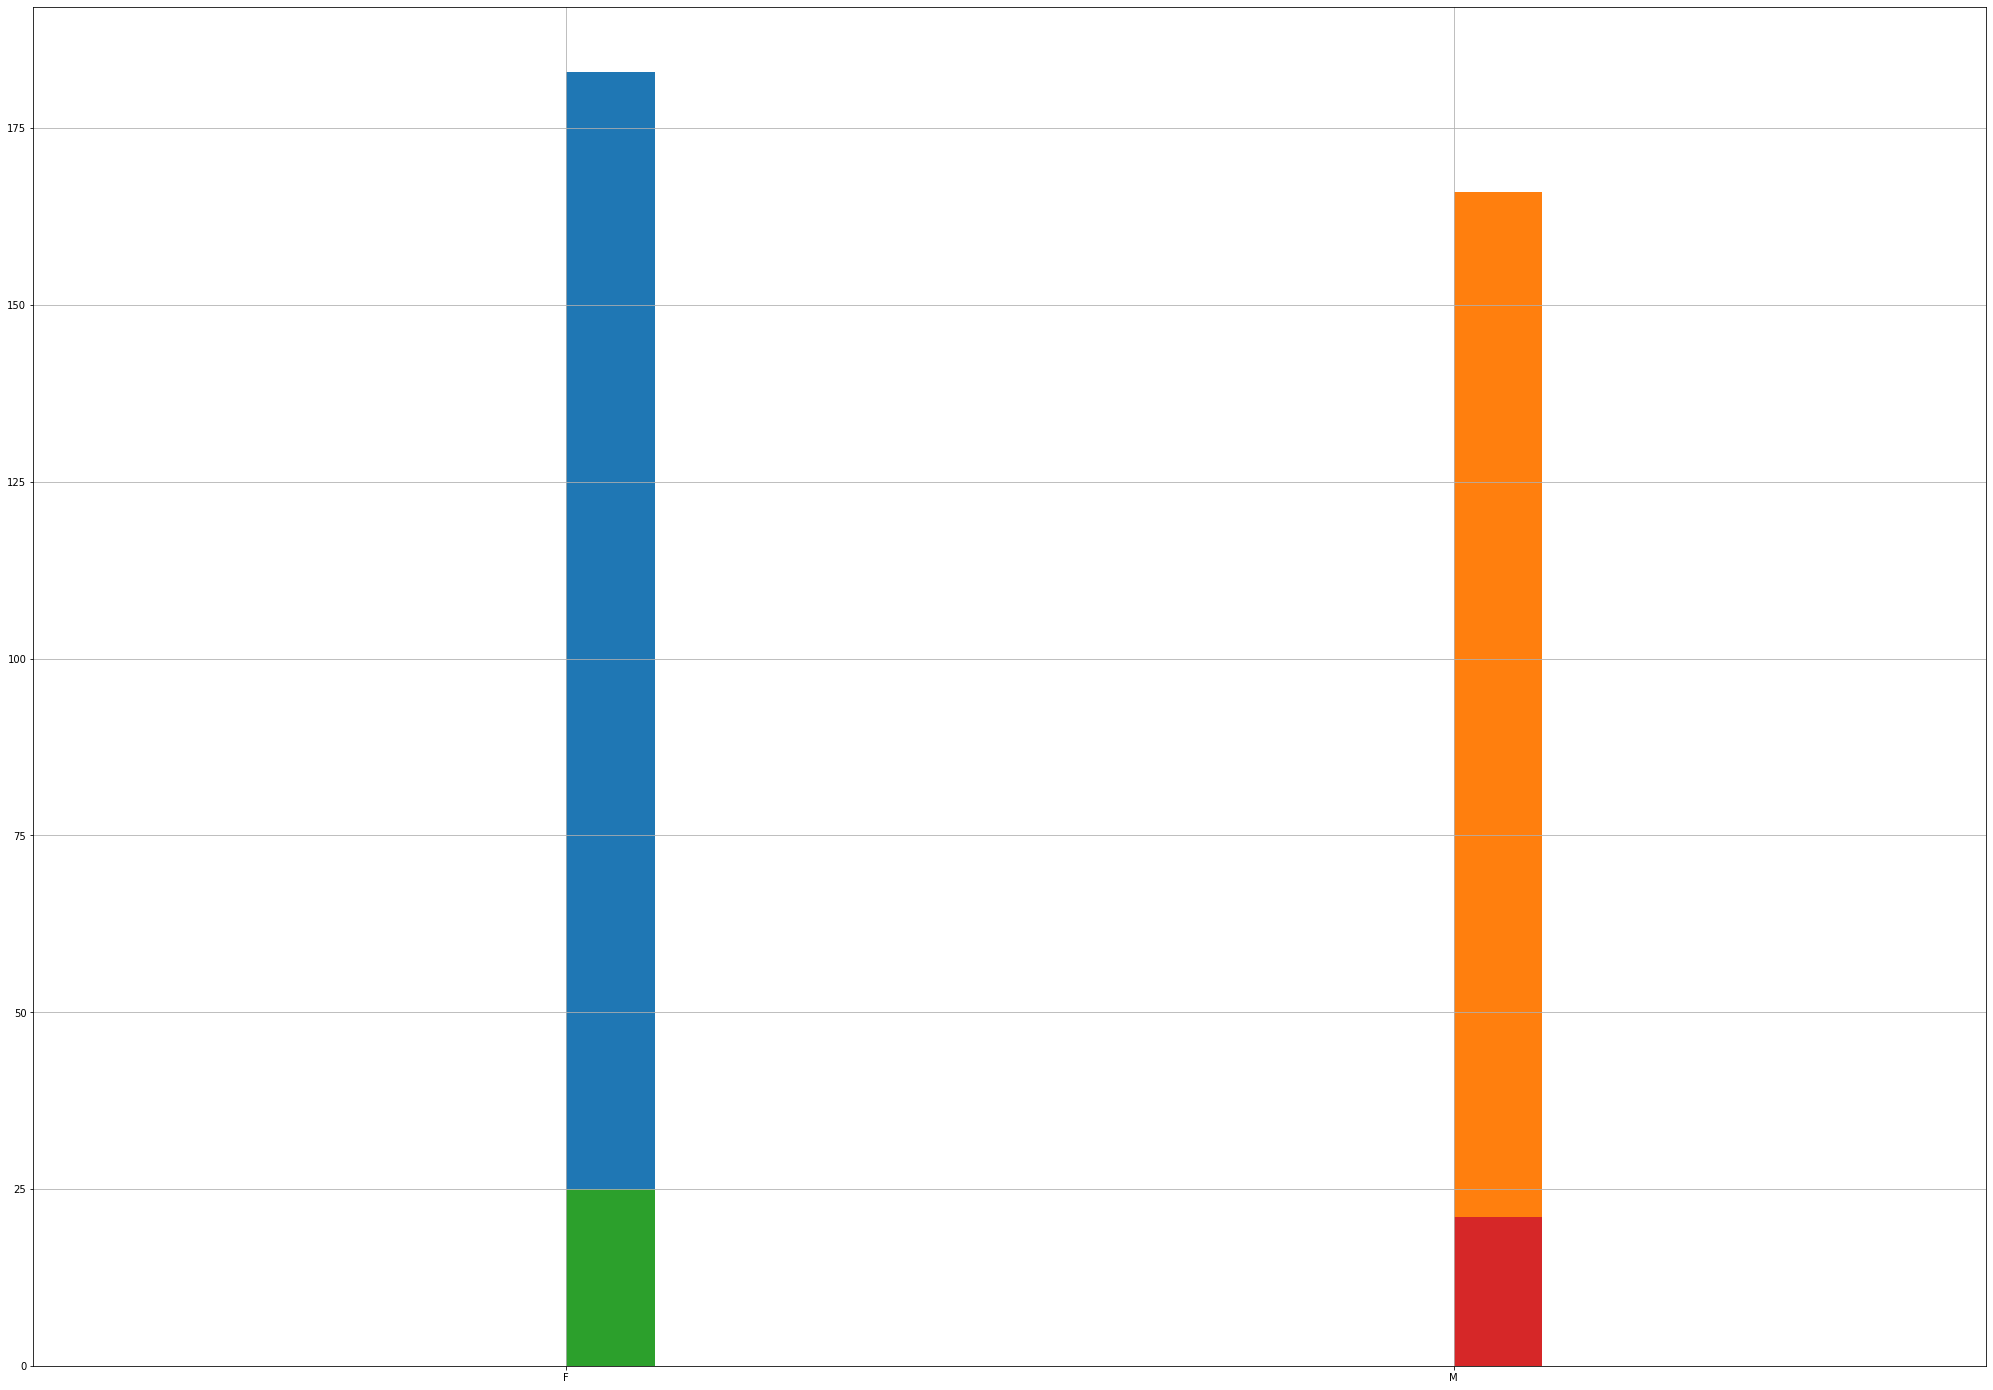

In [130]:
# Распределение вида школ и пола учащихся
stud.groupby(['school', 'sex']).sex.hist()

school  age
GP      15     AxesSubplot(0.125,0.125;0.775x0.755)
        16     AxesSubplot(0.125,0.125;0.775x0.755)
        17     AxesSubplot(0.125,0.125;0.775x0.755)
        18     AxesSubplot(0.125,0.125;0.775x0.755)
        19     AxesSubplot(0.125,0.125;0.775x0.755)
        20     AxesSubplot(0.125,0.125;0.775x0.755)
        22     AxesSubplot(0.125,0.125;0.775x0.755)
MS      17     AxesSubplot(0.125,0.125;0.775x0.755)
        18     AxesSubplot(0.125,0.125;0.775x0.755)
        19     AxesSubplot(0.125,0.125;0.775x0.755)
        20     AxesSubplot(0.125,0.125;0.775x0.755)
        21     AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

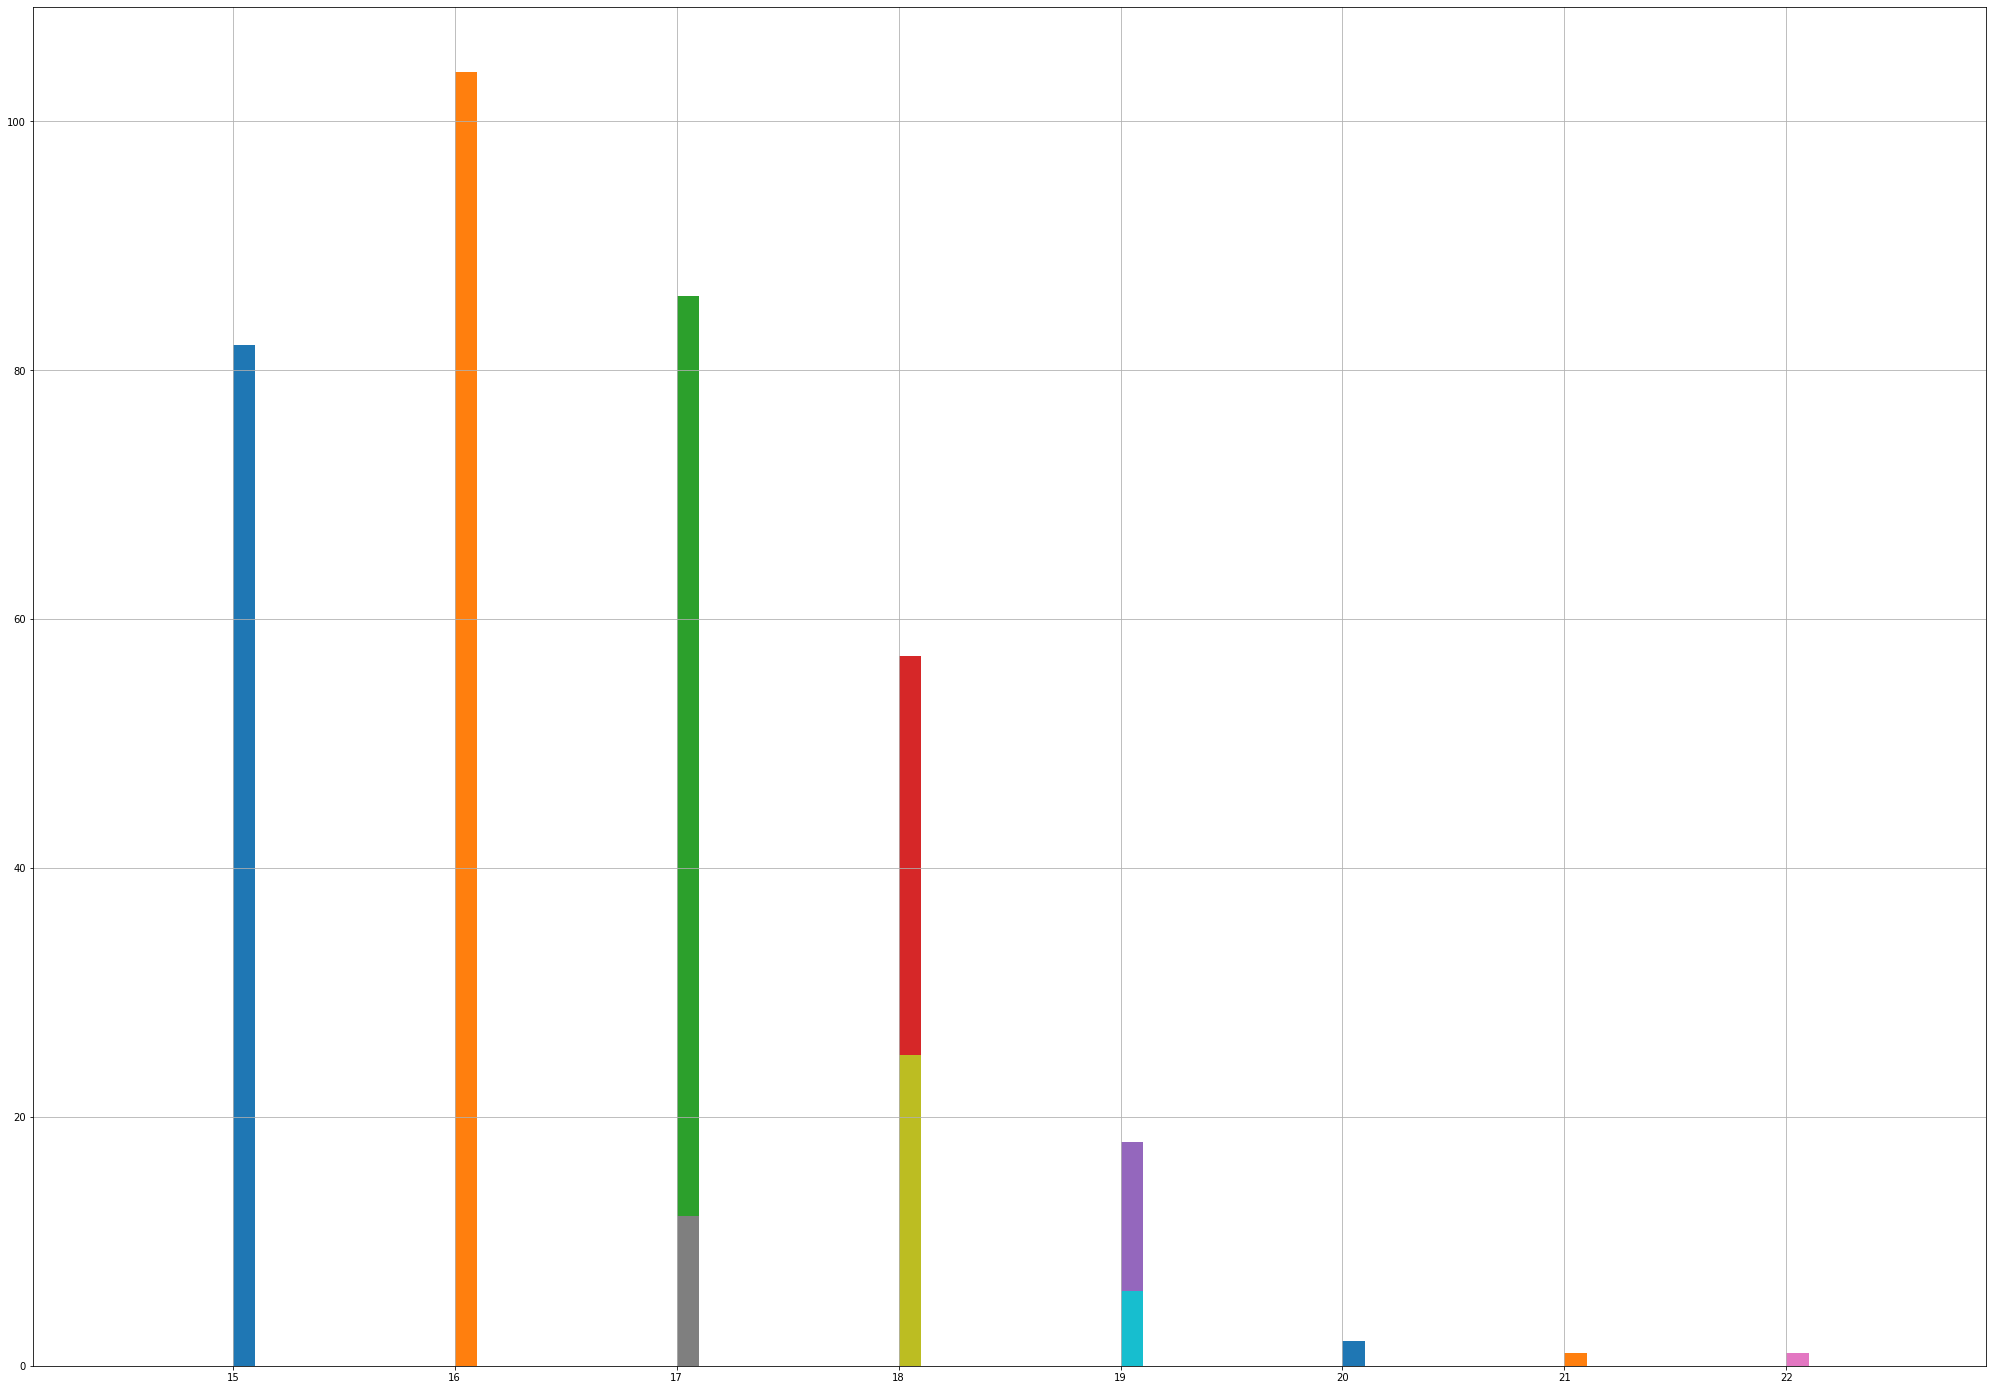

In [131]:
# Распределение вида школ и возраста учащихся
stud.groupby(['school', 'age']).age.hist()

##### Выводы по колонке school:
- Всего 2 вида школ: GP и MS
- Распределение по видам крайне неравномерное. Примерное соотношение GP/MS ~ 8/1
- Распределение вида школ и пола учащихся: примерно равномерное. В каждой школе примерно поровну юношей и девушек с небольшим перевесом в сторону девушек
- Распределение вида школ и возраста учащихся - неравномерное:
  * в школе GP представлены все возрасты с 15 до 22 за исключением возраста 21,
  * в школе MS присутствуют учащиеся только возрастов 17-21 включительно.

#### 2 sex — пол ученика ('F' - женский, 'M' - мужской)

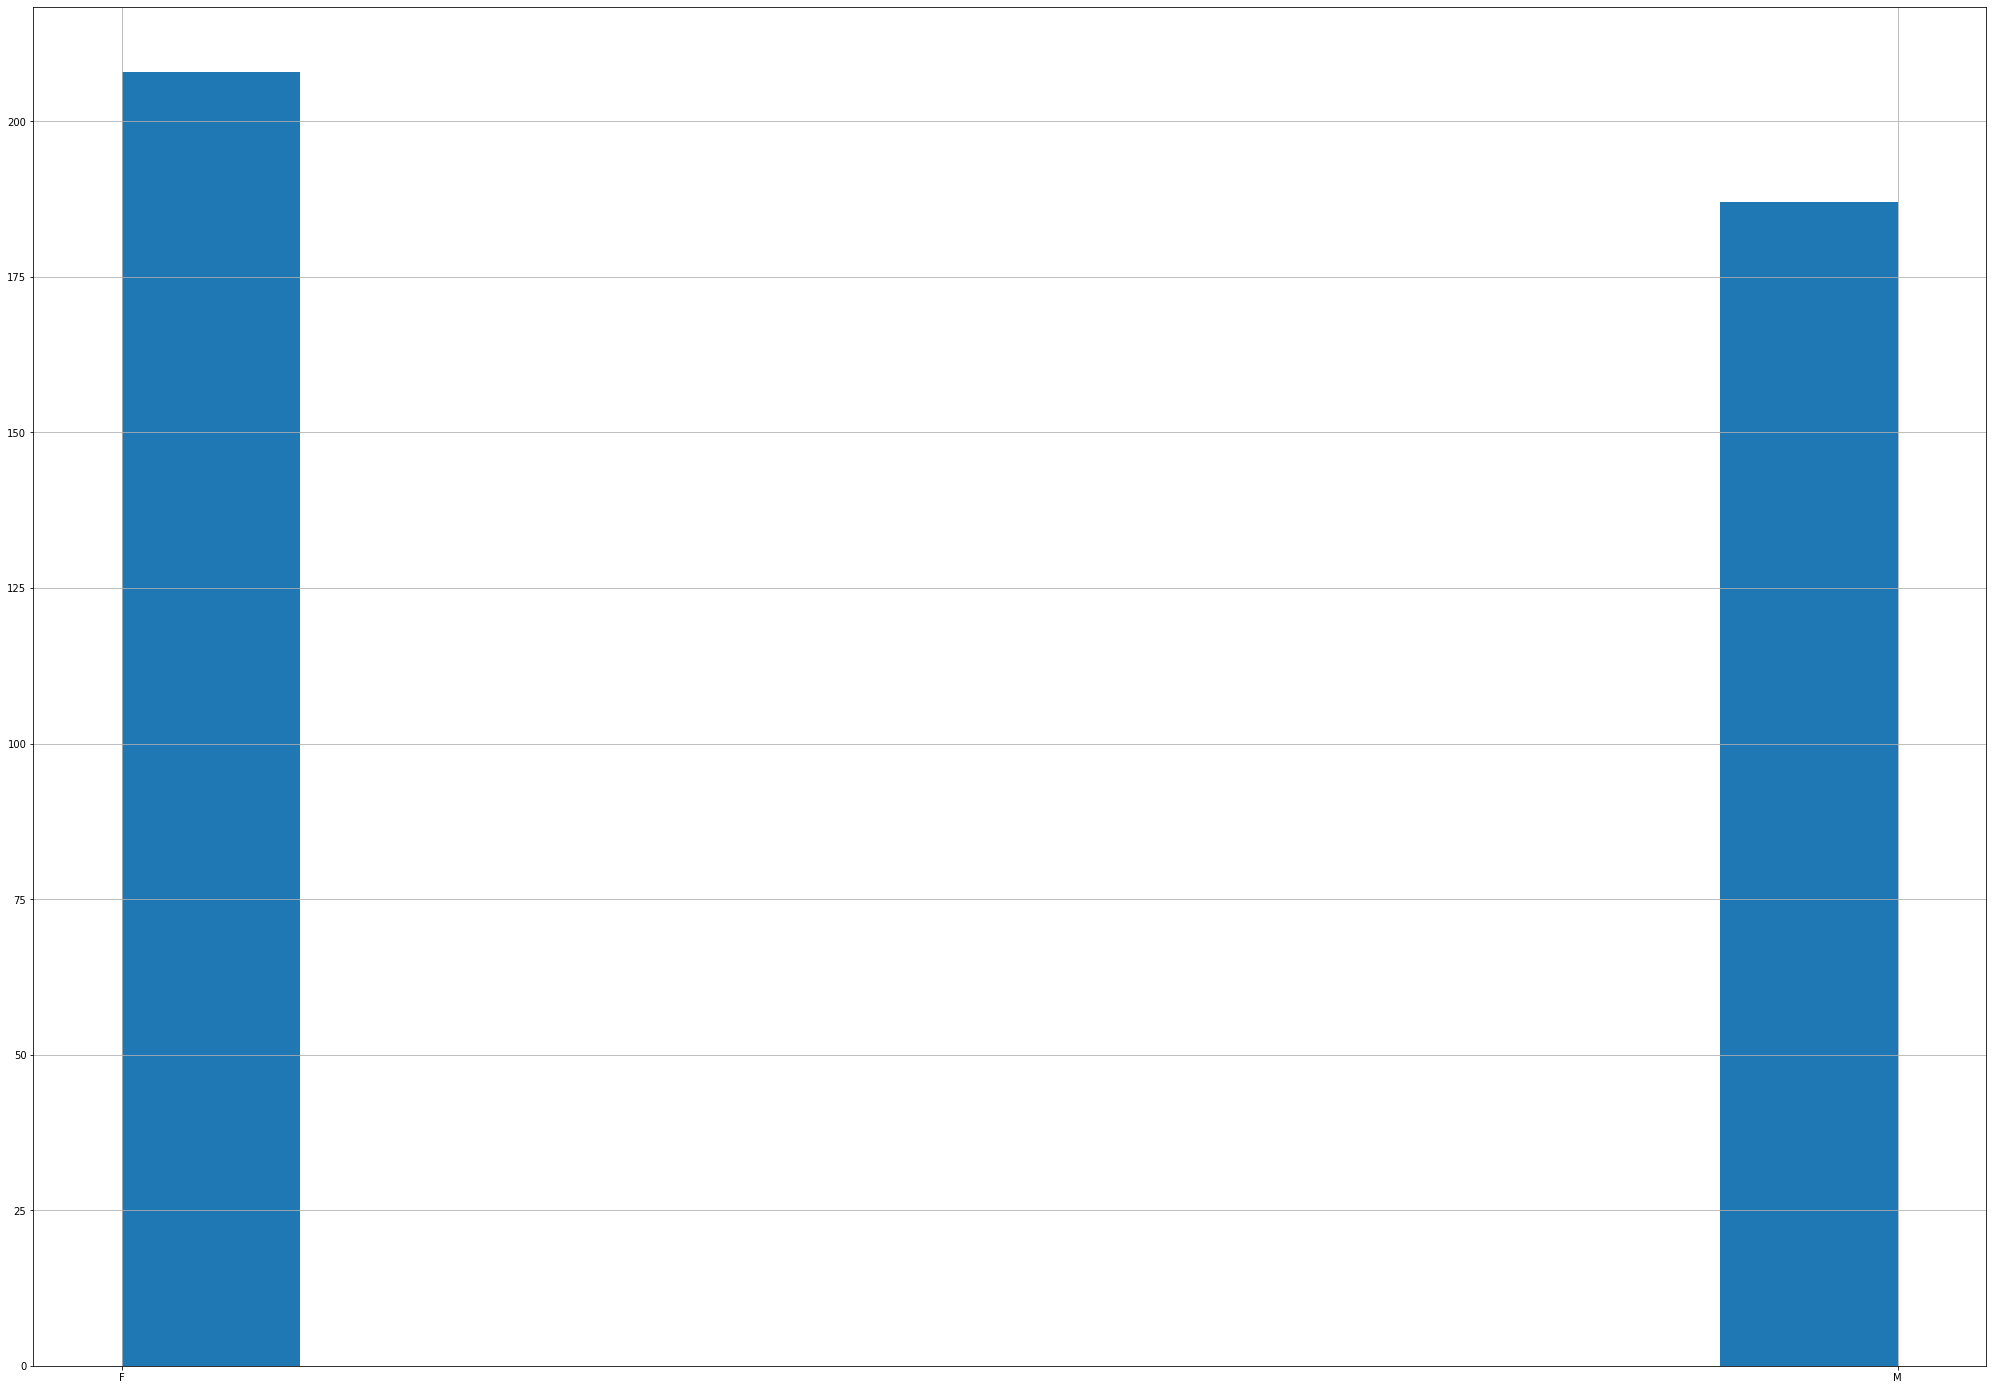

In [132]:
# Распределение между девушками юношами
stud.sex.hist();

sex  age
F    15     AxesSubplot(0.125,0.125;0.775x0.755)
     16     AxesSubplot(0.125,0.125;0.775x0.755)
     17     AxesSubplot(0.125,0.125;0.775x0.755)
     18     AxesSubplot(0.125,0.125;0.775x0.755)
     19     AxesSubplot(0.125,0.125;0.775x0.755)
     20     AxesSubplot(0.125,0.125;0.775x0.755)
M    15     AxesSubplot(0.125,0.125;0.775x0.755)
     16     AxesSubplot(0.125,0.125;0.775x0.755)
     17     AxesSubplot(0.125,0.125;0.775x0.755)
     18     AxesSubplot(0.125,0.125;0.775x0.755)
     19     AxesSubplot(0.125,0.125;0.775x0.755)
     20     AxesSubplot(0.125,0.125;0.775x0.755)
     21     AxesSubplot(0.125,0.125;0.775x0.755)
     22     AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

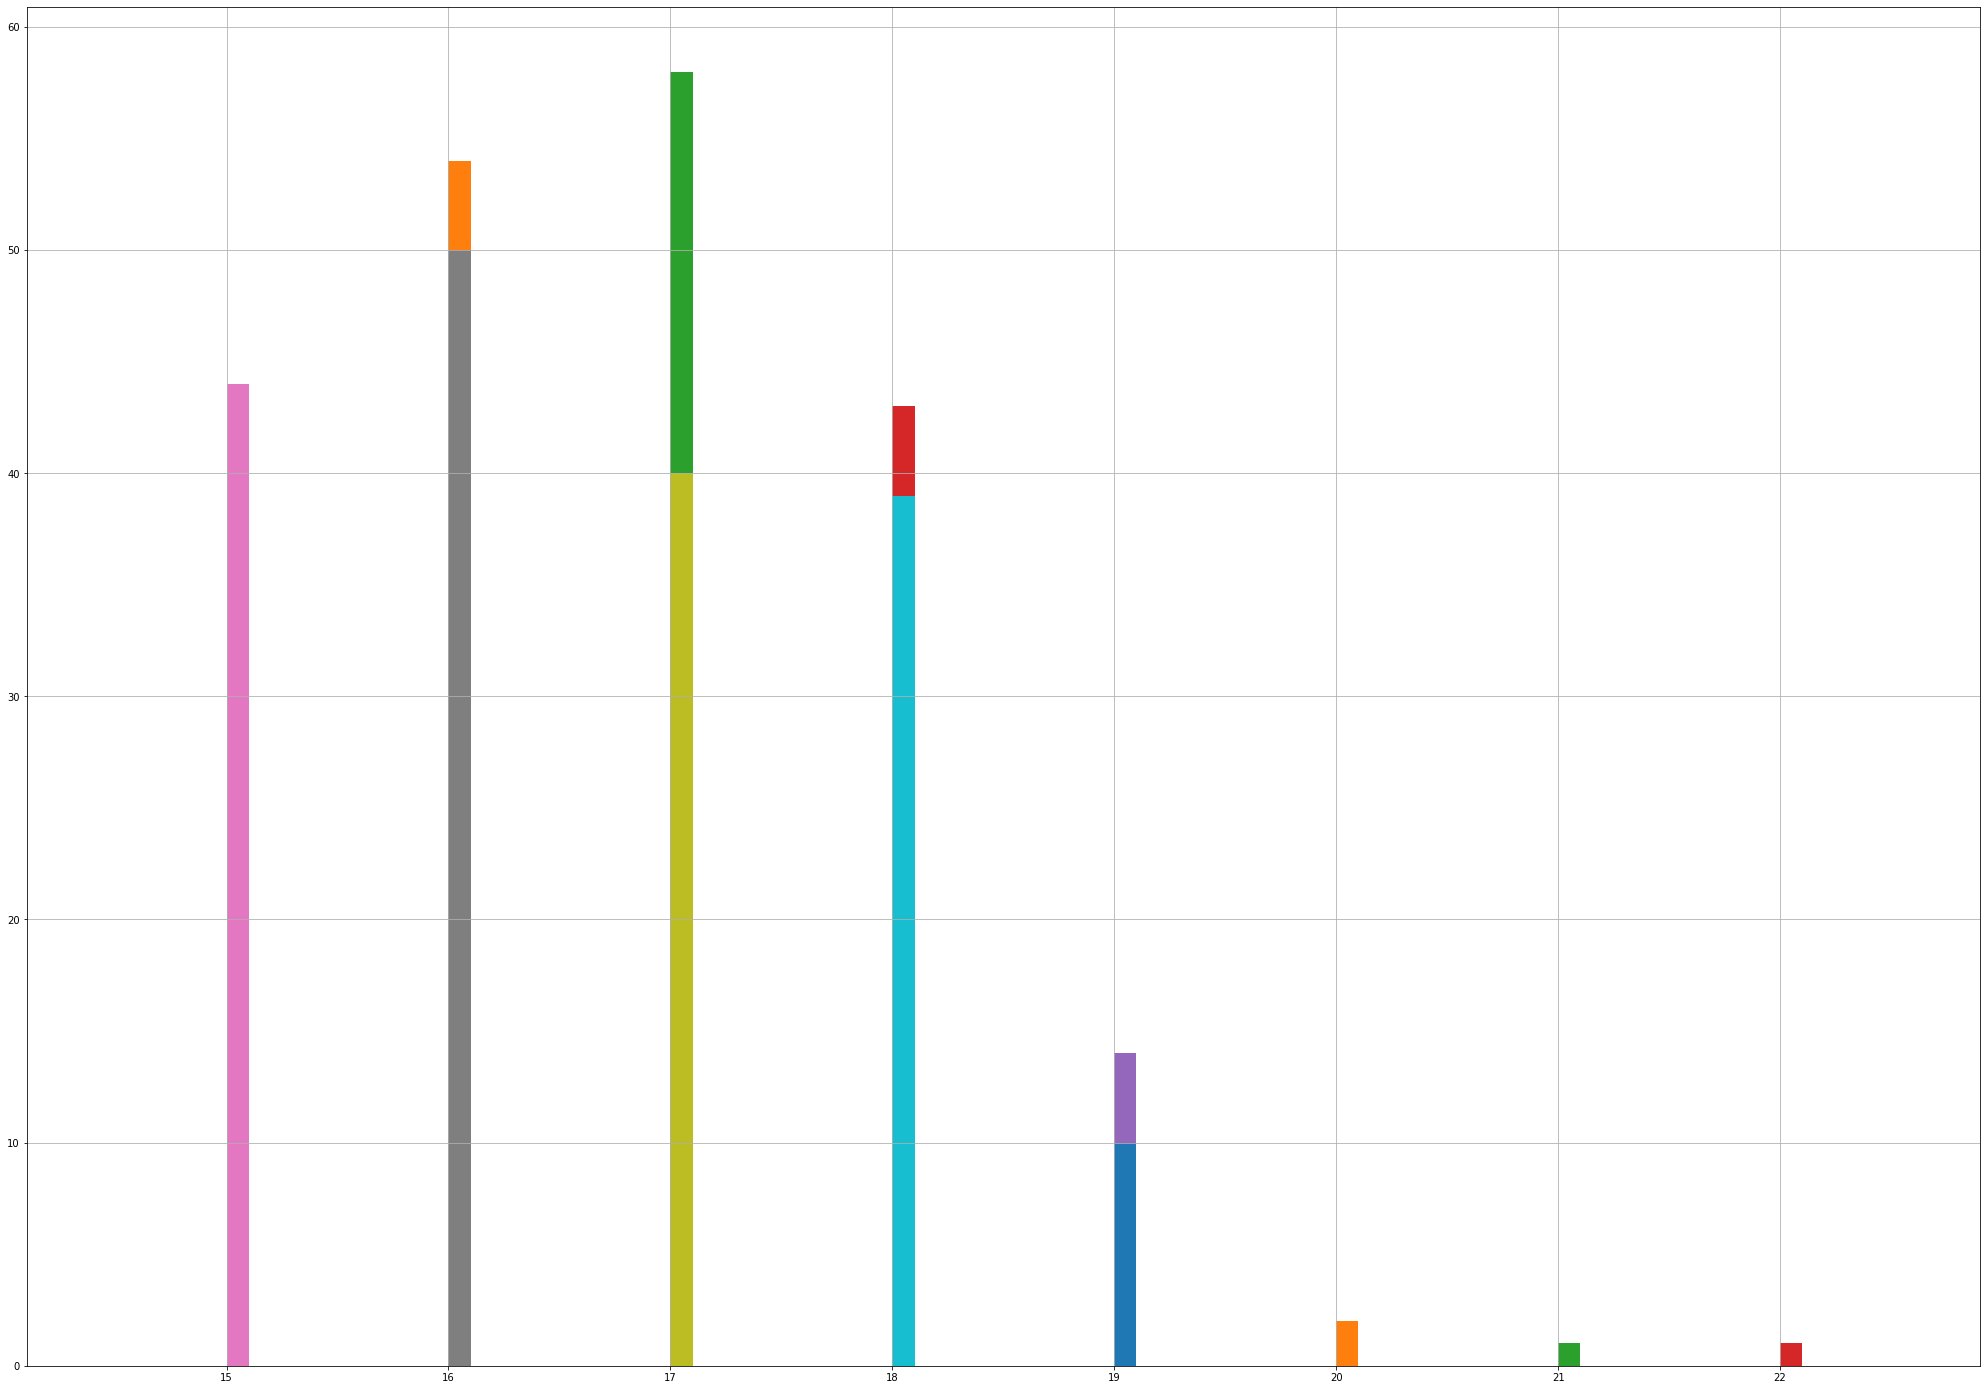

In [133]:
stud.groupby(['sex','age']).age.hist()

##### Выводы по колонке sex:
- По количеству: перевес в сторону девушек
- По возрасту: самые старшие (возраст 21 и 22 года) - только юноши

#### 3 age — возраст ученика (от 15 до 22)

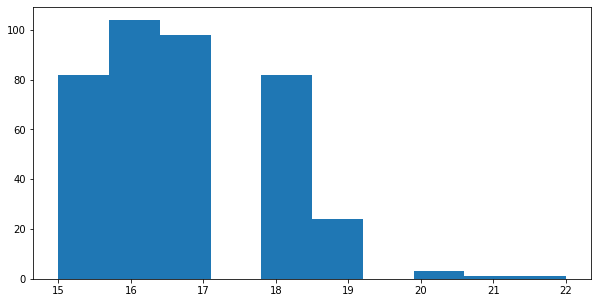

In [134]:
# Распределение по кол-ву
stud.age.hist(grid=False, xlabelsize=10, ylabelsize=10, figsize=(10,5));

In [135]:
stud.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

##### Выводы по колонке age:
- Распределение по возрасту неравномерное
- Если брать во внимание только (15 лет <= возраст < 20 лет), тогда распределение примерно колоколообразное

### Остальные 27 колонок - с пропуском

#### 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

U    295
R     83
Name: address, dtype: int64

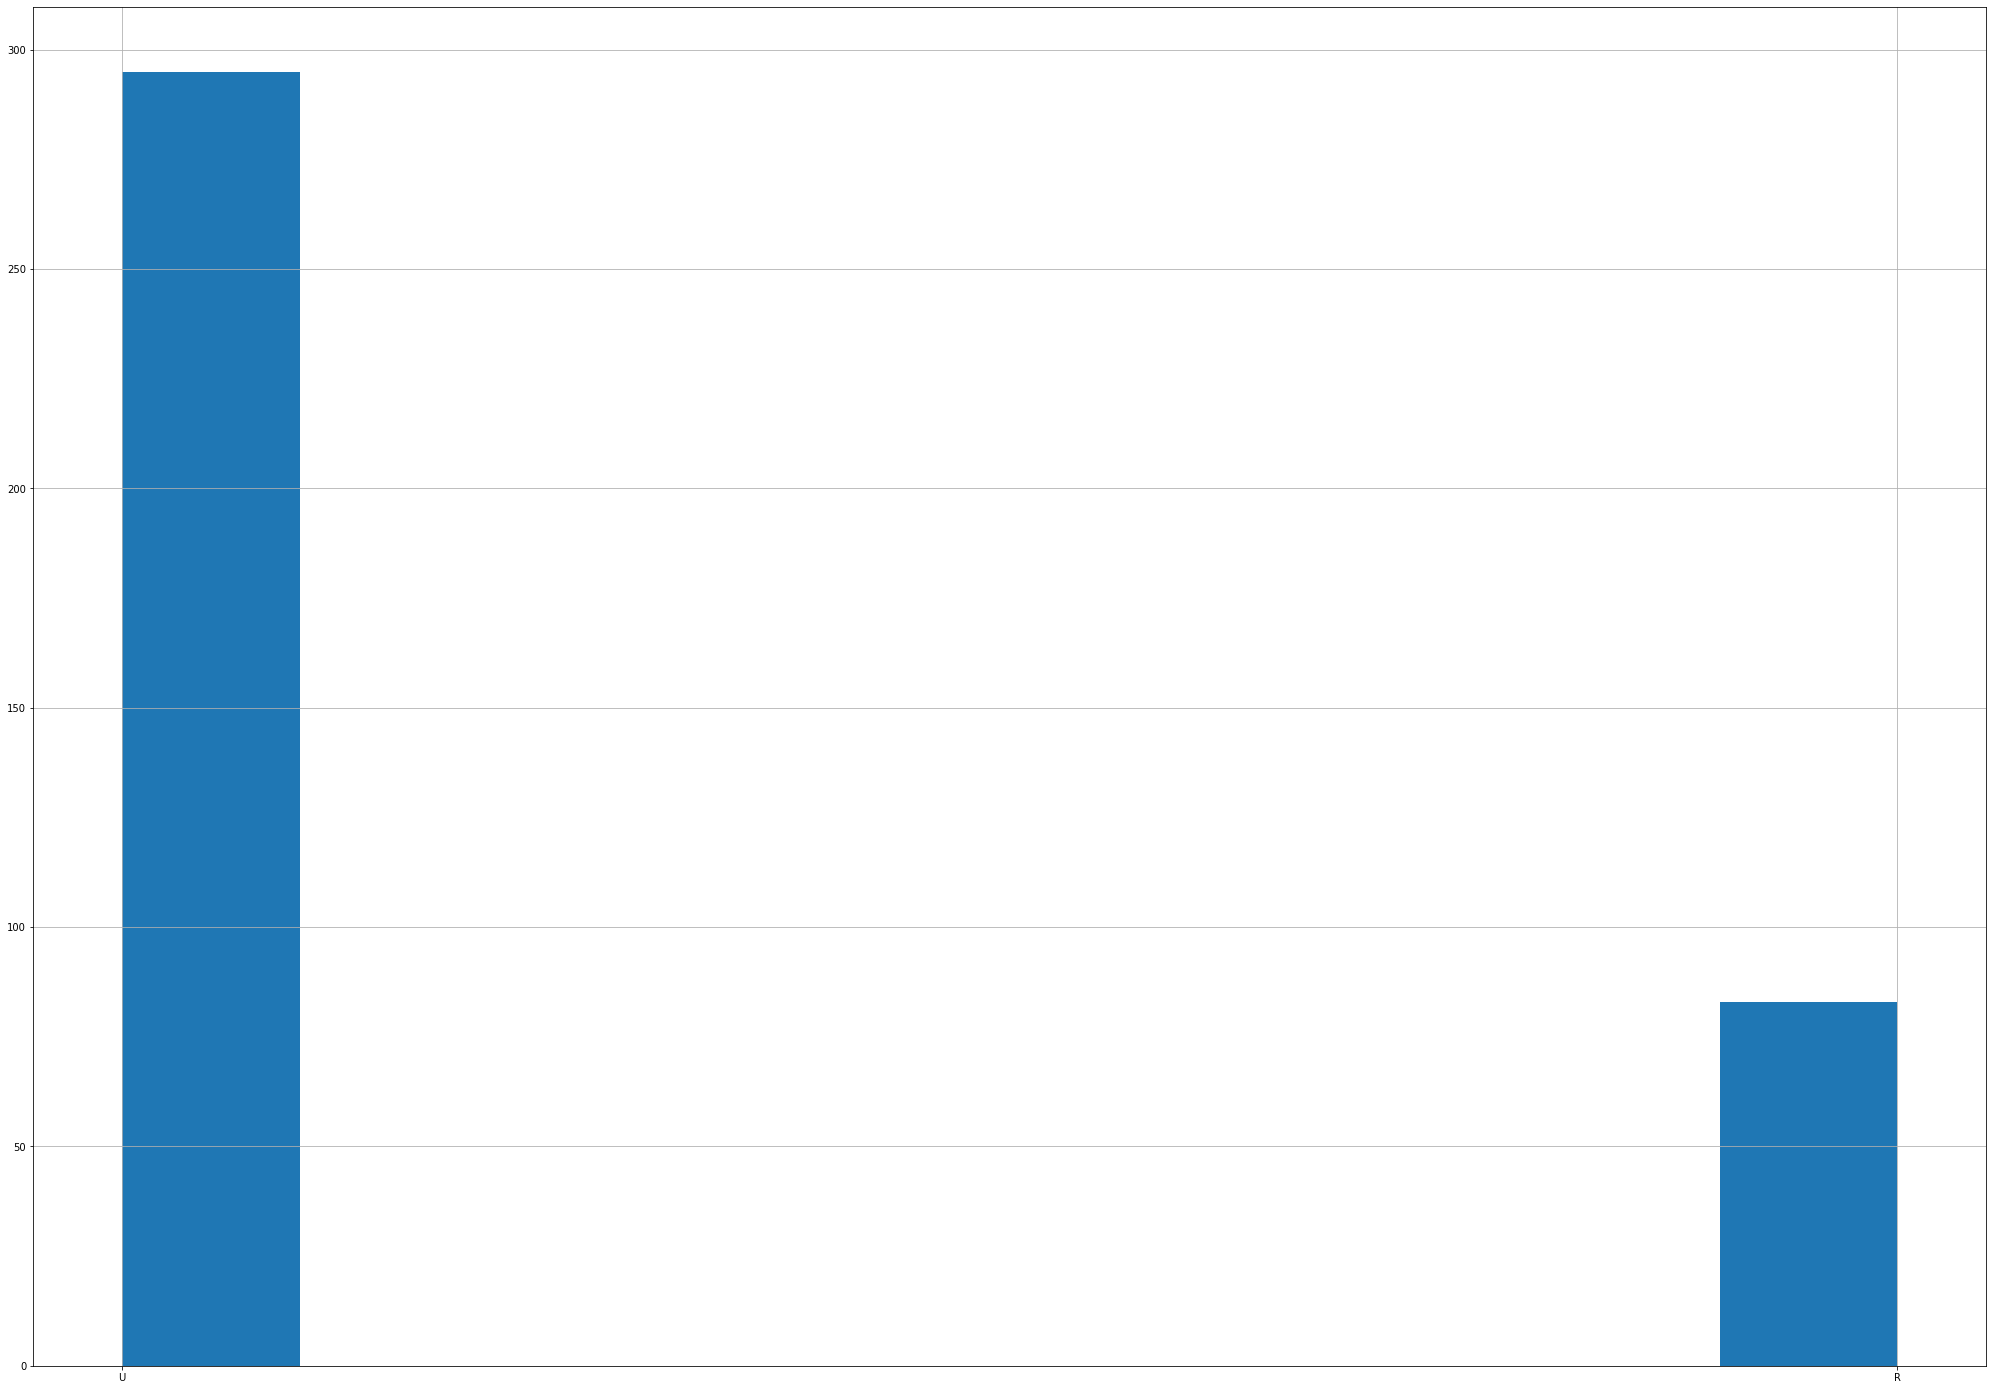

In [136]:
# 395 - 378 = 17 пропусков
# Распределение
stud.address.hist()
stud.address.value_counts()

Распределение похоже на распределение по виду школ.

Посмотрим как соотносятся виды школ и адресов

school  address
GP      R          AxesSubplot(0.125,0.125;0.775x0.755)
        U          AxesSubplot(0.125,0.125;0.775x0.755)
MS      R          AxesSubplot(0.125,0.125;0.775x0.755)
        U          AxesSubplot(0.125,0.125;0.775x0.755)
Name: address, dtype: object

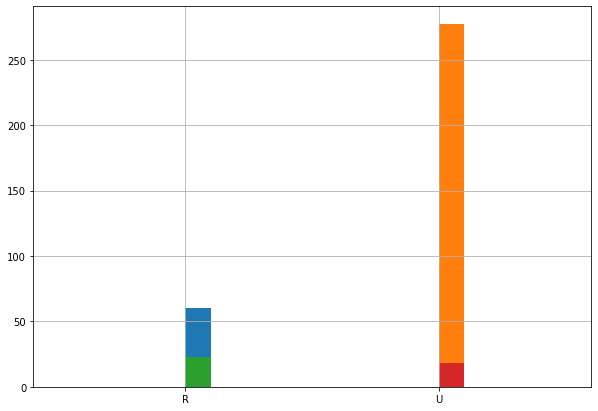

In [137]:
stud.groupby(['school', 'address']).address.hist(figsize=(10,7))

In [138]:
stud[['school', 'sex', 'age', 'address']].loc[stud.address.isnull()]

,school,sex,age,address
6,GP,M,16,NaN
52,GP,M,15,NaN
75,GP,M,15,NaN
92,GP,F,16,NaN
96,GP,M,16,NaN
159,GP,M,16,NaN
168,GP,F,16,NaN
241,GP,M,17,NaN
254,GP,M,17,NaN
270,GP,F,19,NaN


##### Предположение: 
поскольку пропусков всего 17, т.е. <5%, заполним их значением, которое представлено максимальным значением в распределении - это "U"

In [139]:
stud.address = stud.address.apply(lambda x: 'U' if pd.isnull(x) else x)

##### Выводы по колонке address:
- Заполнили пропуски значением "U", т.к. это значение встречается чаще всего

#### 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

27


GT3    261
LE3    107
Name: famsize, dtype: int64

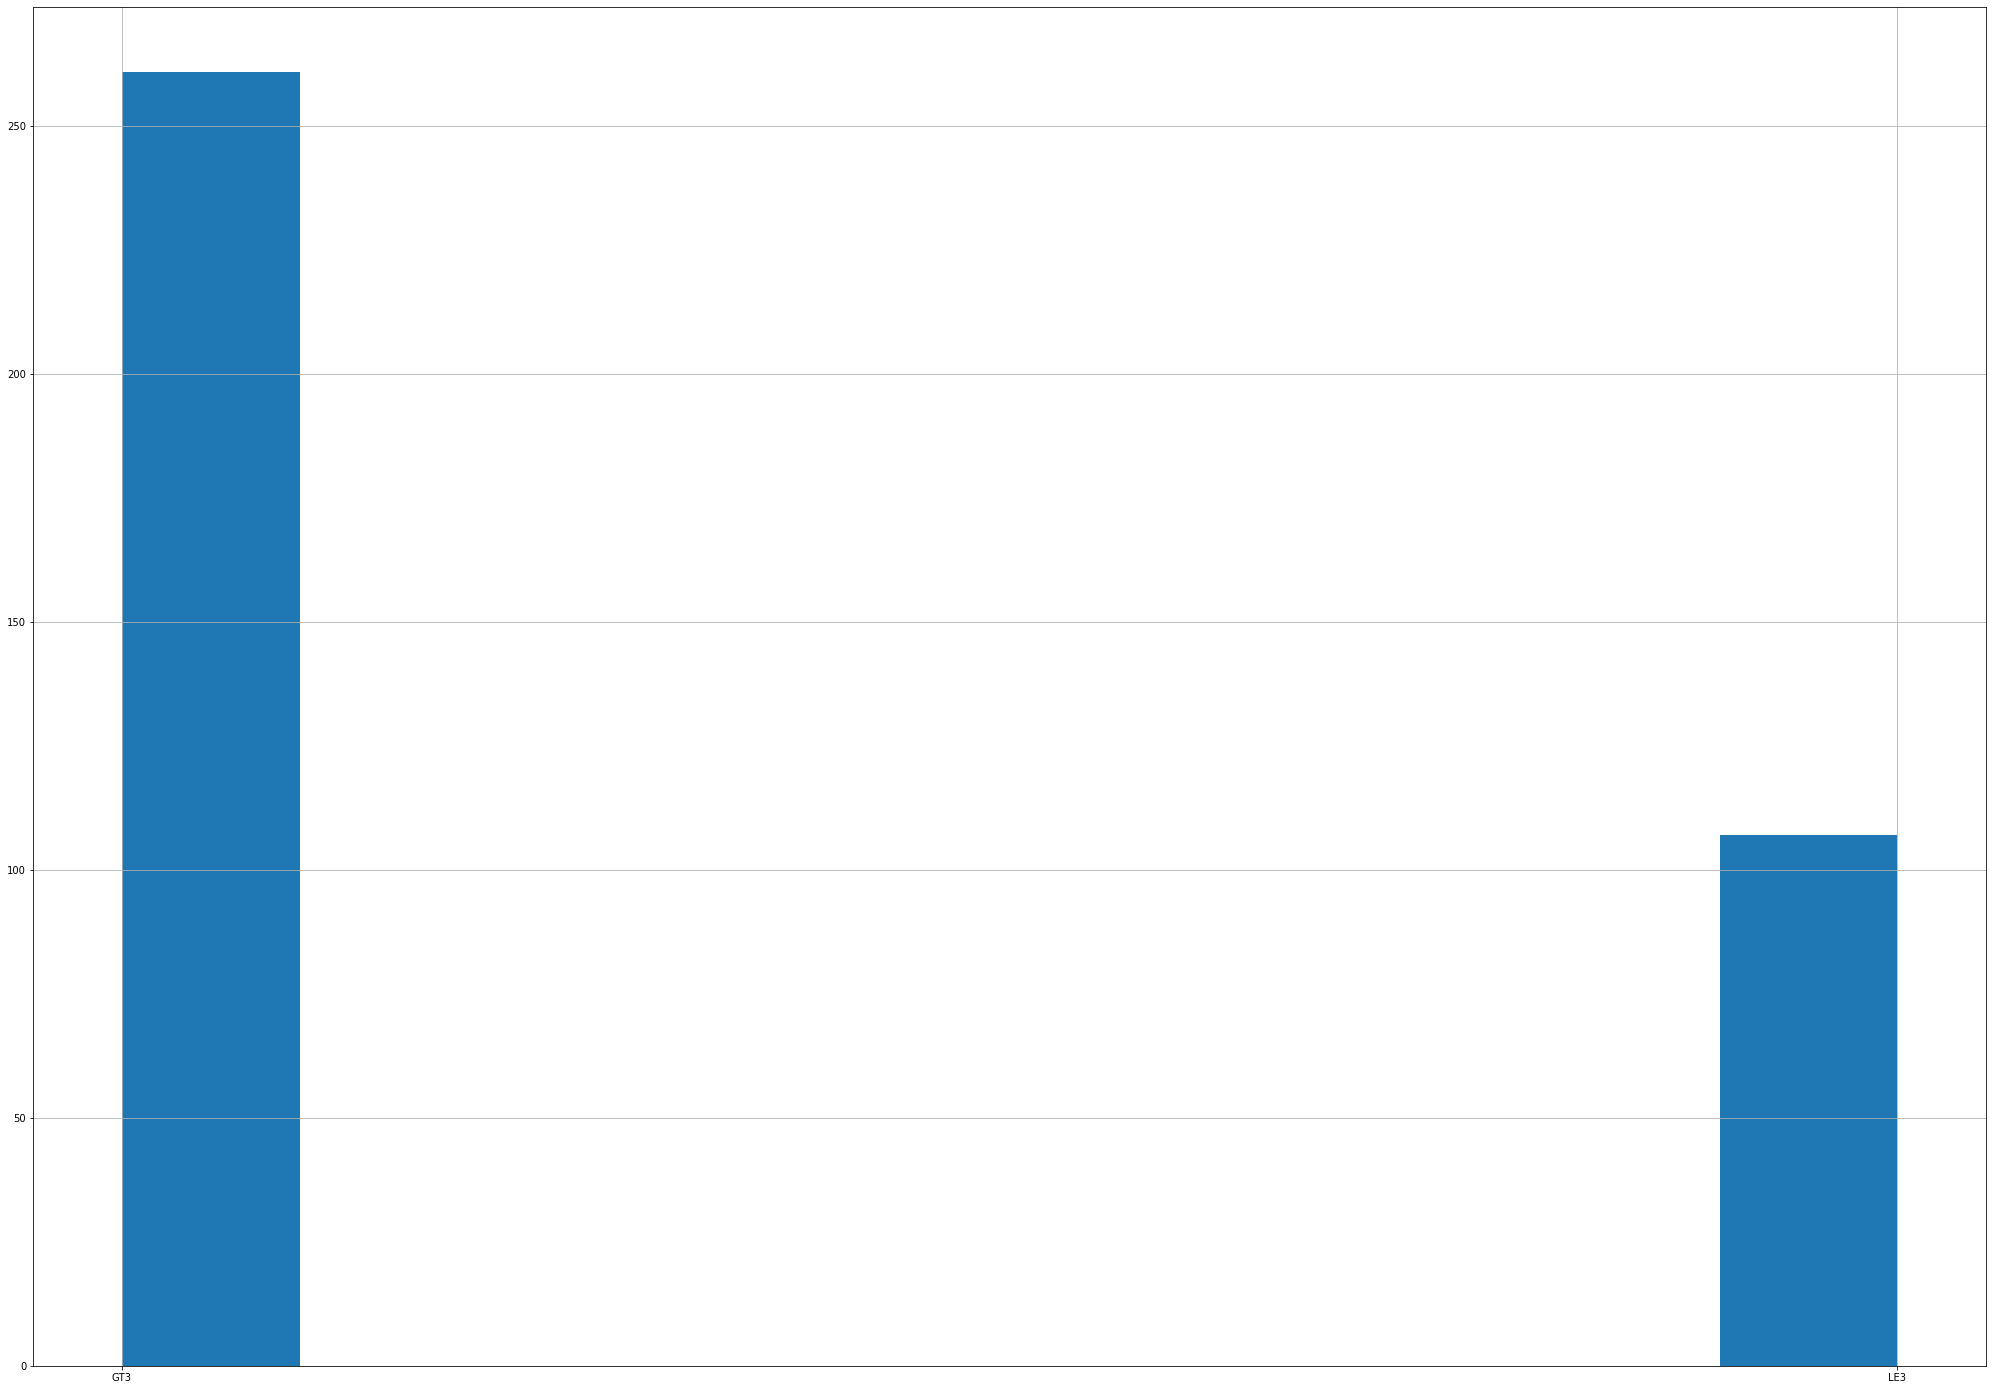

In [140]:
stud.famsize.hist();
print(stud.famsize.isnull().sum())
stud.famsize.value_counts()

In [141]:
# Соотношение GT3/LE3 ~ 2
stud.famsize.value_counts()[0] / stud.famsize.value_counts()[1]

2.439252336448598

school  famsize
GP      GT3        233
        LE3         91
MS      GT3         28
        LE3         16
Name: famsize, dtype: int64

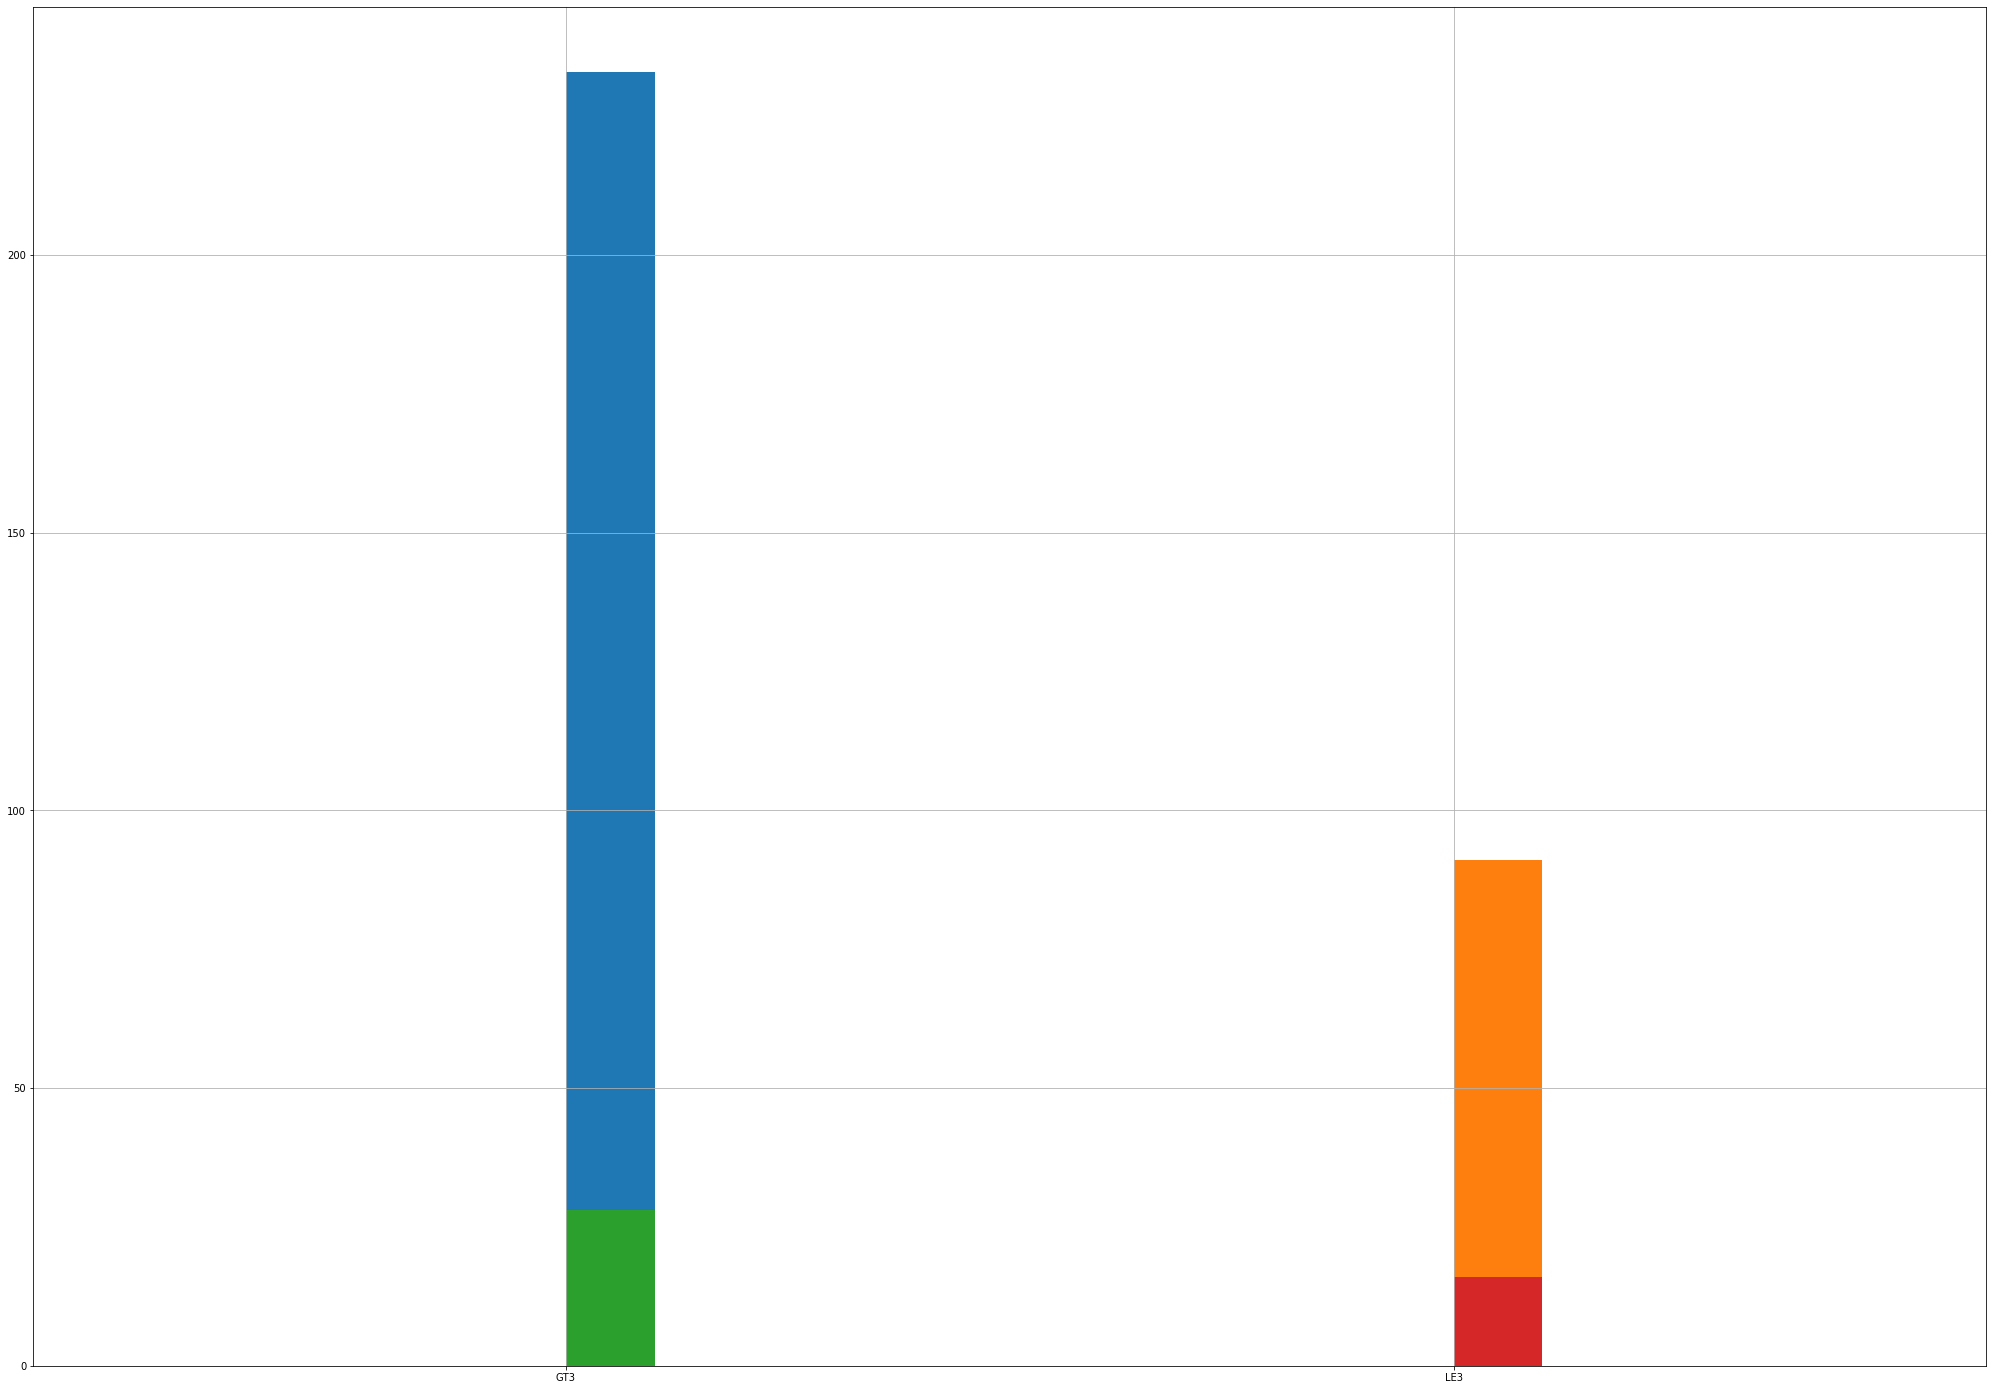

In [142]:
stud.groupby(['school', 'famsize']).famsize.hist()
stud.groupby(['school', 'famsize']).famsize.count()

sex  famsize
F    GT3        148
     LE3         49
M    GT3        113
     LE3         58
Name: famsize, dtype: int64

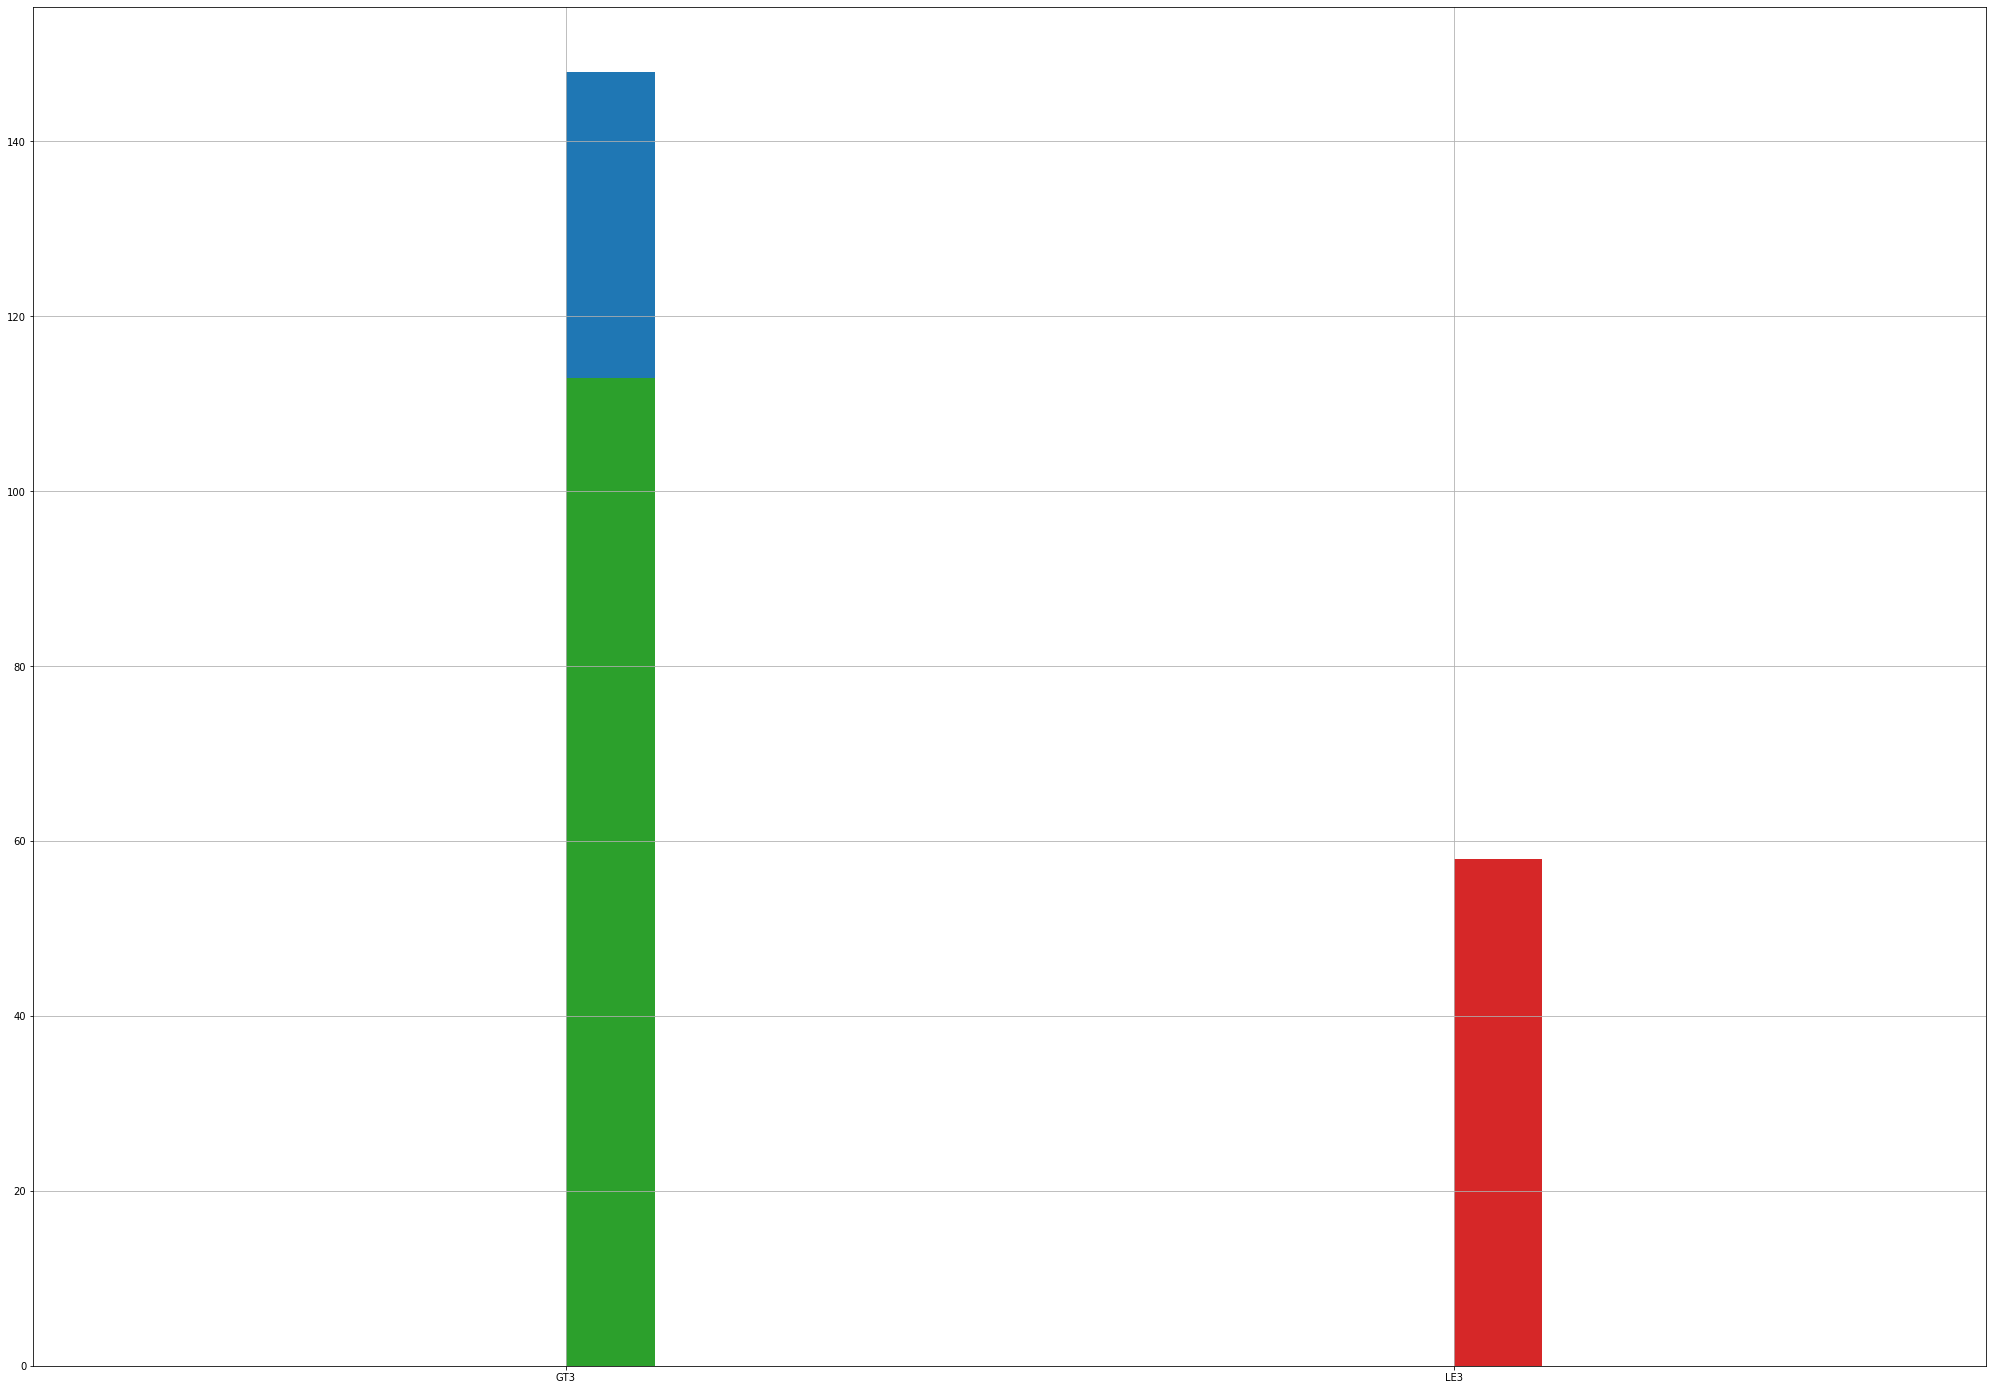

In [143]:
stud.groupby(['sex', 'famsize']).famsize.hist()
stud.groupby(['sex', 'famsize']).famsize.count()

age  famsize
15   GT3        57
     LE3        20
16   GT3        70
     LE3        28
17   GT3        64
     LE3        26
18   GT3        48
     LE3        27
19   GT3        18
     LE3         5
20   GT3         2
     LE3         1
21   GT3         1
22   GT3         1
Name: famsize, dtype: int64

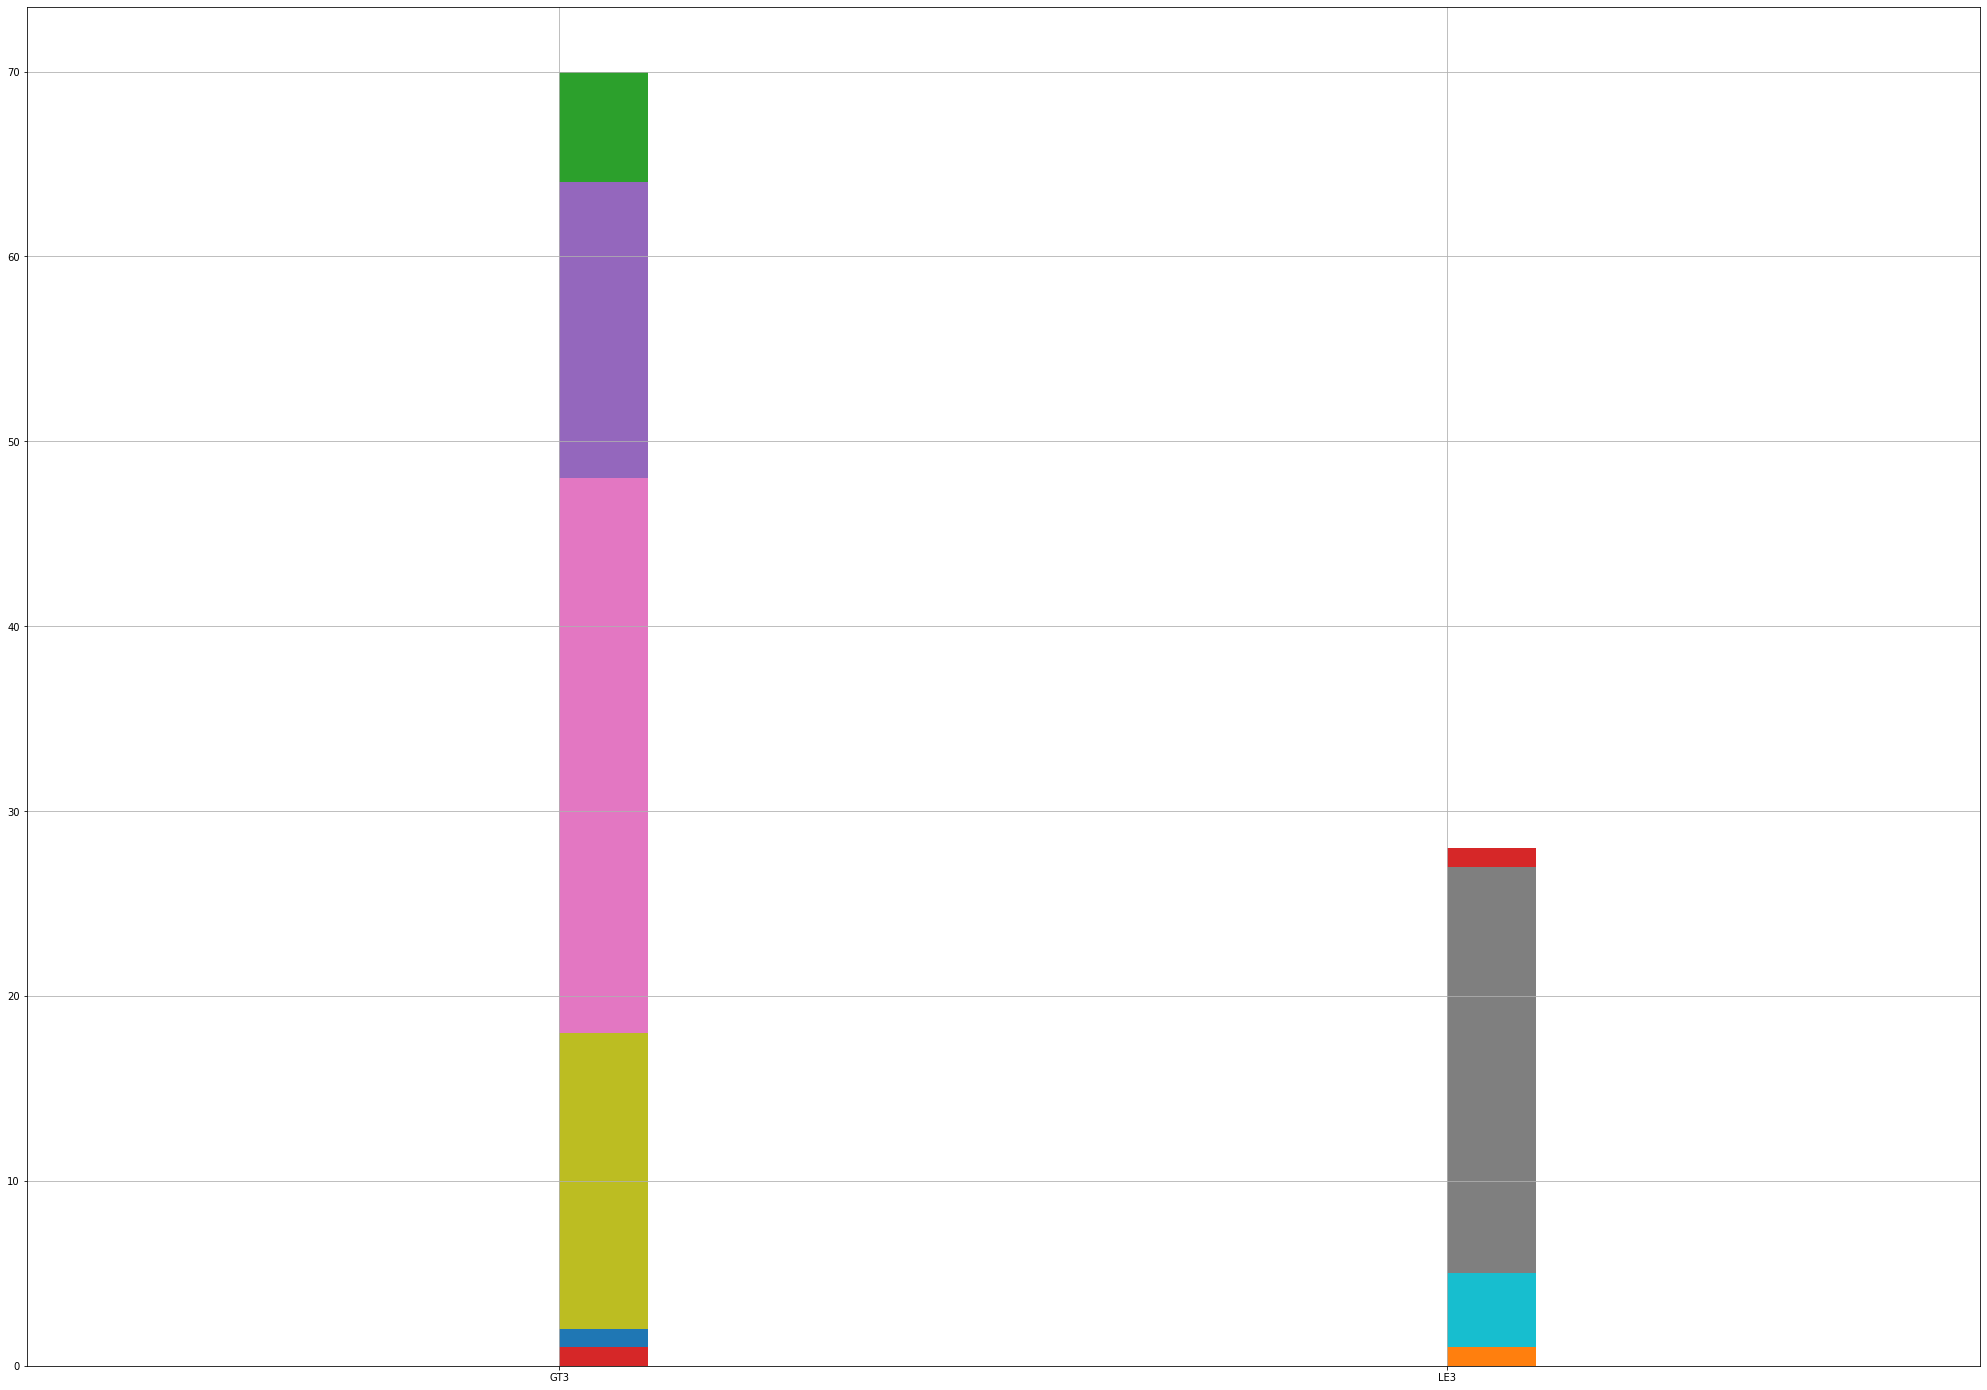

In [144]:
stud.groupby(['age', 'famsize']).famsize.hist()
stud.groupby(['age', 'famsize']).famsize.count()

address  famsize
R        GT3         58
         LE3         18
U        GT3        203
         LE3         89
Name: famsize, dtype: int64

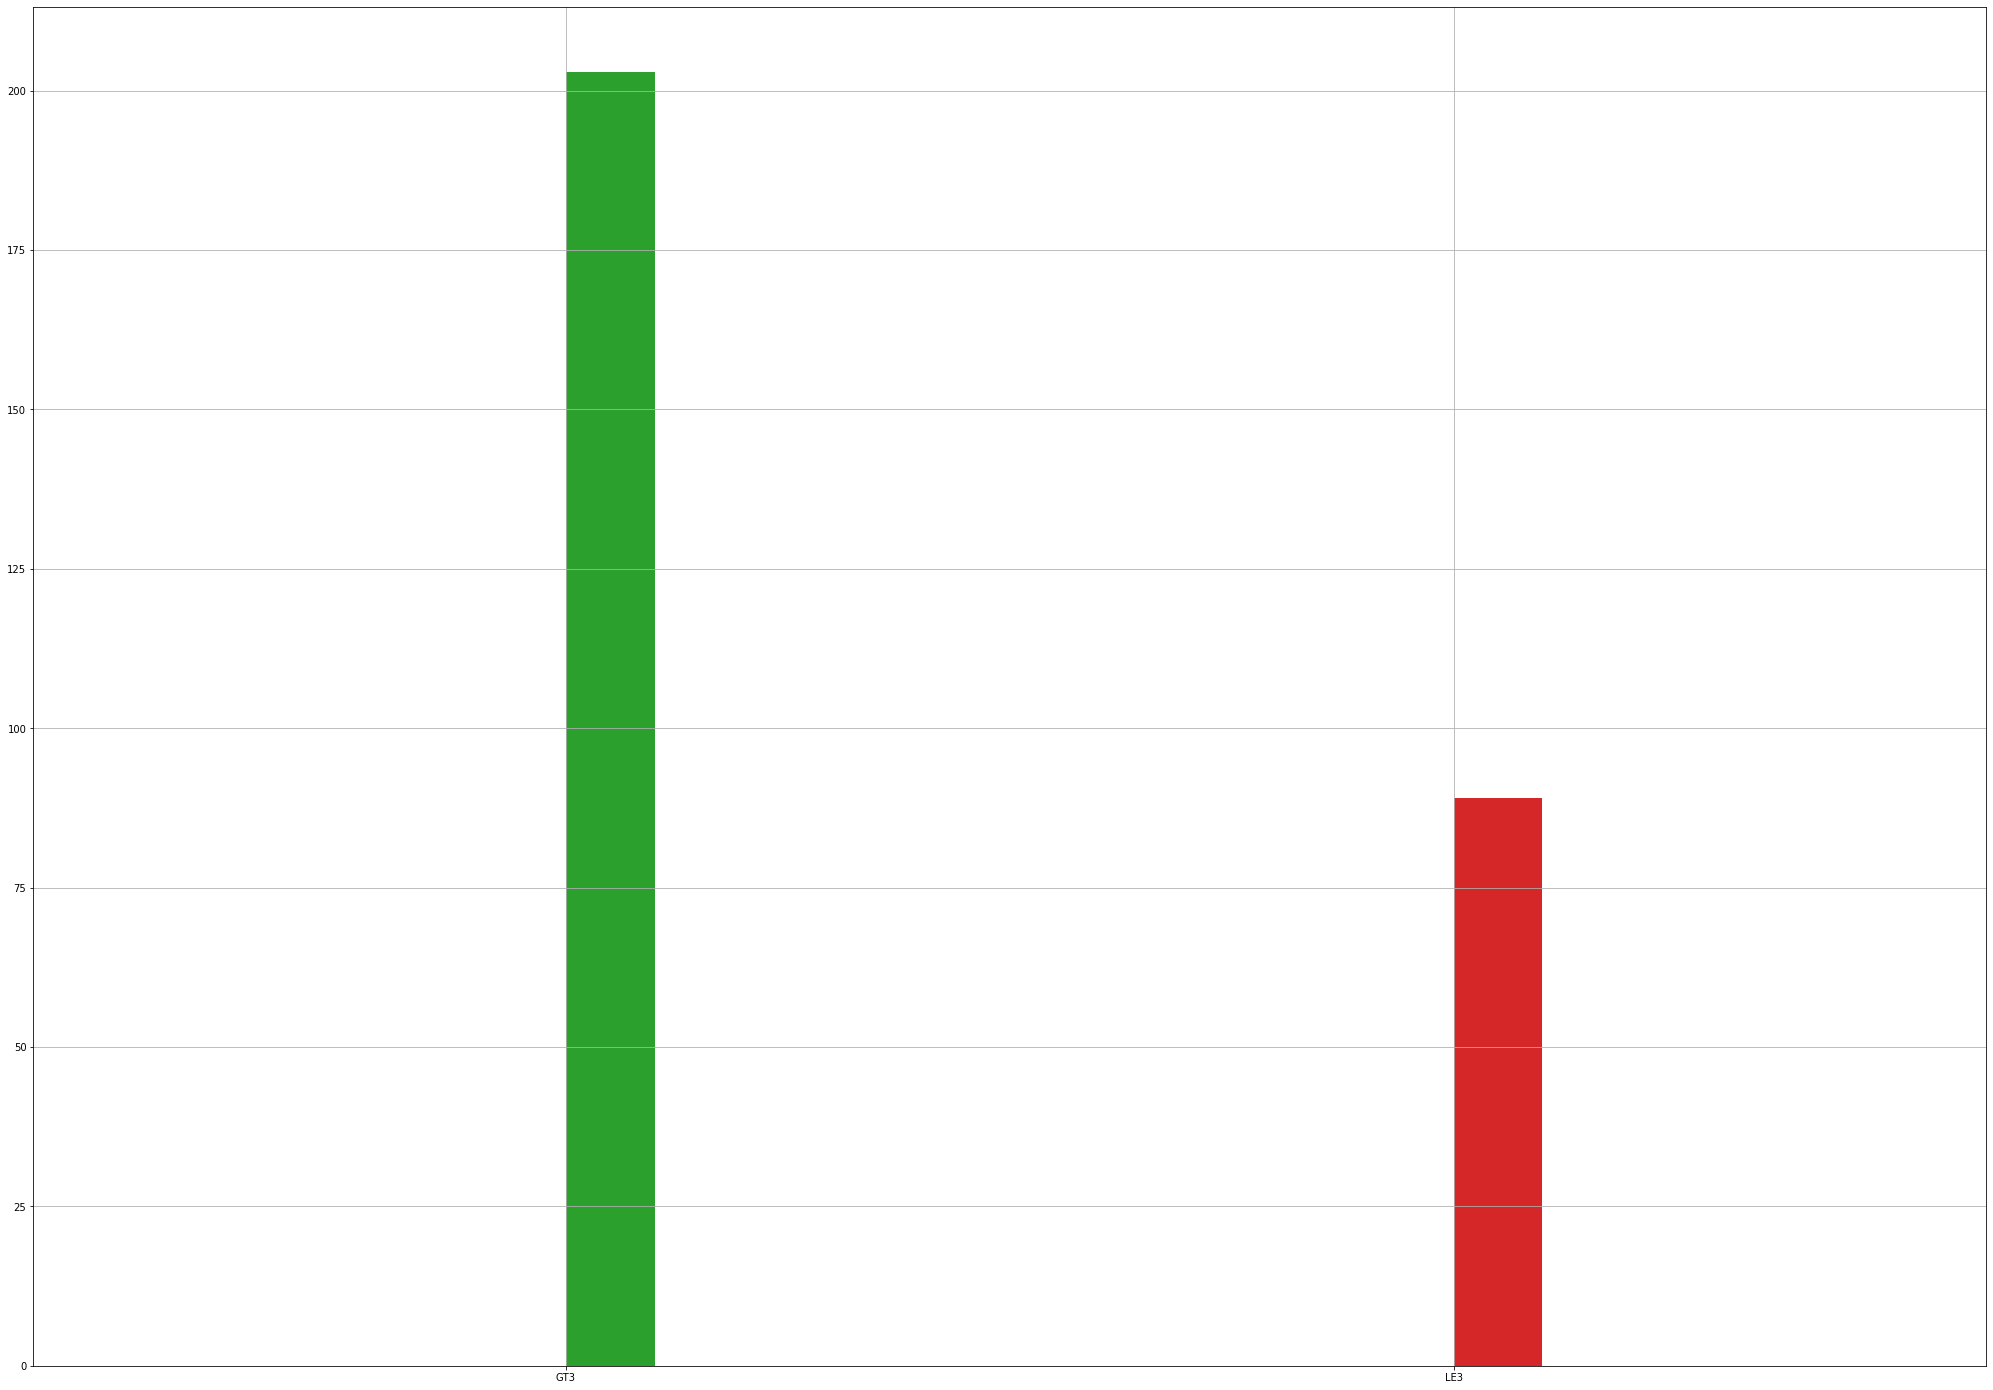

In [145]:
stud.groupby(['address', 'famsize']).famsize.hist()
stud.groupby(['address', 'famsize']).famsize.count()

Общее соотношение GT3/LE3 примерно равно 2.

Среди юношей и девушек соотношение GT3/LE3 также примерно равно 2. Заполним пропуски, беря во внимание пол и это соотношение. То есть для каждого пола наугад заполним GT3 и LE3 таким образом, чтобы было GT3:LE3 как 2:1.

In [146]:
# Найдем индексы для девушек: f_idx_GT3 - индексы, куда будем писать 'GT3', f_idx_LE3 - 'LE3'
print('Female:')
f_idx = stud[['sex','famsize']].loc[(stud.sex == 'F') & (stud.famsize.isnull())].index
print(f_idx)
f_idx_GT3 = f_idx[0:round(2/3*len(f_idx))]
print(f_idx_GT3)
f_idx_LE3 = pd.Index(set(f_idx) - set(f_idx_GT3))
print(f_idx_LE3)

# Аналогичные индексы для юношей
print('Male:')
m_idx = stud[['sex','famsize']].loc[(stud.sex == 'M') & (stud.famsize.isnull())].index
print(m_idx)
m_idx_GT3 = m_idx[0:round(2/3*len(m_idx))]
print(m_idx_GT3)
m_idx_LE3 = pd.Index(set(m_idx) - set(m_idx_GT3))
print('m_idx_LE3 =', m_idx_LE3)

# Объединяем одинаковые индексы
idx_GT3 = pd.Index(set(f_idx_GT3).union(set(m_idx_GT3)))
idx_LE3 = pd.Index(set(f_idx_LE3).union(set(m_idx_LE3)))

Female:
Int64Index([0, 79, 167, 195, 202, 221, 237, 313, 344, 360, 367], dtype='int64')
Int64Index([0, 79, 167, 195, 202, 221, 237], dtype='int64')
Int64Index([360, 313, 344, 367], dtype='int64')
Male:
Int64Index([9, 32, 36, 76, 78, 114, 128, 129, 172, 228, 235, 252, 253, 254,
            268, 280],
           dtype='int64')
Int64Index([9, 32, 36, 76, 78, 114, 128, 129, 172, 228, 235], dtype='int64')
m_idx_LE3 = Int64Index([268, 280, 252, 253, 254], dtype='int64')


In [147]:
# Заполняем 'GT3'
stud.loc[idx_GT3, 'famsize'] = 'GT3'
# stud.iloc[idx_GT3]

In [148]:
# Заполняем 'LE3'
stud.loc[idx_LE3, 'famsize'] = 'LE3'
# stud.iloc[idx_LE3]

In [149]:
stud.famsize.isnull().sum()

0

##### Выводы по колонке famsize:
- Заполнили пропуски по алгоритму, описанному выше

#### 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

T    314
A     36
Name: Pstatus, dtype: int64


45

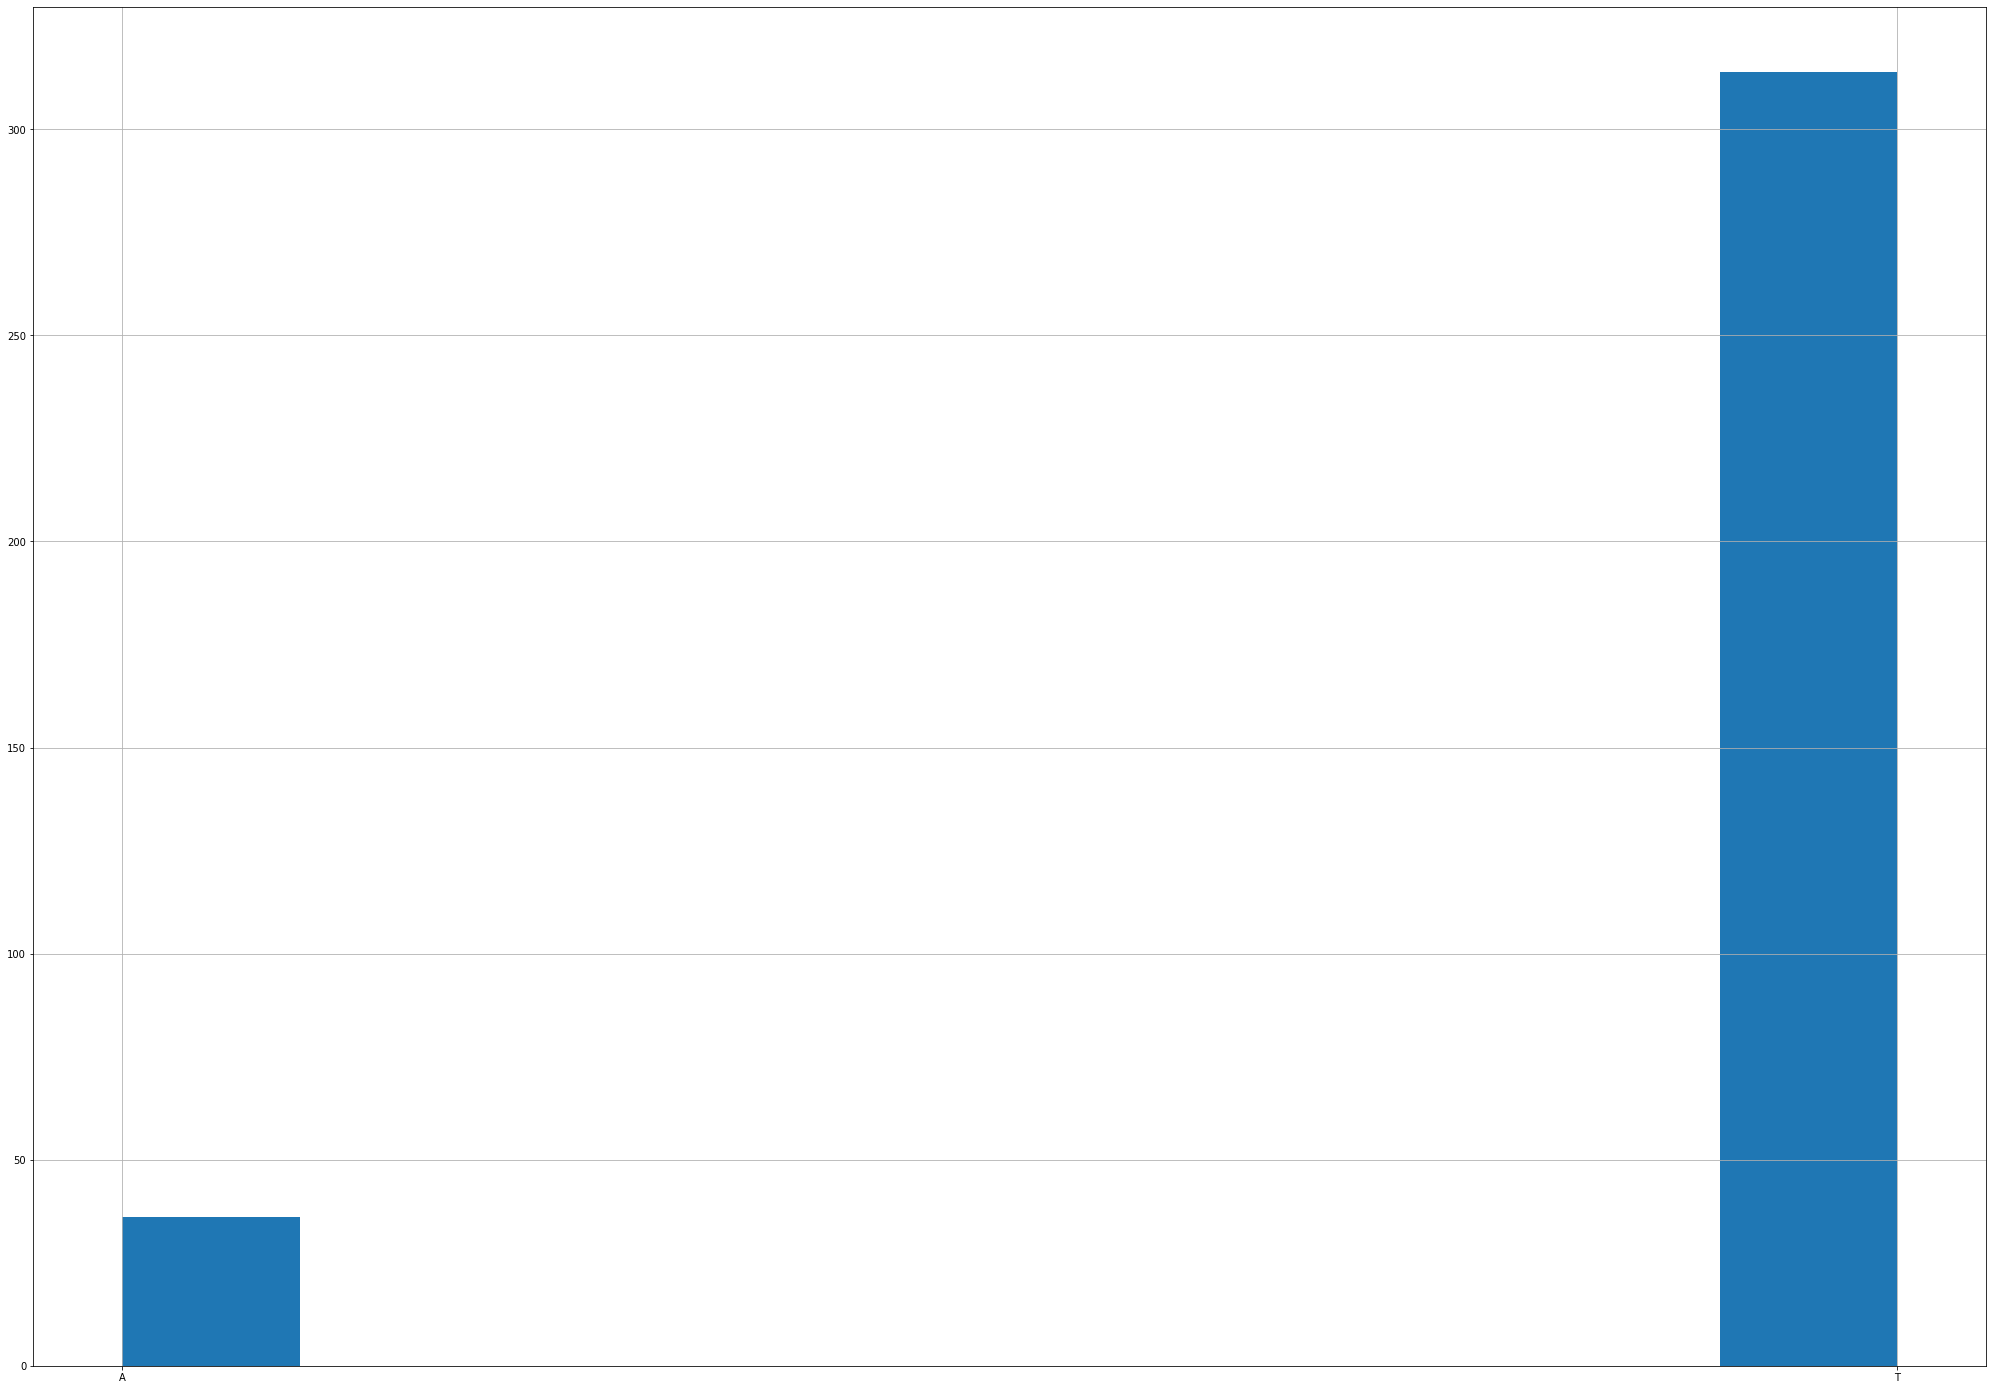

In [150]:
stud.Pstatus.hist();
print(stud.Pstatus.value_counts())
stud.Pstatus.isnull().sum()

Посмотрим, как признак связан с возрастом. Предположим, что старше какого-то возраста все живут отдельно.

In [151]:
stud.groupby(['Pstatus', 'age']).age.count()

Pstatus  age
A        15     10
         16      8
         17      9
         18      5
         19      2
         20      2
T        15     63
         16     82
         17     81
         18     67
         19     18
         20      1
         21      1
         22      1
Name: age, dtype: int64

Предположение не подтвердилось: все возрасты живут как вместе с родителями, так и раздельно. А самые возрастные - 21 и 22 года - так те только с родителями.

Поэтому пропуски заполним значением 'T', как максимально представленным в выборке.

In [152]:
# Получим индексы с пропусками в признаке Pstatus
Pstatus_null_idx = stud.loc[stud.Pstatus.isnull()].index
# Заполним пропуски
stud.loc[Pstatus_null_idx, 'Pstatus'] = 'T'
# Проверка
stud.Pstatus.isnull().sum()

0

##### Выводы по колонке Pstatus:
- Все возрасты живут как вместе с родителями, так и раздельно со значительным преобладанием "с родителями".
- Все пропуски заполнены значением 'T', как максимально представленным в выборке.

#### 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64


3

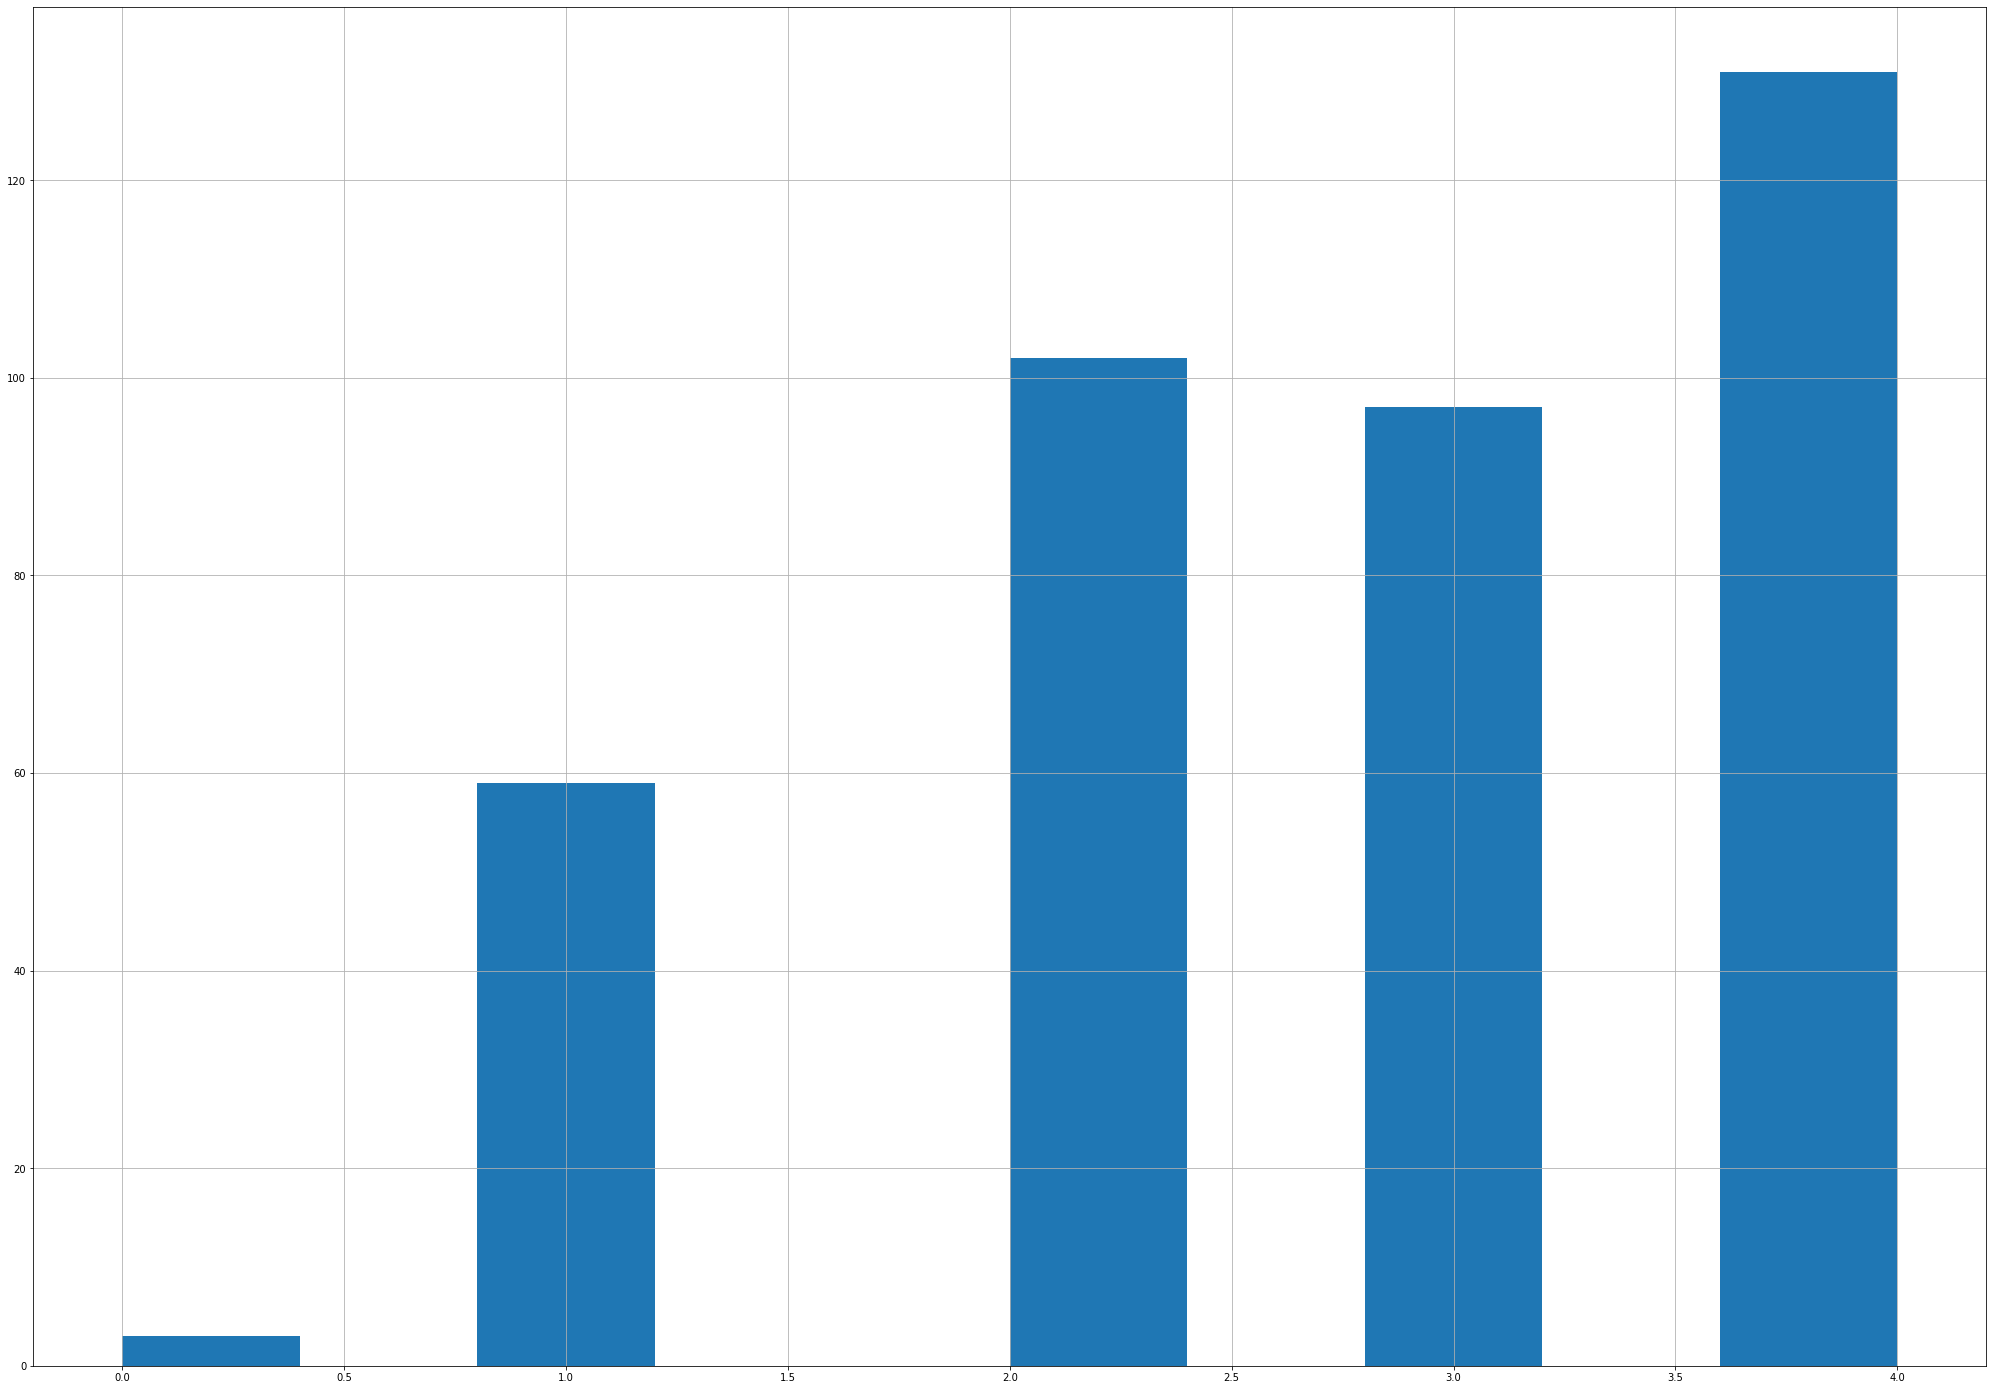

In [153]:
stud.Medu.hist();
print(stud.Medu.value_counts())
stud.Medu.isnull().sum()

Как ни странно, мамы с высшим образованием в абсолютном большинстве. Пропусков всего 3.

А как этот признак=NaN соотносится с первыми тремя максимально заполненными колонками?

In [154]:
stud[['school', 'sex', 'age', 'Medu']].loc[stud.Medu.isnull()]

,school,sex,age,Medu
92,GP,F,16,NaN
193,GP,M,16,NaN
239,GP,M,18,NaN


Ввиду того, что пропусков мало, посмотрим как выглядят колонки с заполненным Medu и фиксированных ['school', 'sex', 'age']

2.0    19
4.0    16
3.0    13
1.0     5
Name: Medu, dtype: int64

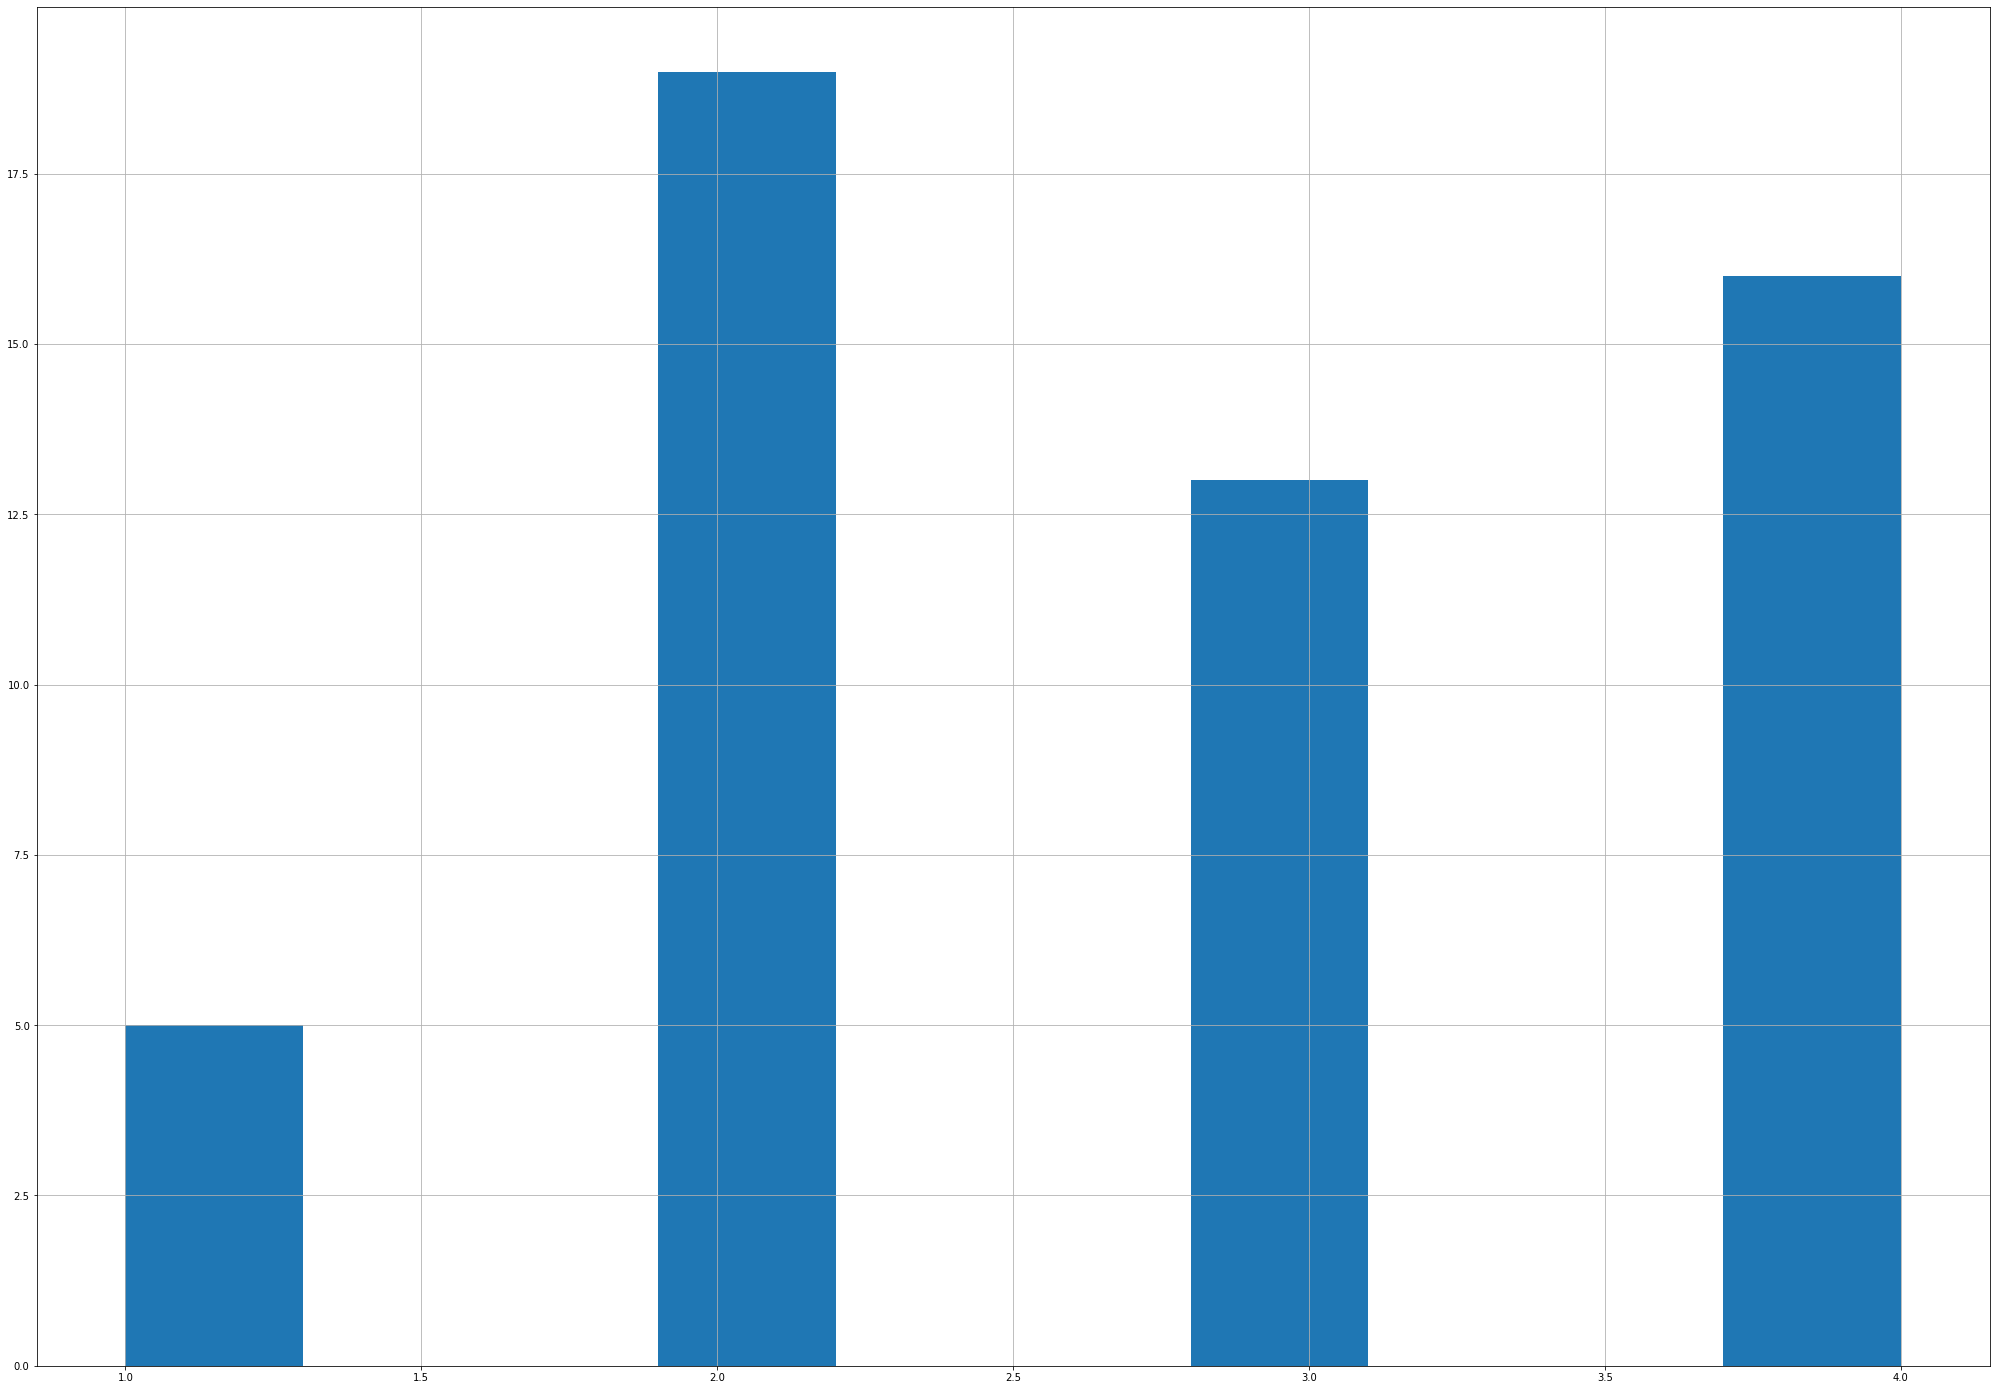

In [155]:
# GP	F	16 --> MeduMax = 2
stud.loc[(stud.school == 'GP') & (stud.sex == 'F') & (stud.age == 16)].Medu.hist();
stud.loc[(stud.school == 'GP') & (stud.sex == 'F') & (stud.age == 16)].Medu.value_counts()

4.0    19
3.0    13
2.0    11
1.0     5
0.0     1
Name: Medu, dtype: int64

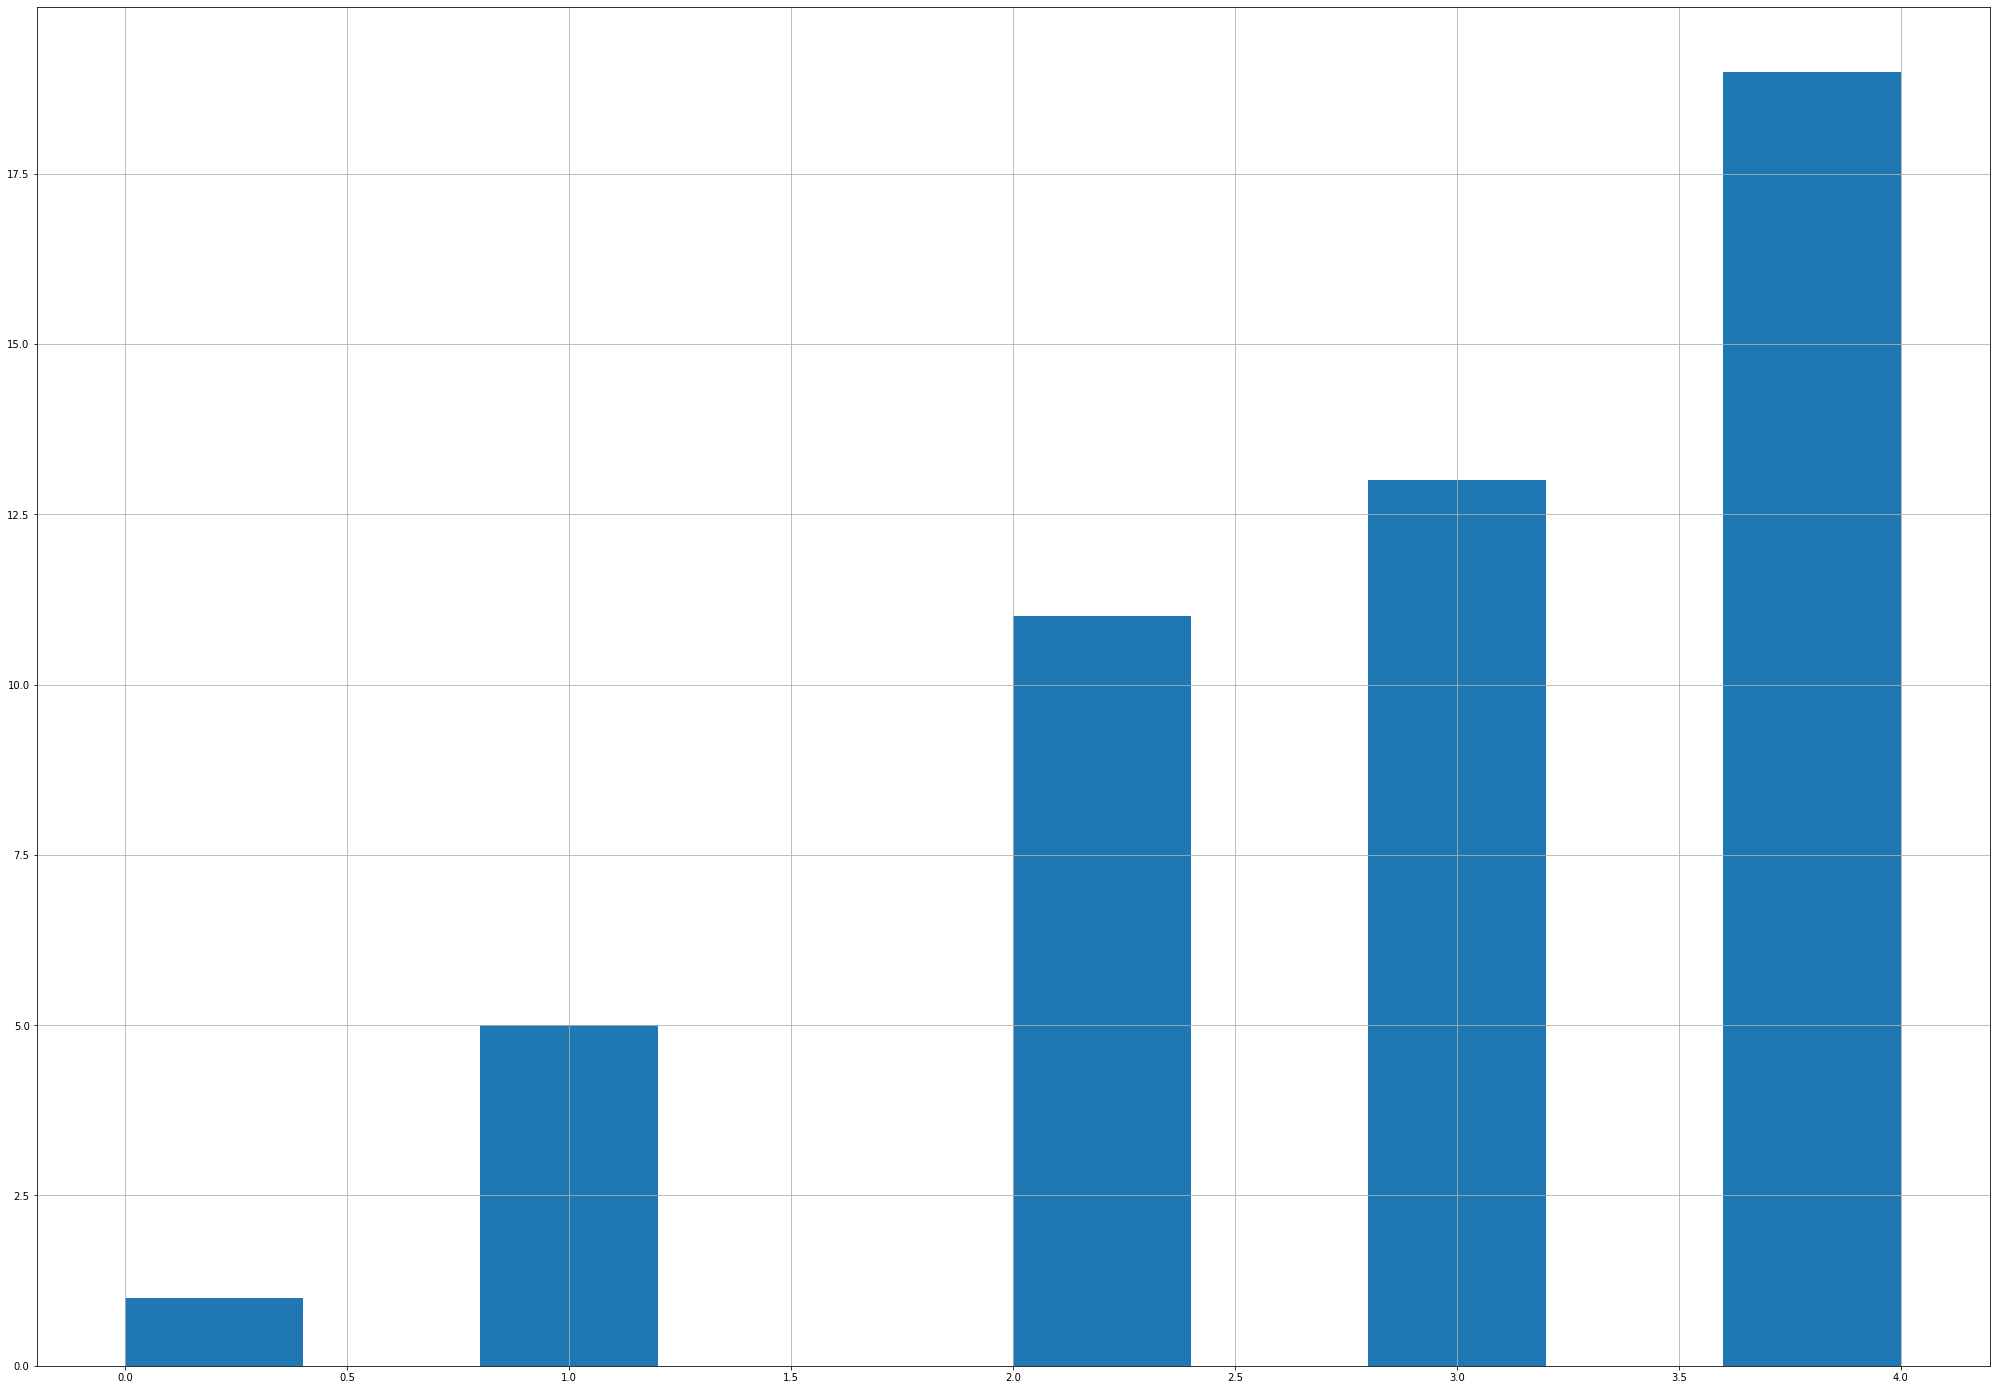

In [156]:
# GP	M	16 --> MeduMax = 4
stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 16)].Medu.hist();
stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 16)].Medu.value_counts()

4.0    11
2.0     8
3.0     7
1.0     1
Name: Medu, dtype: int64

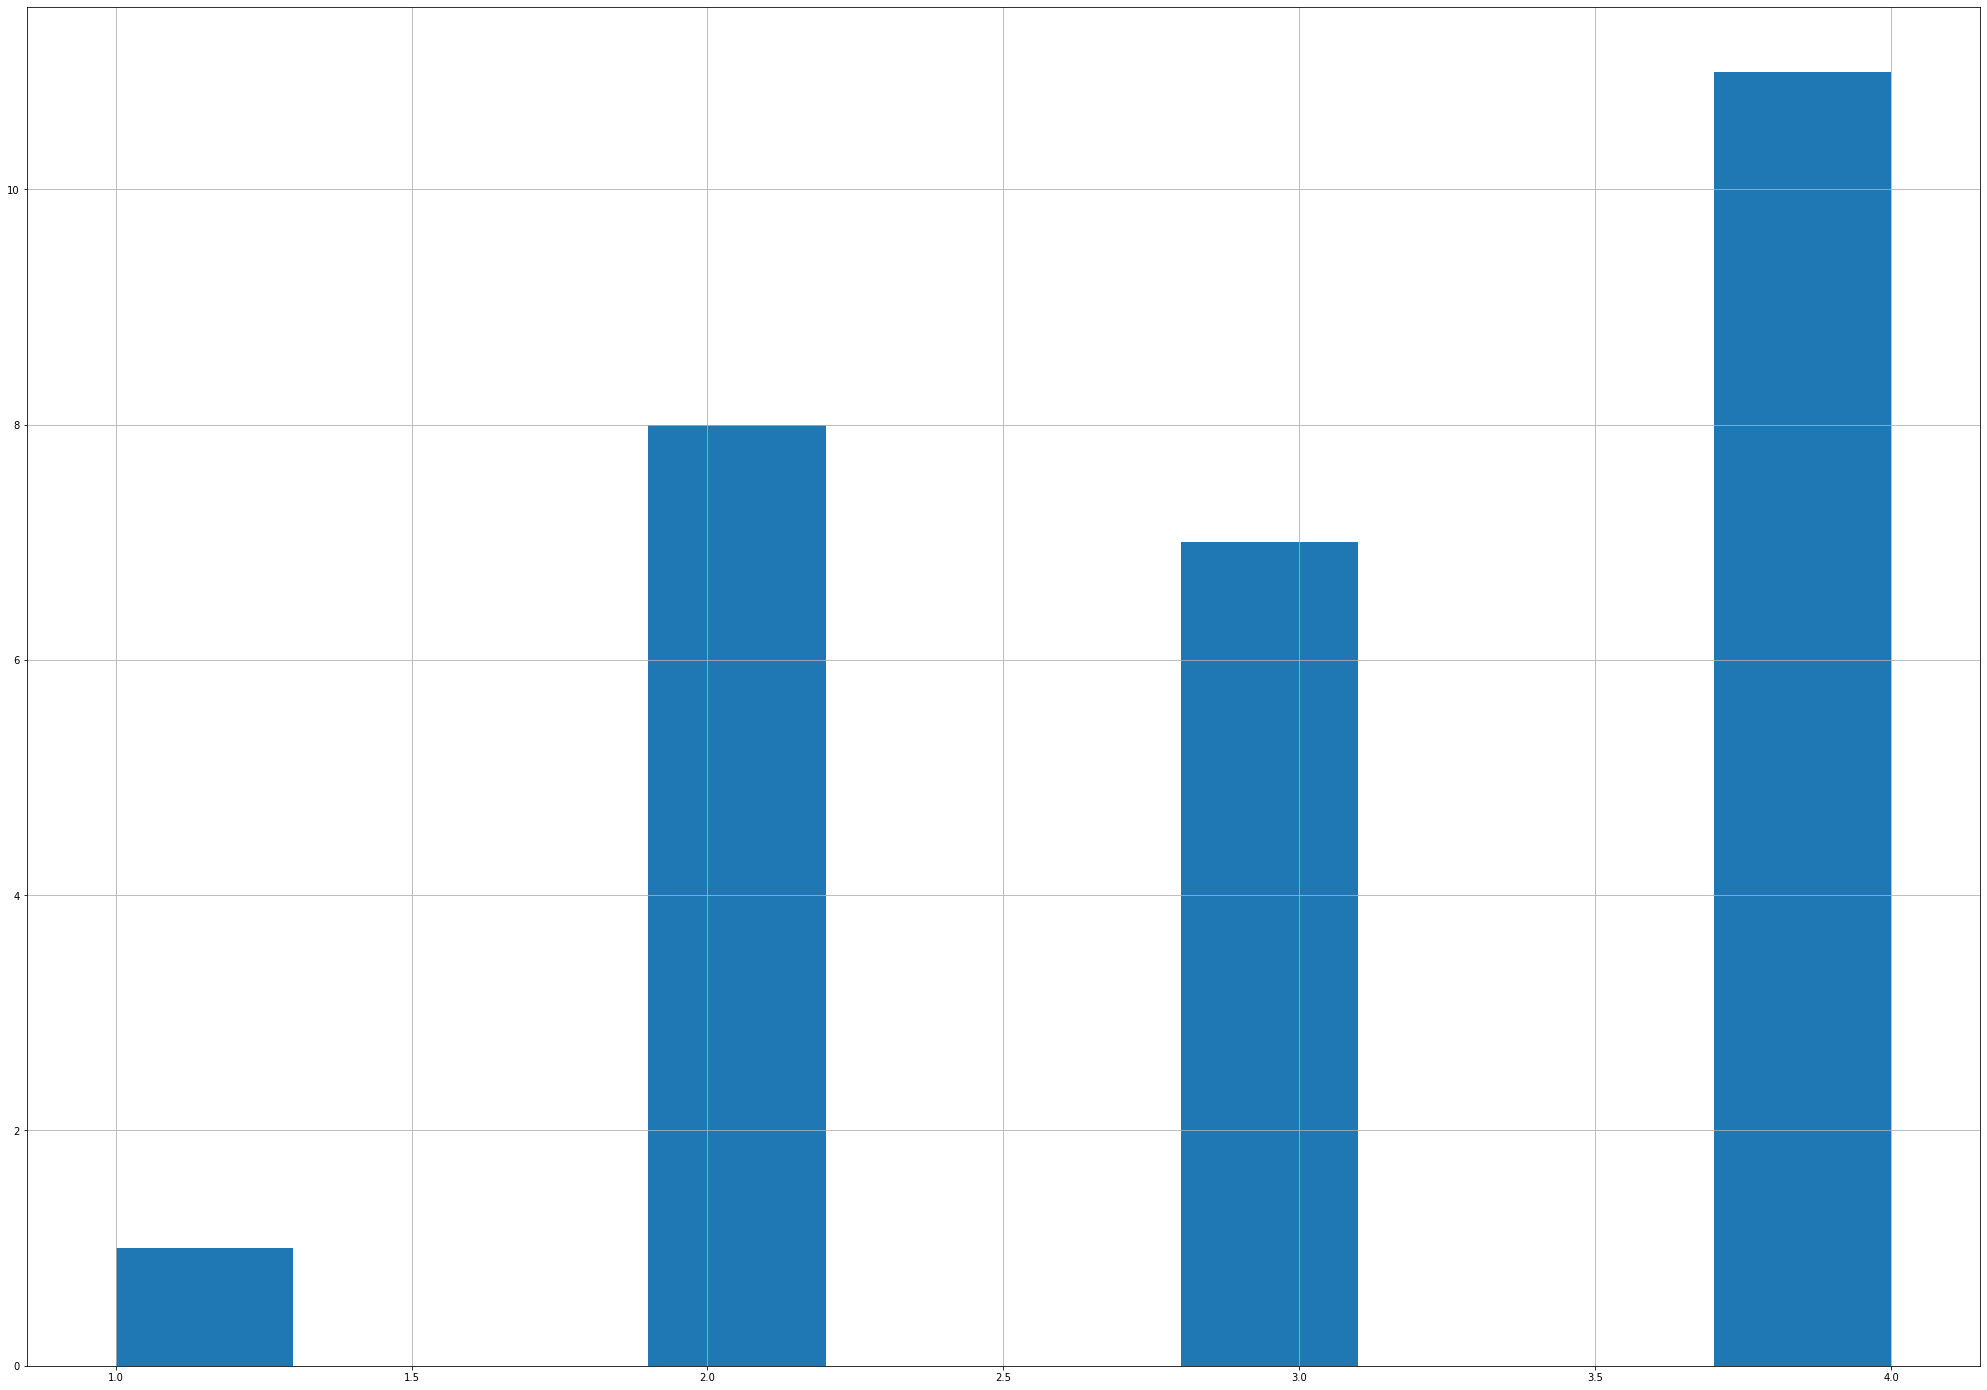

In [157]:
# GP	M	18 --> MeduMax = 4
stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 18)].Medu.hist();
stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 18)].Medu.value_counts()

Заполним пропуски, исходя из максимальных значений признака Medu при фиксированных значениях признаков school, sex, age (см. анализ выше)

In [158]:
# GP	F	16 --> MeduMax = 2
idx = stud.loc[(stud.school == 'GP') & (stud.sex == 'F') & (stud.age == 16) & 
               (stud.Medu.isnull())].Medu.index
stud.loc[idx, 'Medu'] = 2

# GP	M	16 --> MeduMax = 4
idx = stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 16) & 
               (stud.Medu.isnull())].Medu.index
stud.loc[idx, 'Medu'] = 4


# GP	M	18 --> MeduMax = 4
idx = stud.loc[(stud.school == 'GP') & (stud.sex == 'M') & (stud.age == 18) & 
               (stud.Medu.isnull())].Medu.index
stud.loc[idx, 'Medu'] = 4

stud.Medu.isnull().sum()

0

##### Выводы по колонке Medu
- Пропусков всего 3.
- Заполнили пропуски, исходя из максимальных значений признака Medu при фиксированных значениях признаков school, sex, age.

#### Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64


24

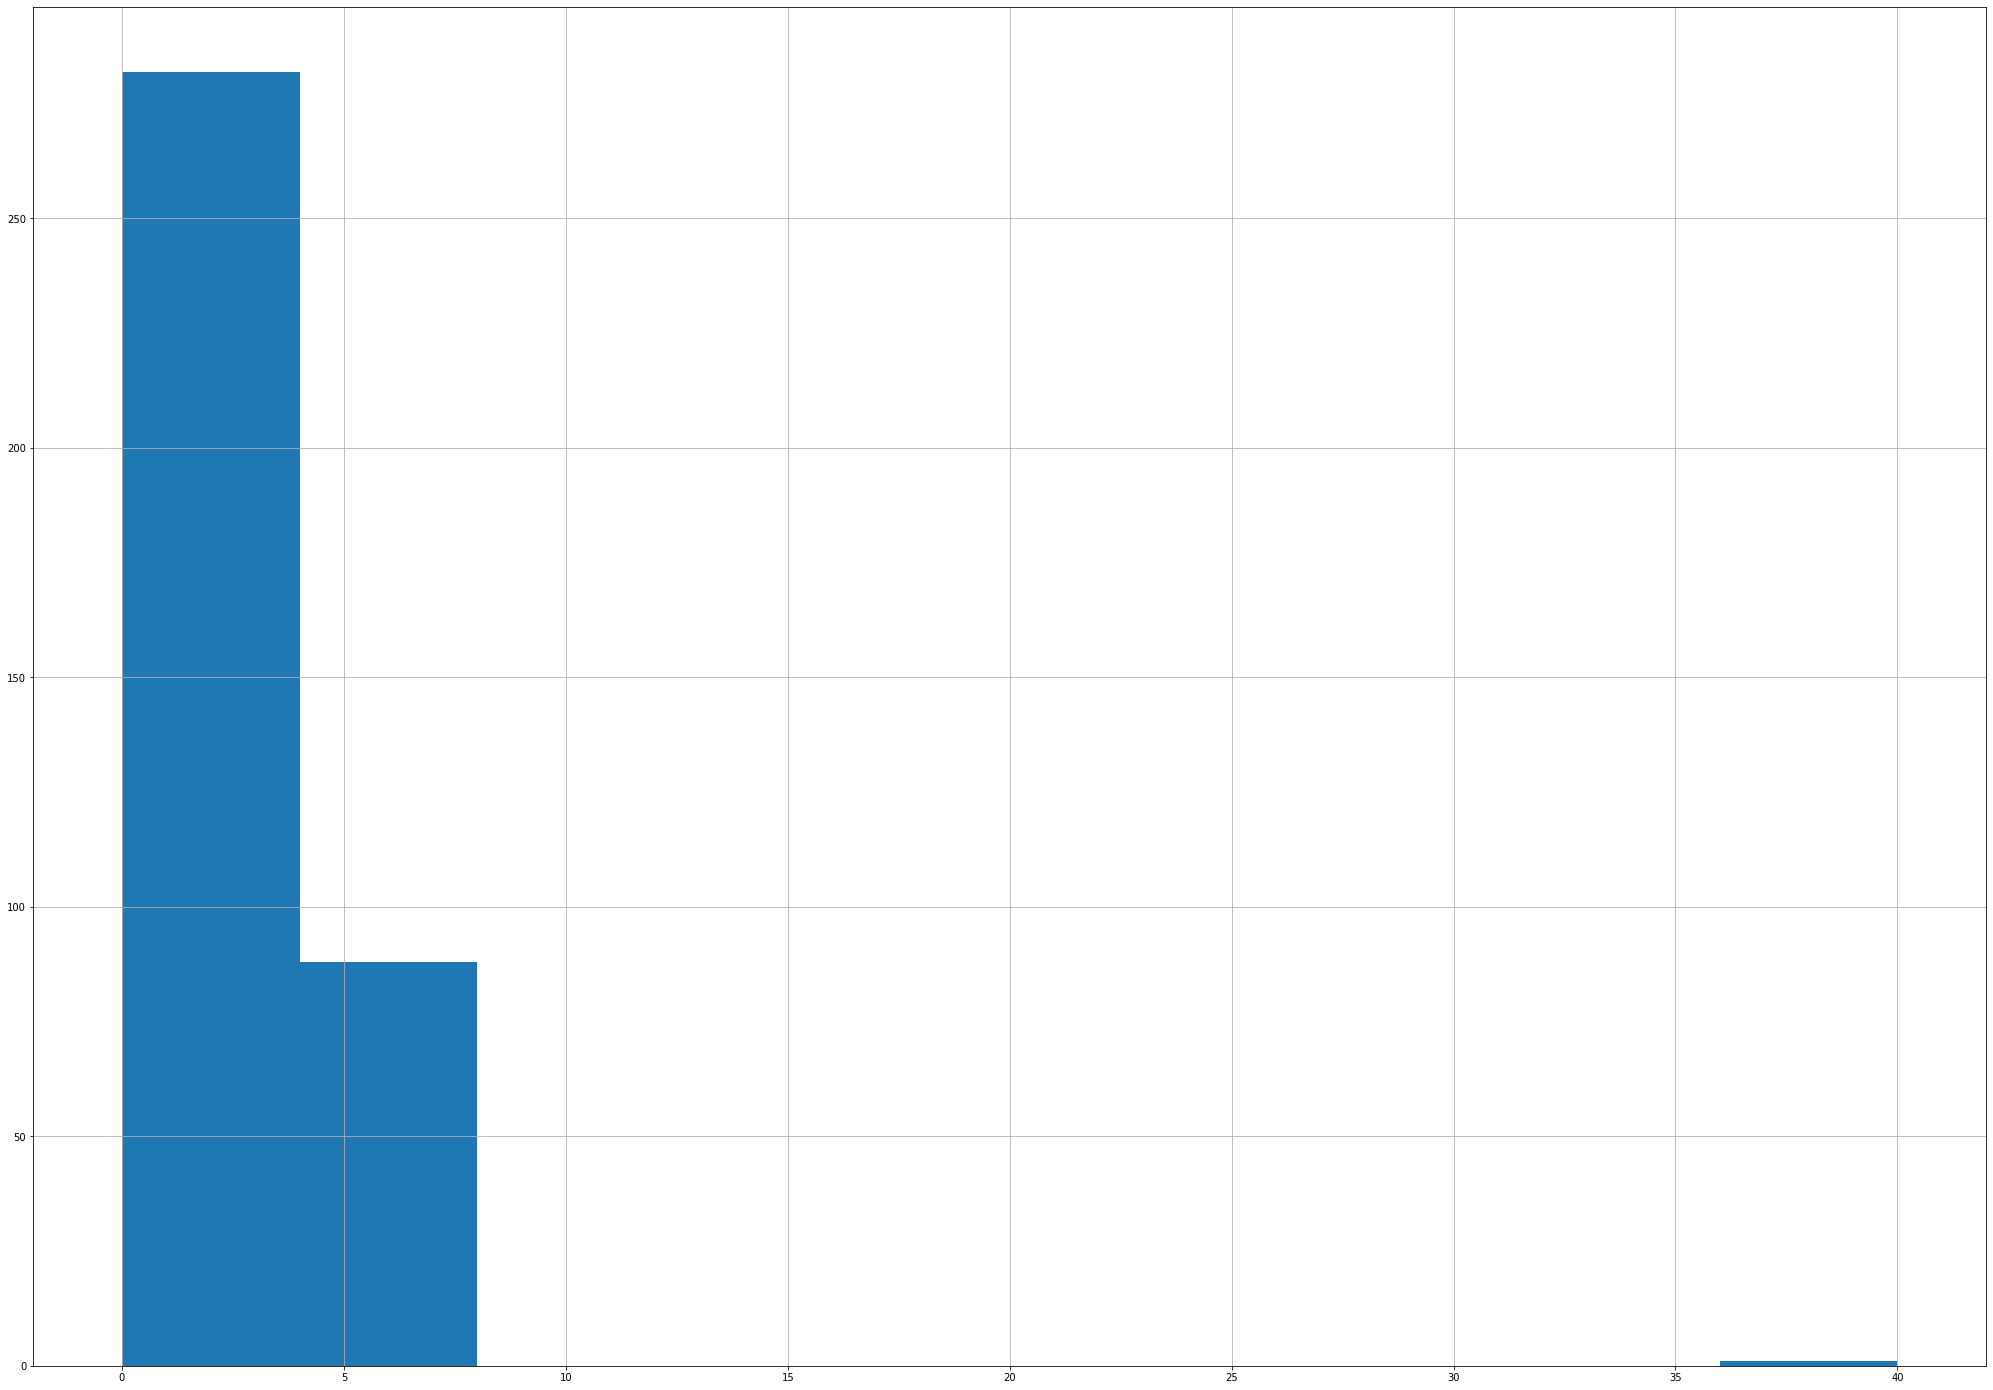

In [159]:
stud.Fedu.hist();
print(stud.Fedu.value_counts())
stud.Fedu.isnull().sum()

О, с образованием пап дела обстоят иначе.

Пропусков 24. 

И здесь имеется выброс. Судя по значению выброса, скорее всего это описка при записи значения = 4. Сначала исправим этот выброс с 40 на 4.

2.0    106
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64


24

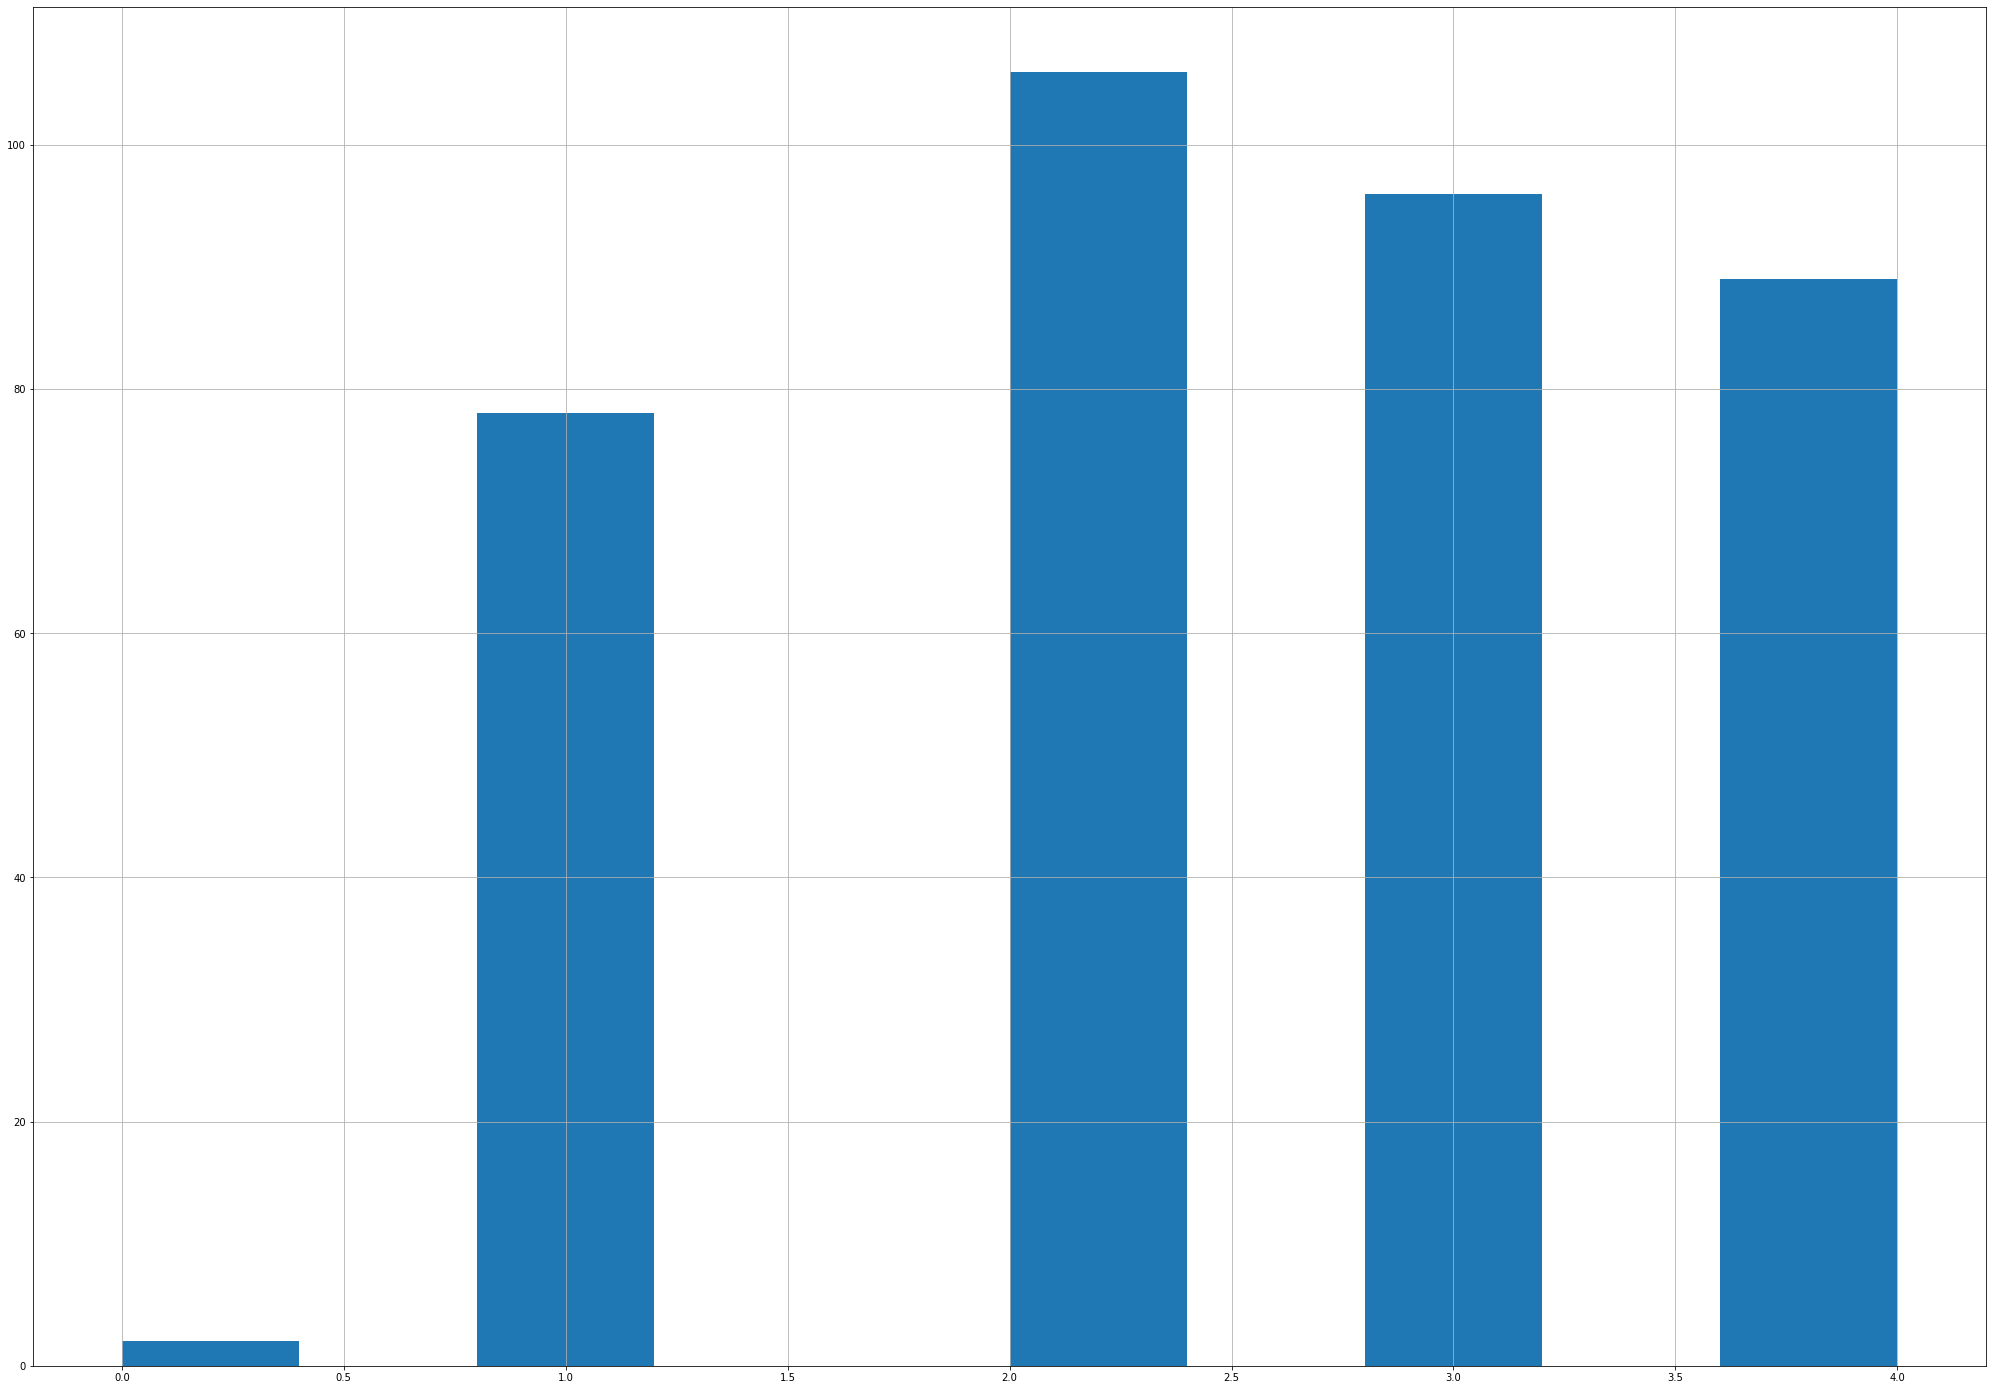

In [160]:
Fedu_out_idx = stud.Fedu.loc[stud.Fedu == 40.]
stud.Fedu = stud.Fedu.apply(lambda x: 4. if x == 40. else x)

# Снова построим распределение, уже без выброса
stud.Fedu.hist();
print(stud.Fedu.value_counts())
stud.Fedu.isnull().sum()

Преобладает значение 2. Ввиду некоторой колоколообразности, заменим все пропуски на 2 - в каком-то смысле на среднее значение.

In [161]:
Fedu_null_idx = stud.loc[stud.Fedu.isnull()].index
stud.loc[Fedu_null_idx, 'Fedu'] = 2
# Проверка после замены
stud.Fedu.isnull().sum()

0

##### Выводы по колонке Fedu
- Был выброс, который заменили на подходящее значение, исходя из общих соображений. Скорее всего справа случайно был приписан 0.
- В остальном все пропуски заменили на среднее значение = 2, исходя из вида распределения

#### 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64


19

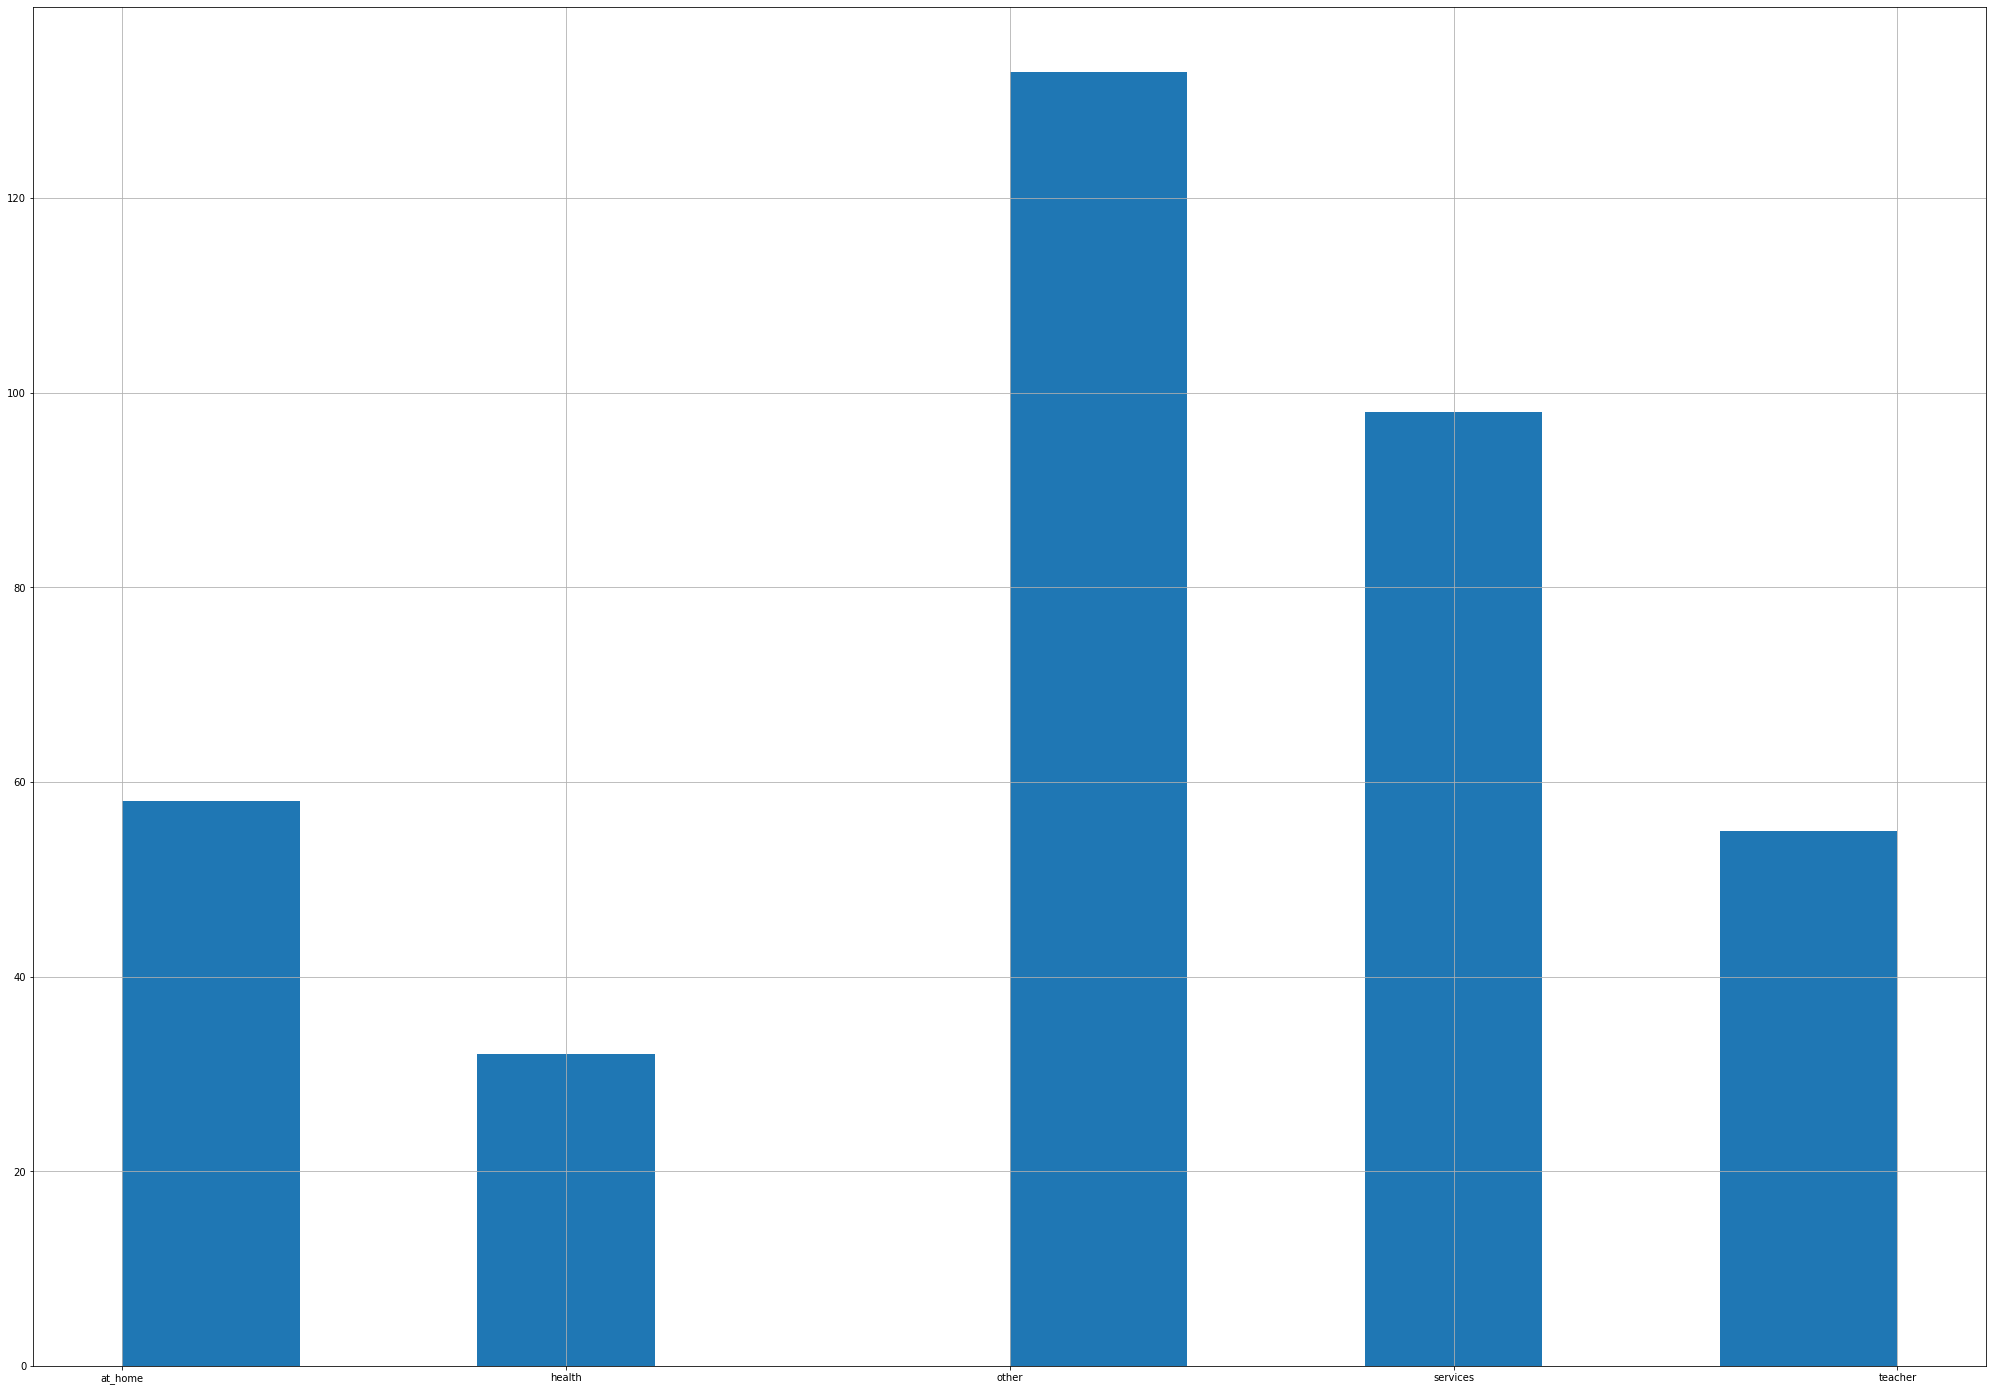

In [162]:
stud.Mjob.hist();
print(stud.Mjob.value_counts())
stud.Mjob.isnull().sum()

In [163]:
# Исходя из вида распределения, все пропуски заменим на среднее значение = 'other'
Mjob_null_idx = stud.loc[stud.Mjob.isnull()].index
stud.loc[Mjob_null_idx, 'Mjob'] = 'other'
# Проверка после замены
stud.Mjob.isnull().sum()

0

##### Выводы по колонке Mjob
- Распределение - колоколообразное. Исходя из вида распределения, все пропуски заменили на среднее значение = 'other'

#### 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64


36

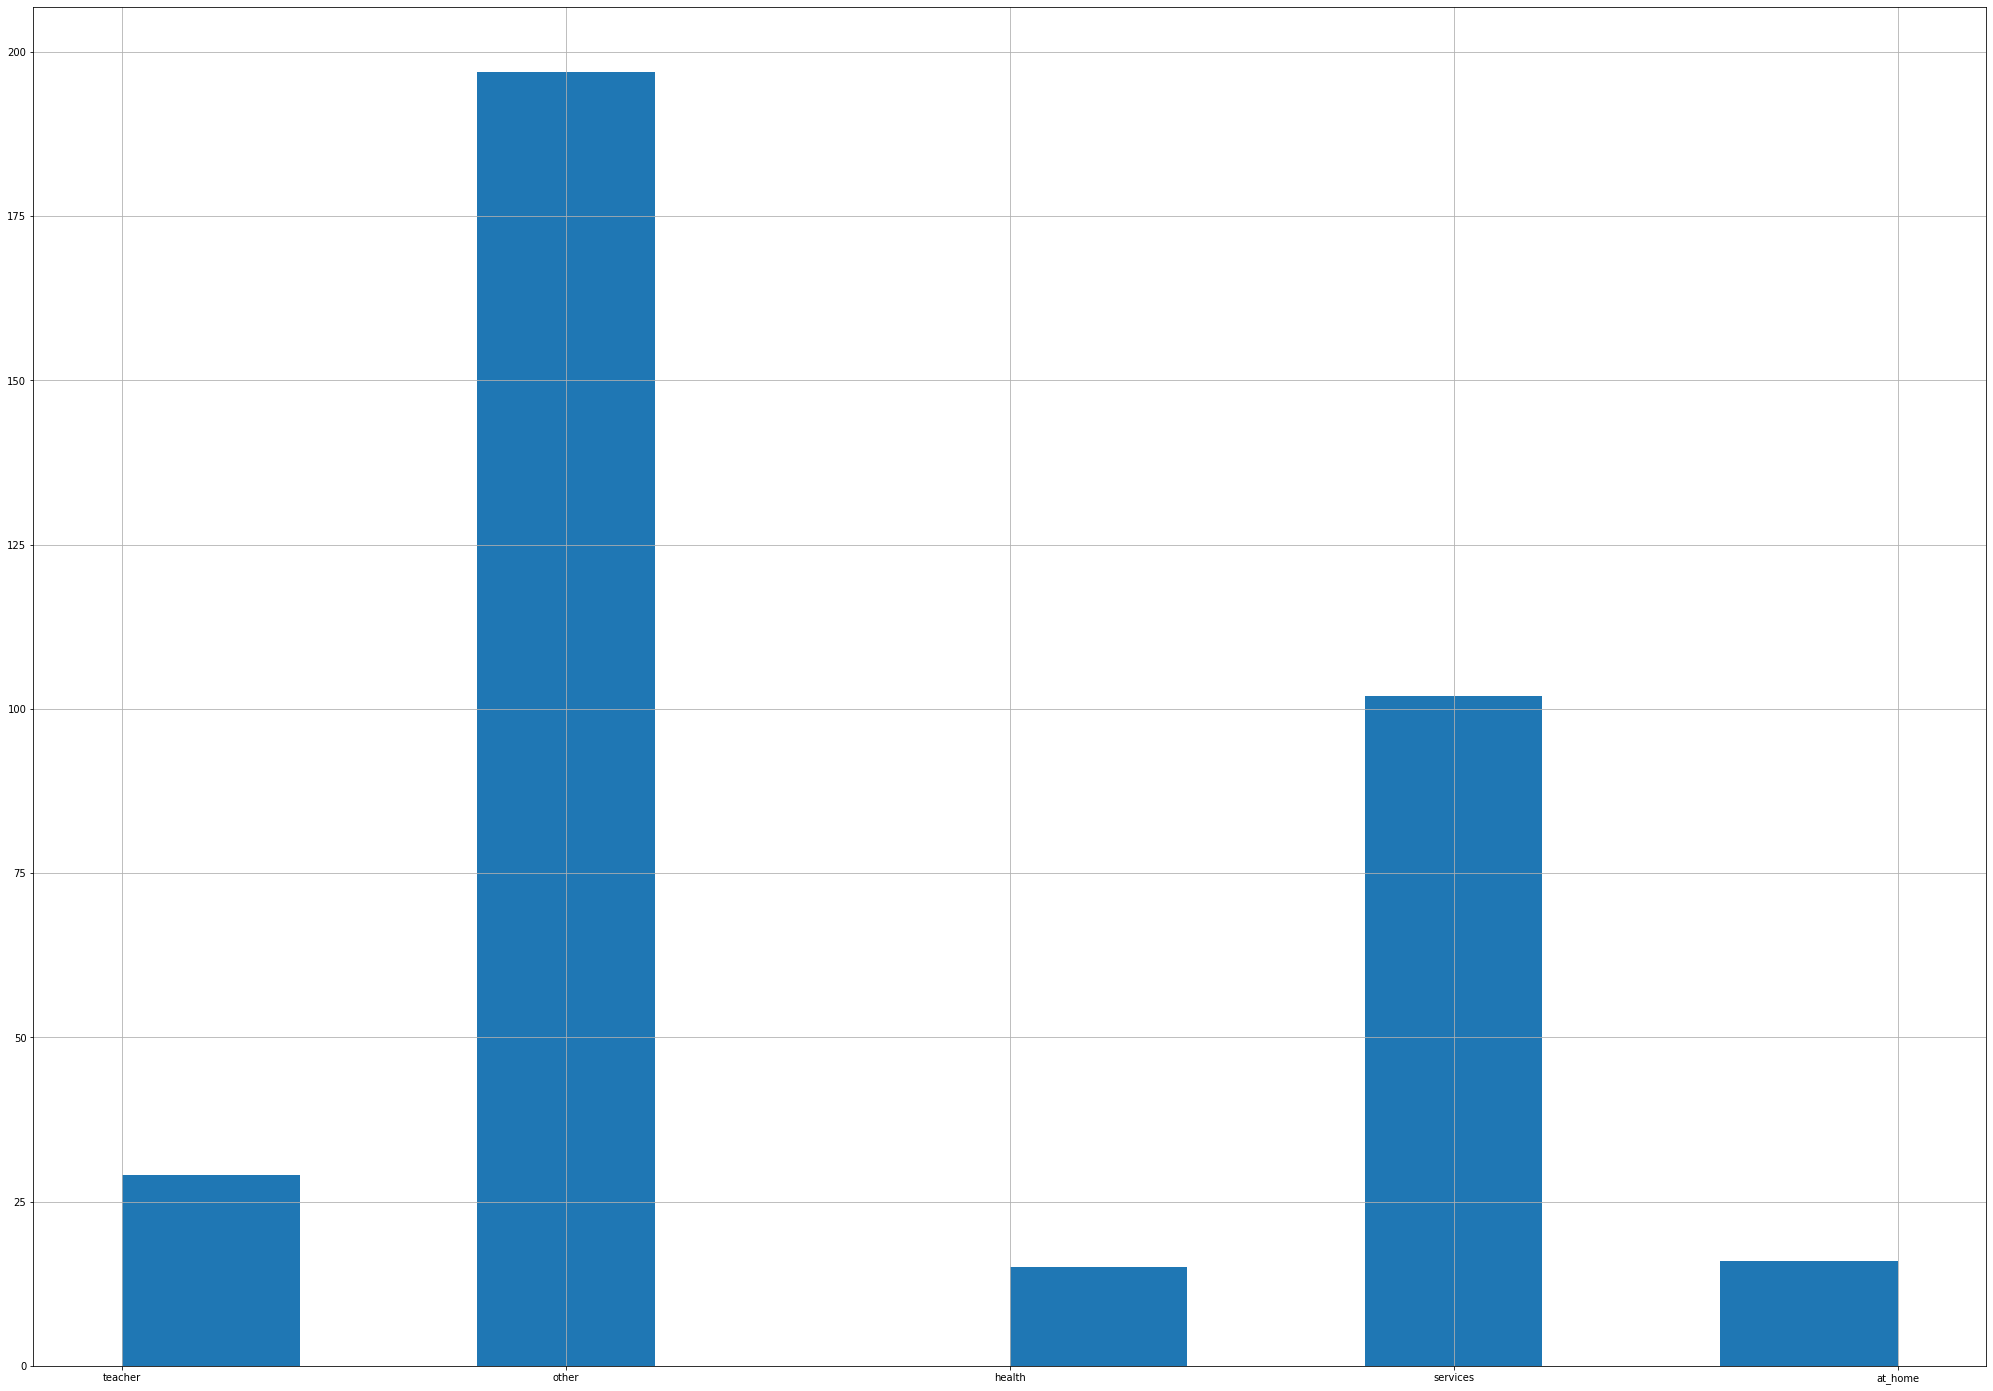

In [164]:
stud.Fjob.hist();
print(stud.Fjob.value_counts())
stud.Fjob.isnull().sum()

Распределение не колоколообразное, но значение 'other' явно выделяется. На него и заменим все пропуски

In [165]:
Fjob_null_idx = stud.loc[stud.Fjob.isnull()].index
stud.loc[Fjob_null_idx, 'Fjob'] = 'other'
# Проверка после замены
stud.Fjob.isnull().sum()

0

##### Выводы по колонке Fjob
- Исходя из вида распределения, все пропуски заменены на среднее значение = 'other'

#### 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64


17

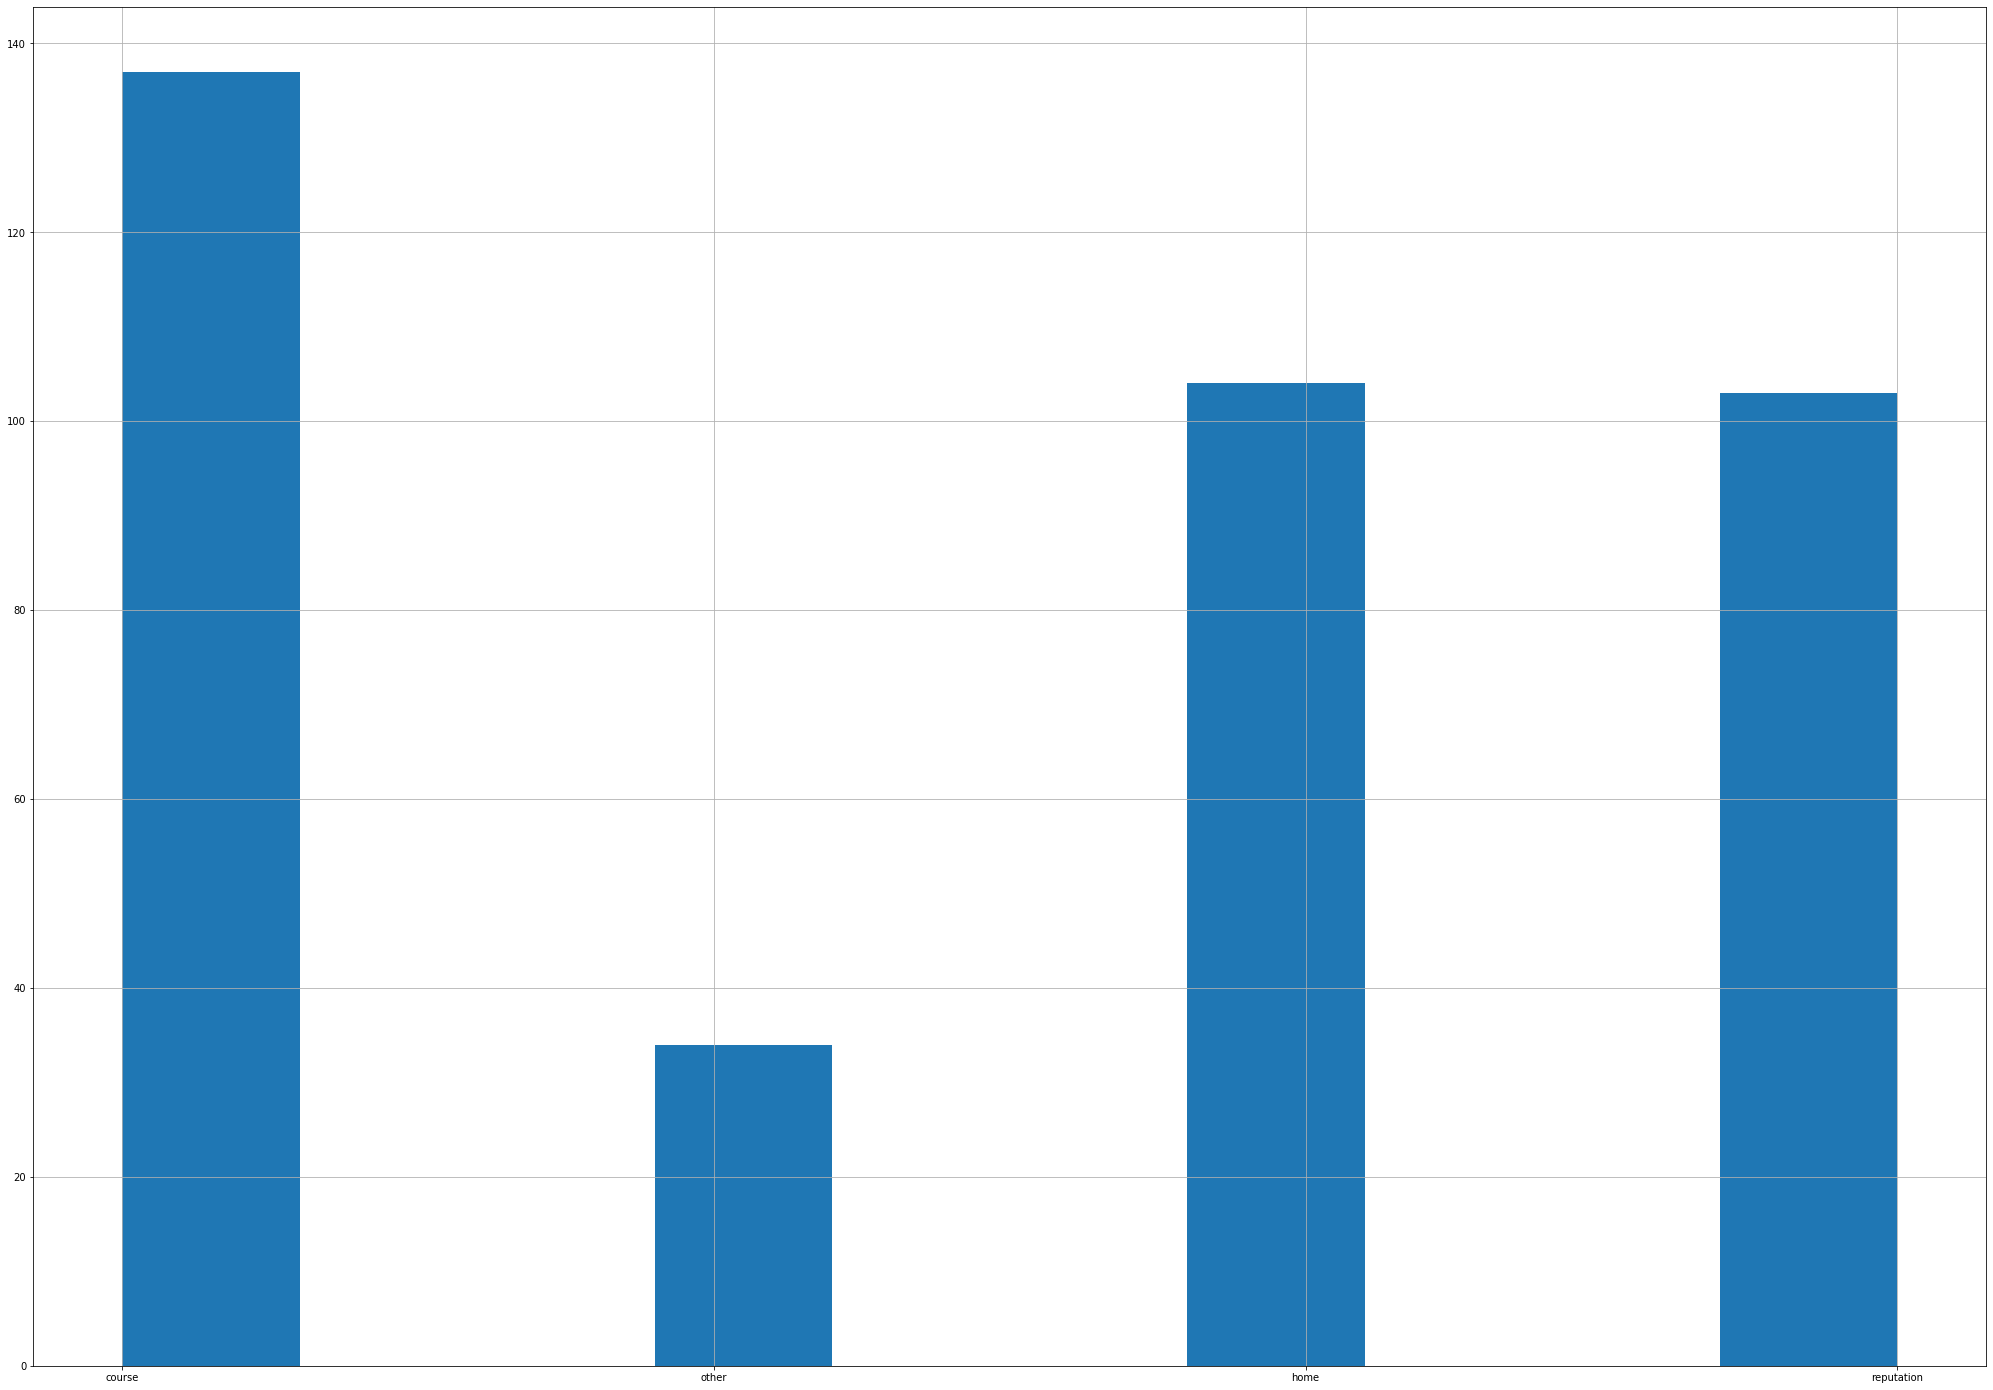

In [166]:
stud.reason.hist();
print(stud.reason.value_counts())
stud.reason.isnull().sum()

In [167]:
stud.groupby(['school', 'reason']).reason.count()

school  reason    
GP      course        119
        home           94
        other          25
        reputation     98
MS      course         18
        home           10
        other           9
        reputation      5
Name: reason, dtype: int64

In [168]:
stud.groupby(['sex', 'reason']).reason.count()

sex  reason    
F    course        68
     home          50
     other         18
     reputation    64
M    course        69
     home          54
     other         16
     reputation    39
Name: reason, dtype: int64

In [169]:
stud.groupby(['age', 'reason']).reason.count()

age  reason    
15   course        29
     home          21
     other          8
     reputation    22
16   course        32
     home          29
     other          9
     reputation    27
17   course        39
     home          20
     other          4
     reputation    28
18   course        30
     home          24
     other         10
     reputation    18
19   course         3
     home          10
     other          2
     reputation     8
20   course         3
21   course         1
22   other          1
Name: reason, dtype: int64

Судя по виду распределений, значение "course" преобладает во всех рассмотренных случаях (сравнение с первыми тремя колонками).

Несмотря на небольшой отрыв, возьмем именно это значение для заполнения пропусков.

In [170]:
reason_null_idx = stud.loc[stud.reason.isnull()].index
stud.loc[reason_null_idx, 'reason'] = 'course'
# Проверка после замены
stud.reason.isnull().sum()

0

##### Выводы по колонке reason
- Исходя из вида распределения, все пропуски заменены на значение = 'course', как максимально представленное

#### 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

mother    250
father     86
other      28
Name: guardian, dtype: int64


31

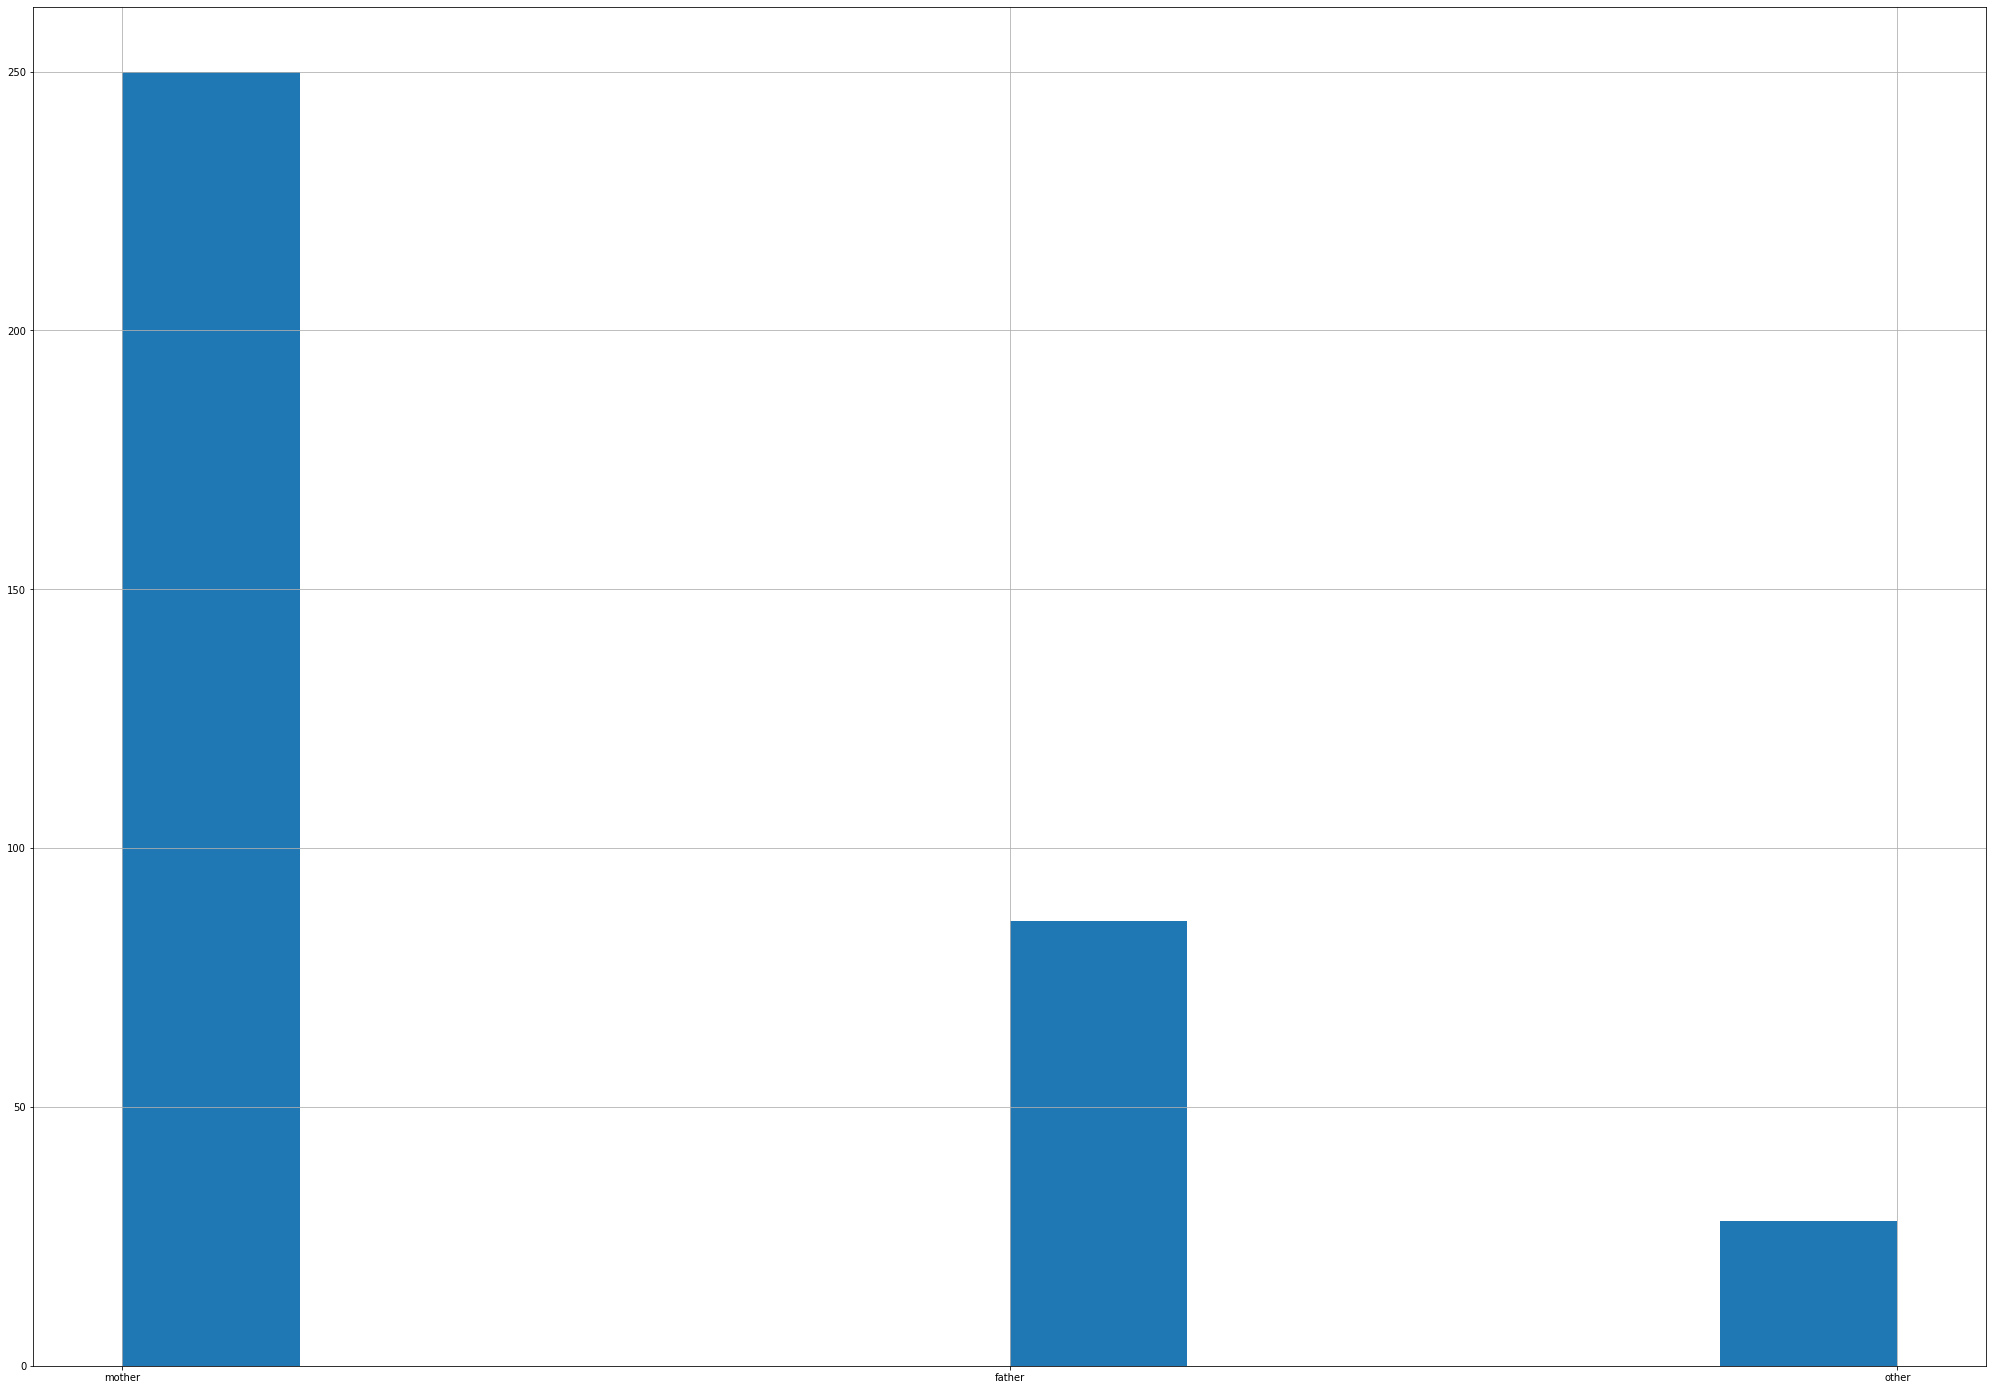

In [171]:
stud.guardian.hist();
print(stud.guardian.value_counts())
stud.guardian.isnull().sum()

In [172]:
guardian_null_idx = stud.loc[stud.guardian.isnull()].index
stud.loc[guardian_null_idx, 'guardian'] = 'mother'
# Проверка после замены
stud.guardian.isnull().sum()

0

##### Выводы по колонке guardian
- Исходя из вида распределения, все пропуски заменены на значение = 'mother', как максимально представленное

#### 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64


28

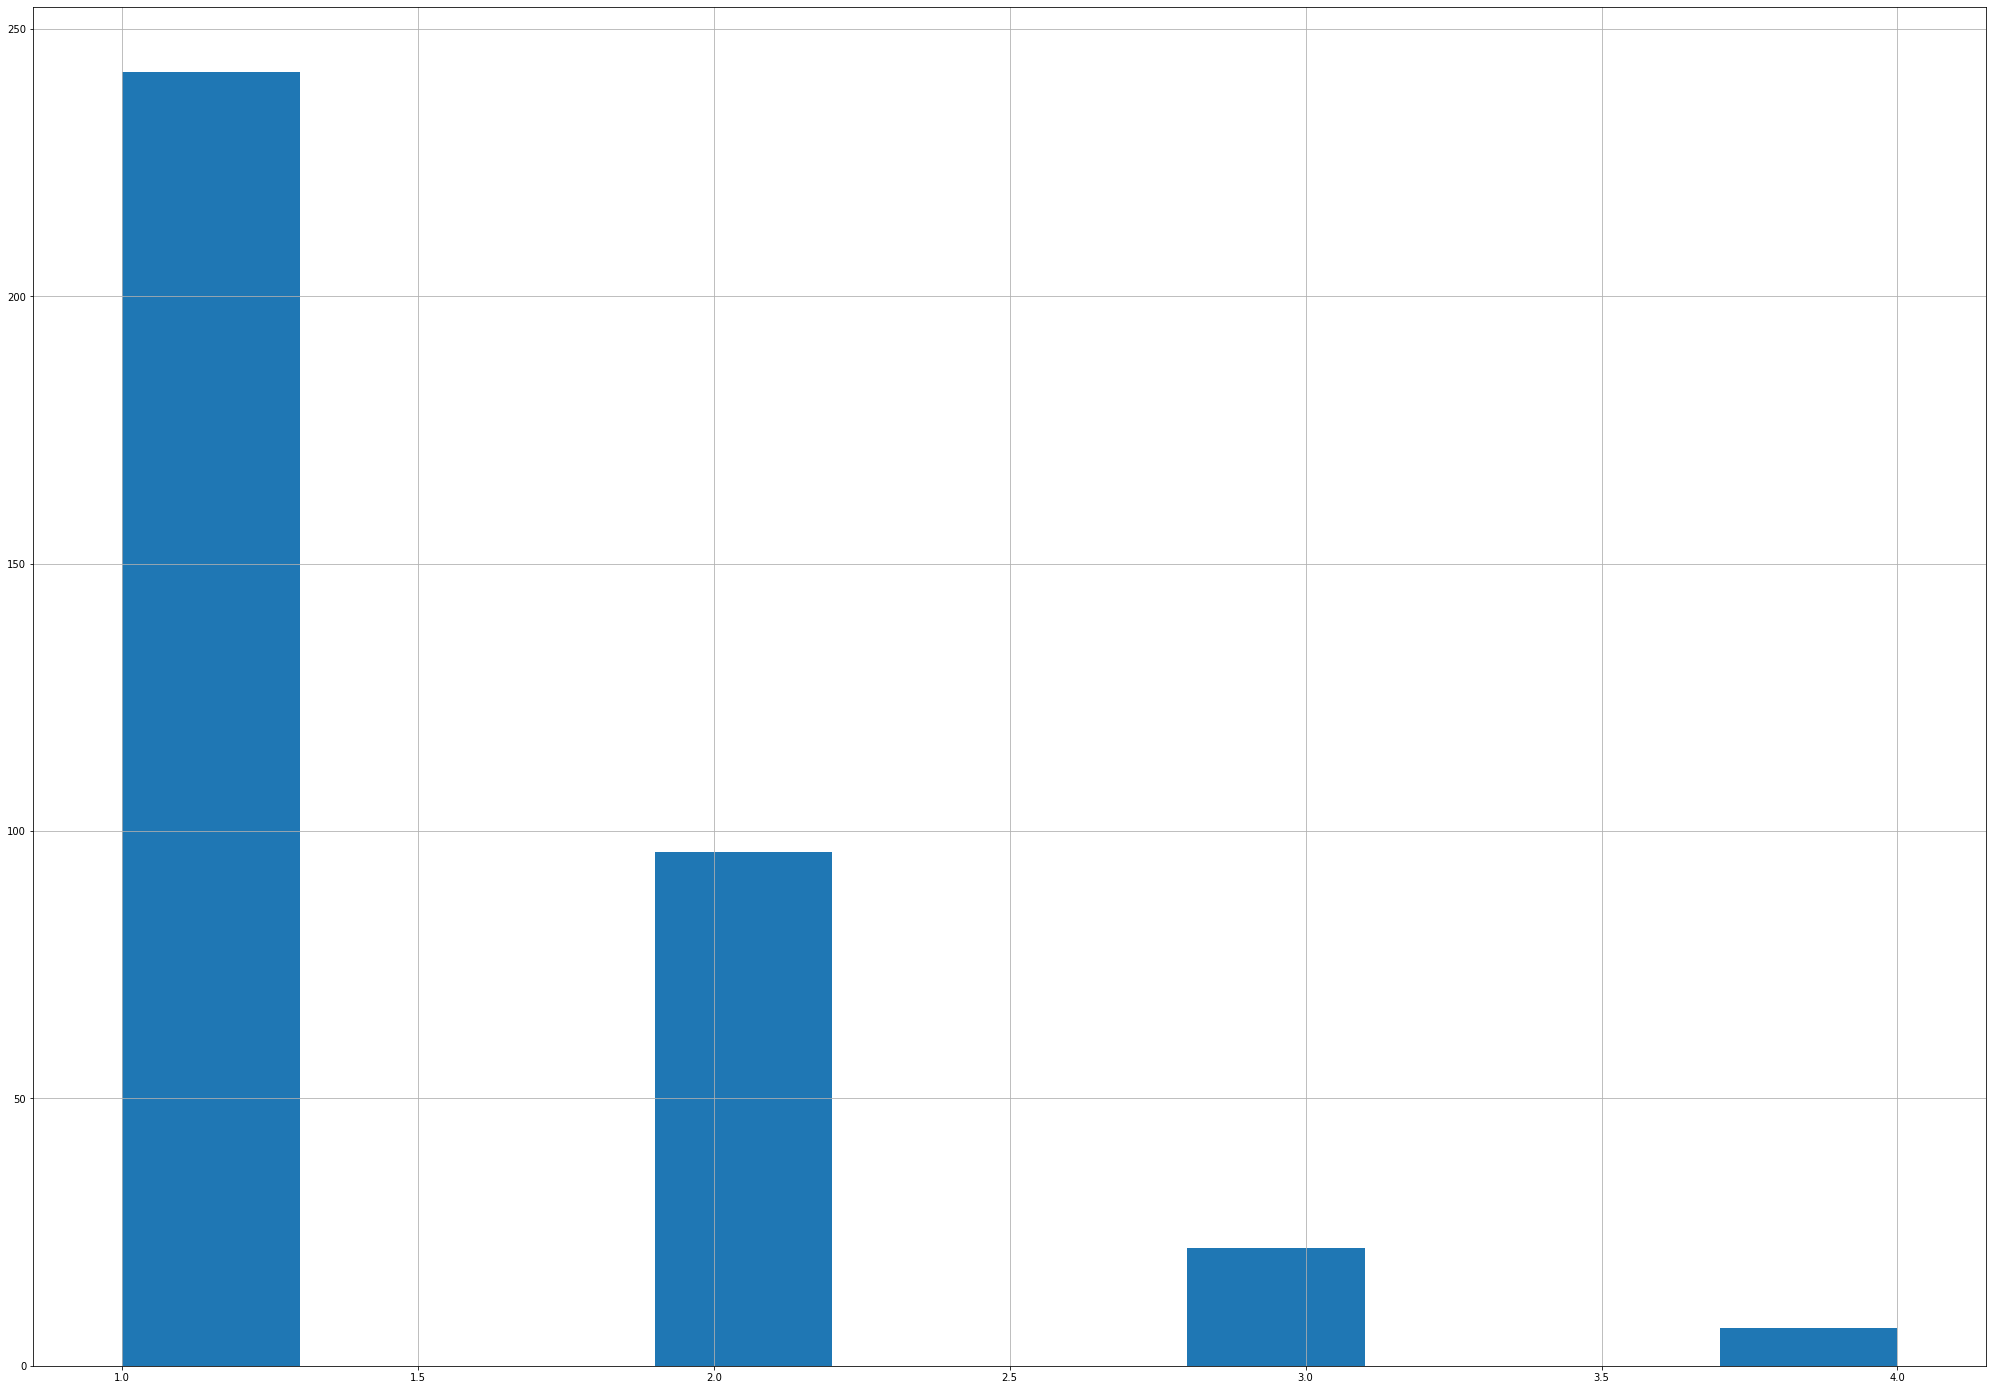

In [173]:
stud.traveltime.hist();
print(stud.traveltime.value_counts())
stud.traveltime.isnull().sum()

In [174]:
stud.groupby(['school', 'traveltime']).traveltime.count()

school  traveltime
GP      1.0           229
        2.0            76
        3.0            14
        4.0             6
MS      1.0            13
        2.0            20
        3.0             8
        4.0             1
Name: traveltime, dtype: int64

In [175]:
stud.groupby(['address', 'traveltime']).traveltime.count()

address  traveltime
R        1.0            34
         2.0            26
         3.0            12
         4.0             4
U        1.0           208
         2.0            70
         3.0            10
         4.0             3
Name: traveltime, dtype: int64

In [176]:
stud.groupby(['school', 'address', 'traveltime']).traveltime.count()

school  address  traveltime
GP      R        1.0            29
                 2.0            18
                 3.0             5
                 4.0             3
        U        1.0           200
                 2.0            58
                 3.0             9
                 4.0             3
MS      R        1.0             5
                 2.0             8
                 3.0             7
                 4.0             1
        U        1.0             8
                 2.0            12
                 3.0             1
Name: traveltime, dtype: int64

In [177]:
traveltime_null_GP_idx = stud.loc[(stud.traveltime.isnull()) & (stud.school == 'GP')].index
stud.loc[traveltime_null_GP_idx, 'traveltime'] = 1.0

traveltime_null_MS_idx = stud.loc[(stud.traveltime.isnull()) & (stud.school == 'MS')].index
stud.loc[traveltime_null_MS_idx, 'traveltime'] = 2.0

# Проверка после замены
stud.traveltime.isnull().sum()

0

##### Выводы по колонке traveltime
- Исходя из распределений:
    - Если школа = 'GP', пропуск заполняем значением = 1.0
    - Если школа = 'MS', пропуск заполняем значением = 2.0

#### 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64


7

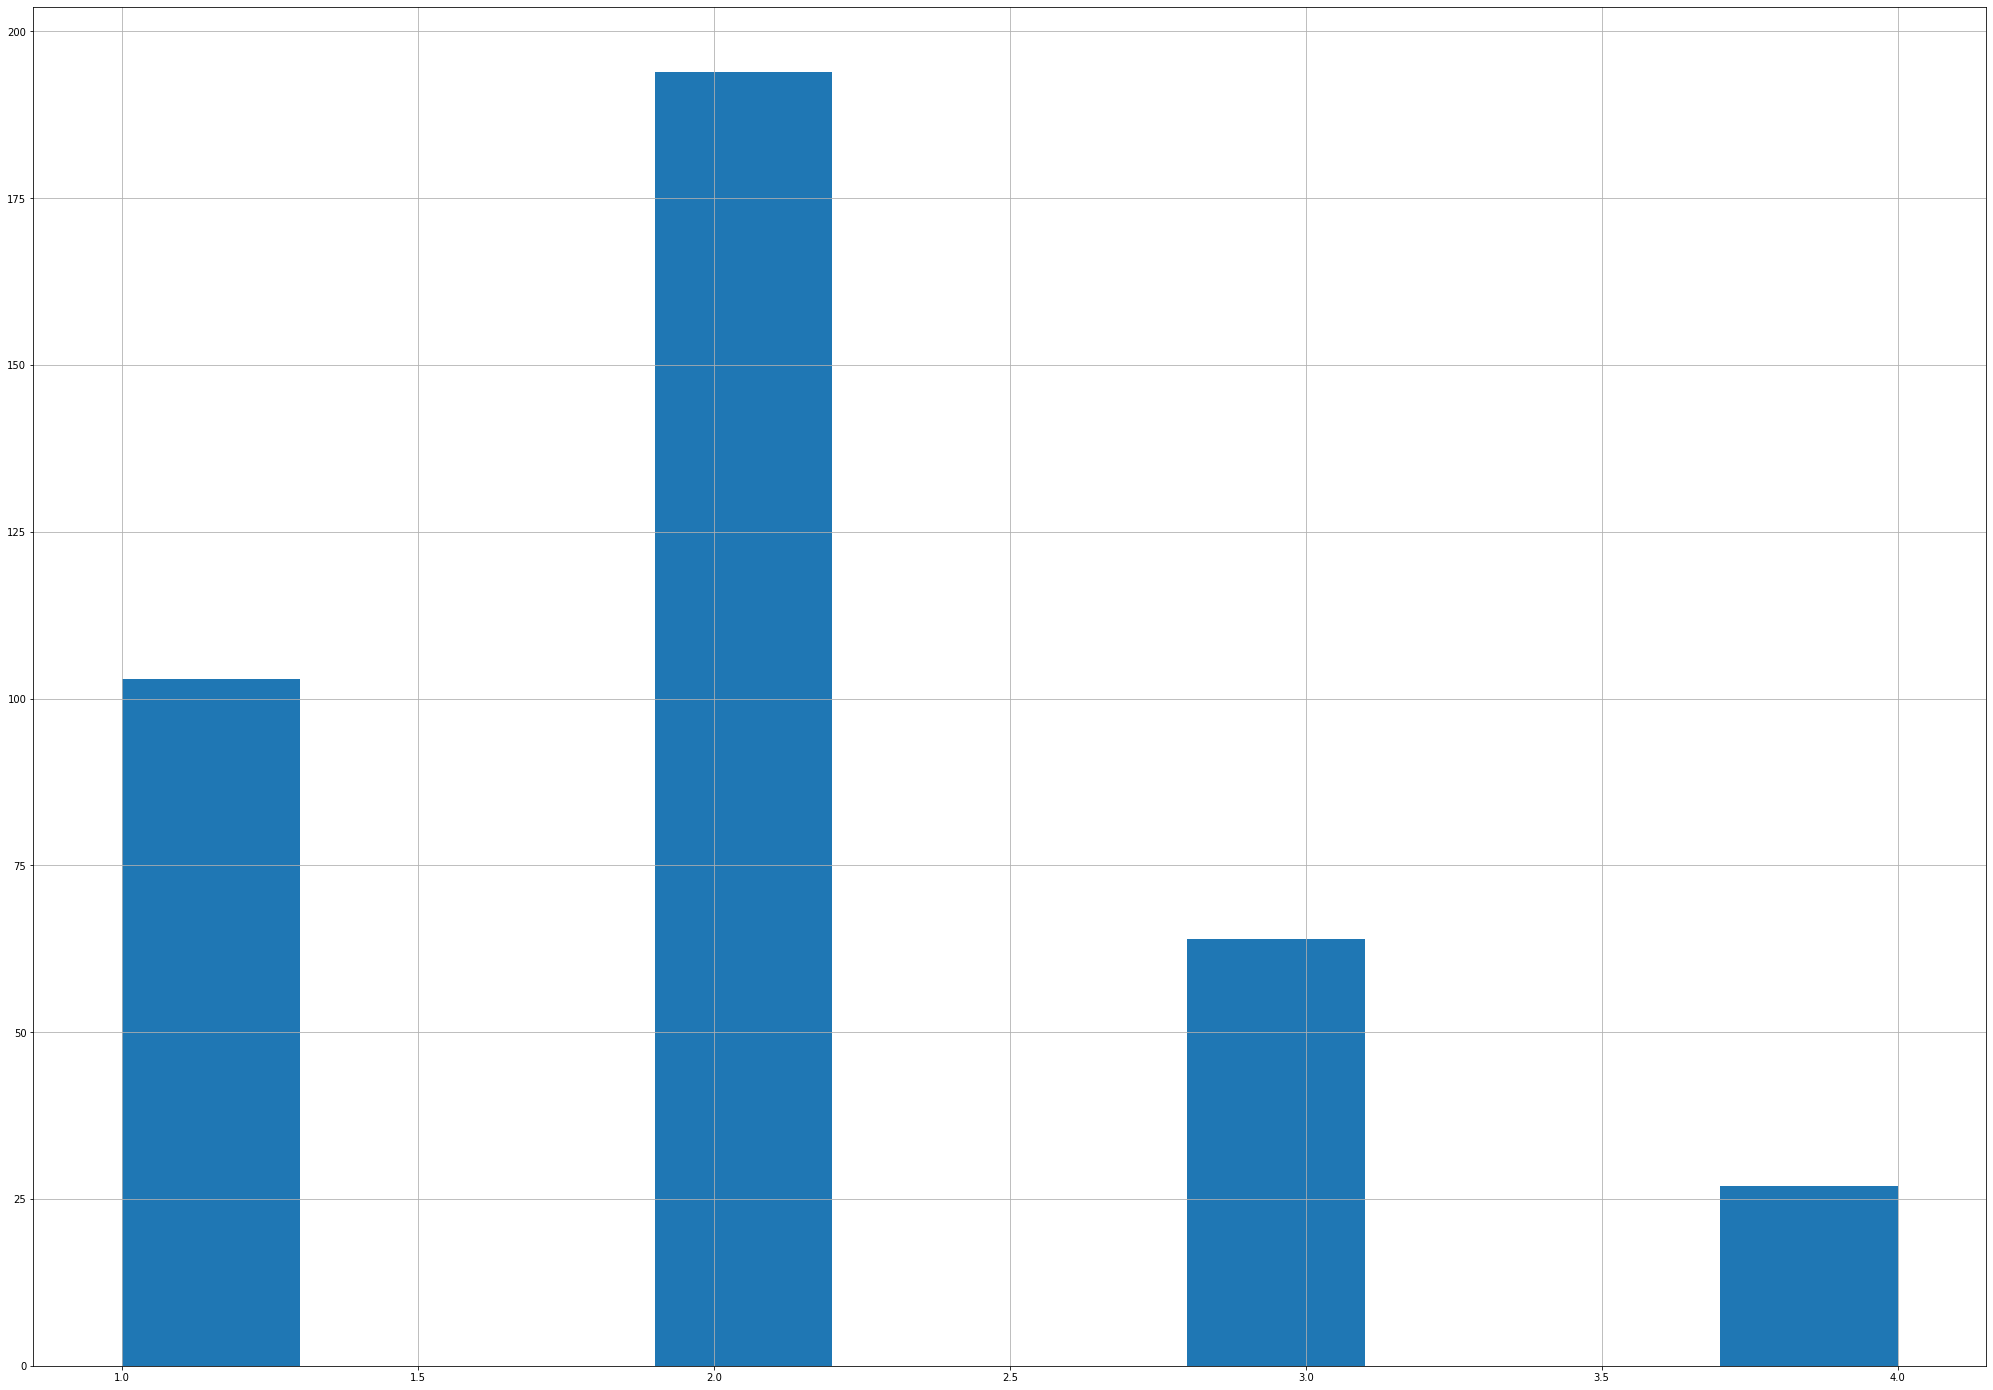

In [178]:
stud.studytime.hist();
print(stud.studytime.value_counts())
stud.studytime.isnull().sum()

In [179]:
studytime_null_idx = stud.loc[(stud.studytime.isnull())].index
stud.loc[studytime_null_idx, 'studytime'] = 2.0

# Проверка после замены
stud.studytime.isnull().sum()

0

##### Выводы по колонке studytime
- Все малочисленные пропуски заменяем на "среднее" значение = 2

#### 15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)

0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64


22

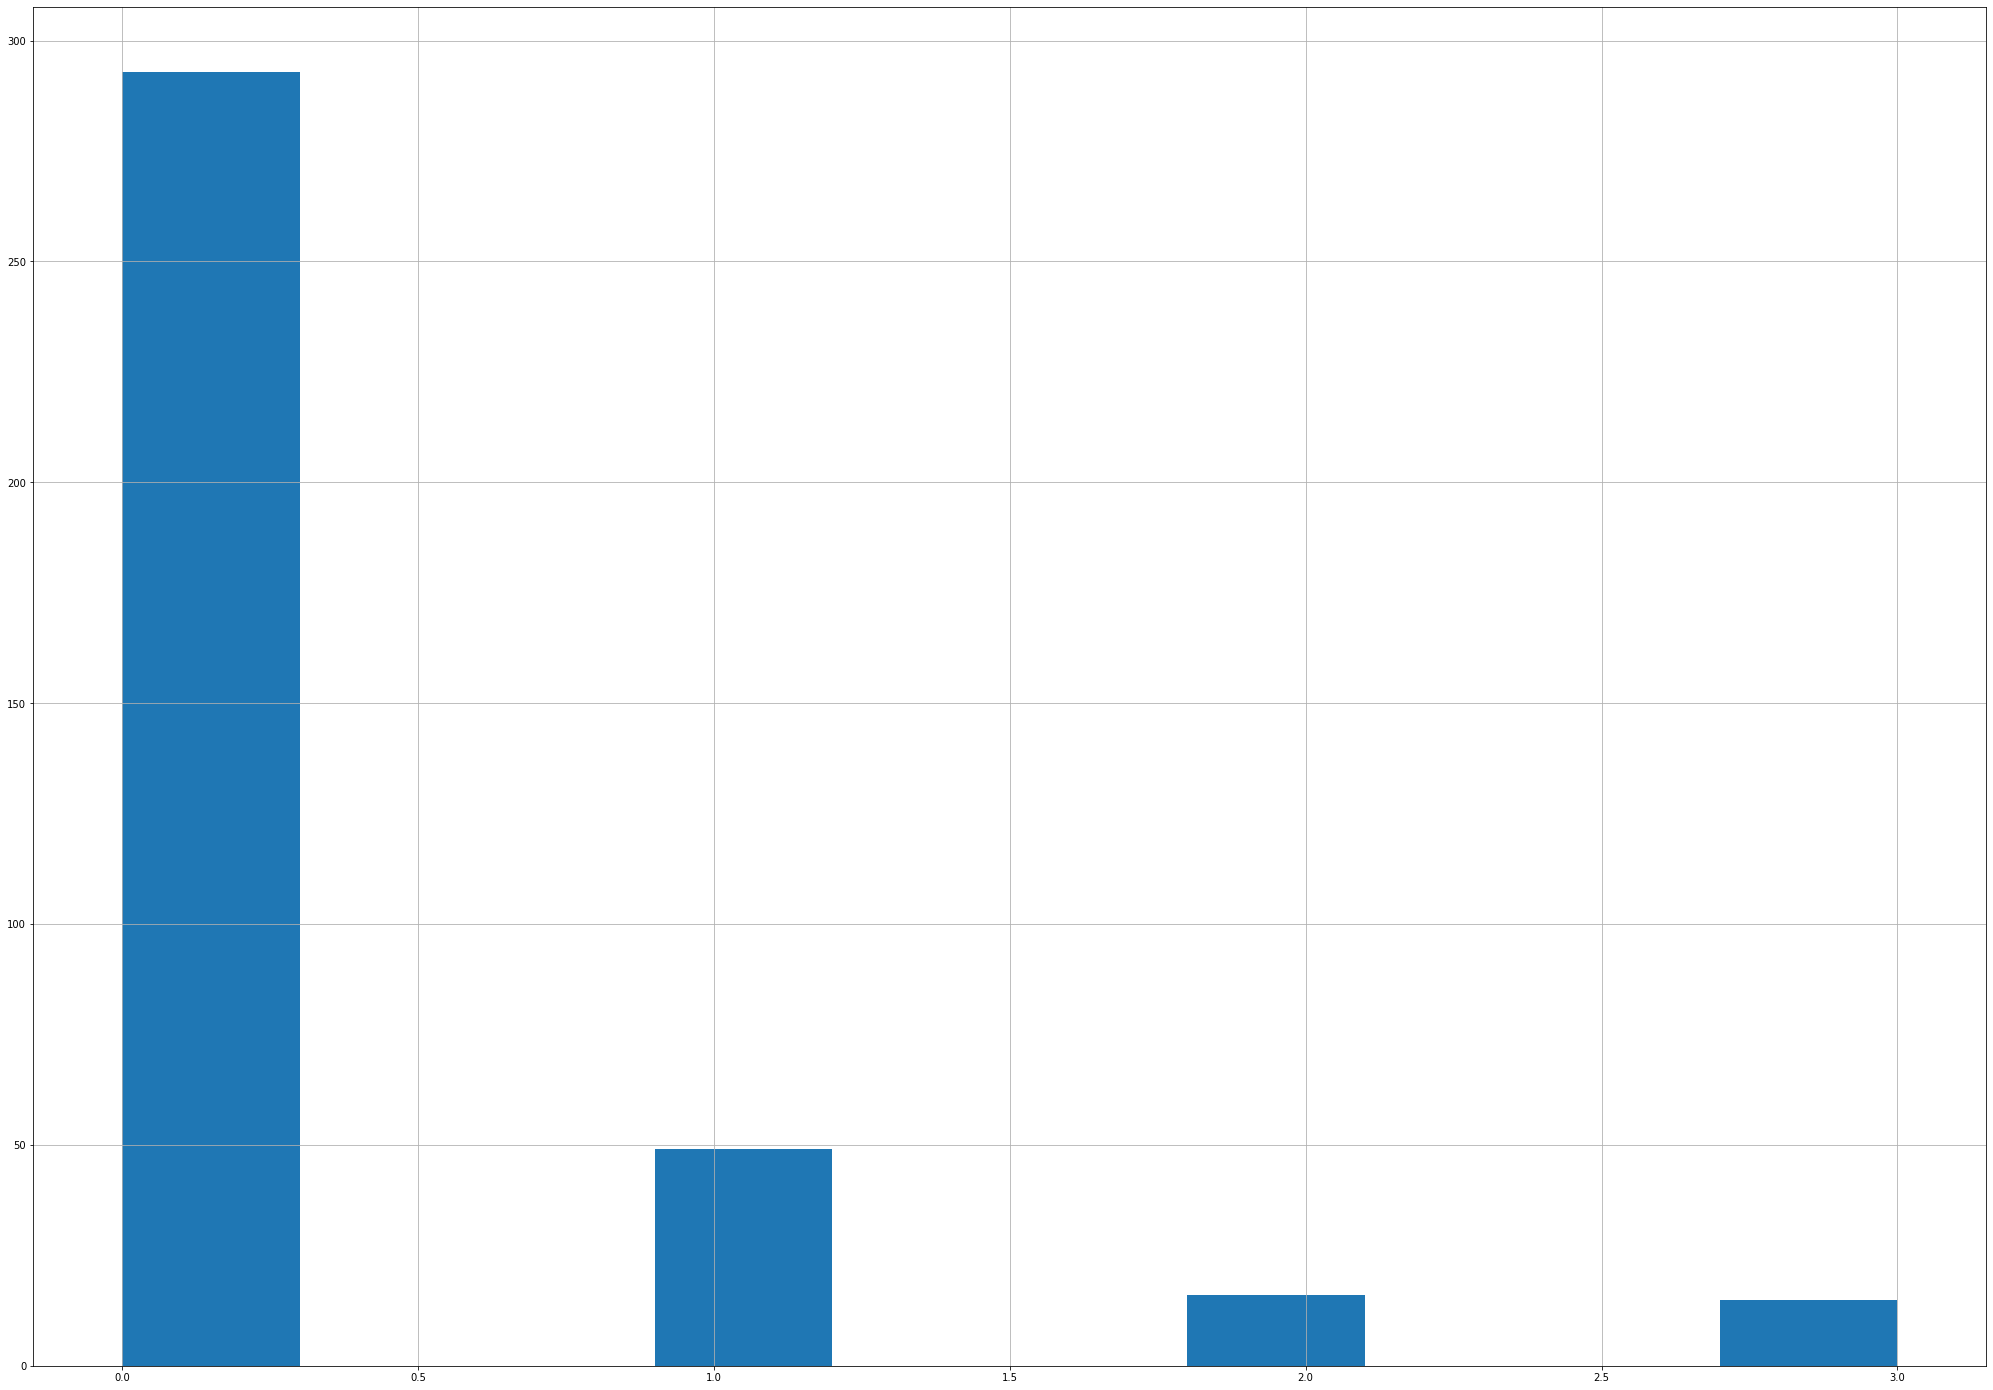

In [180]:
stud.failures.hist();
print(stud.failures.value_counts())
stud.failures.isnull().sum()

In [181]:
failures_null_idx = stud.loc[(stud.failures.isnull())].index
stud.loc[failures_null_idx, 'failures'] = 0.0

# Проверка после замены
stud.failures.isnull().sum()

0

##### Выводы по колонке failures
- С хорошим отрывом лидирует значение 0. Правда исходя из формулировки признака это может означать как собственно 0 неудач, так и более 3-х неудач. Все пропуски заполнены значением 0.

#### schoolsup — дополнительная образовательная поддержка (yes или no)

no     335
yes     51
Name: schoolsup, dtype: int64


9

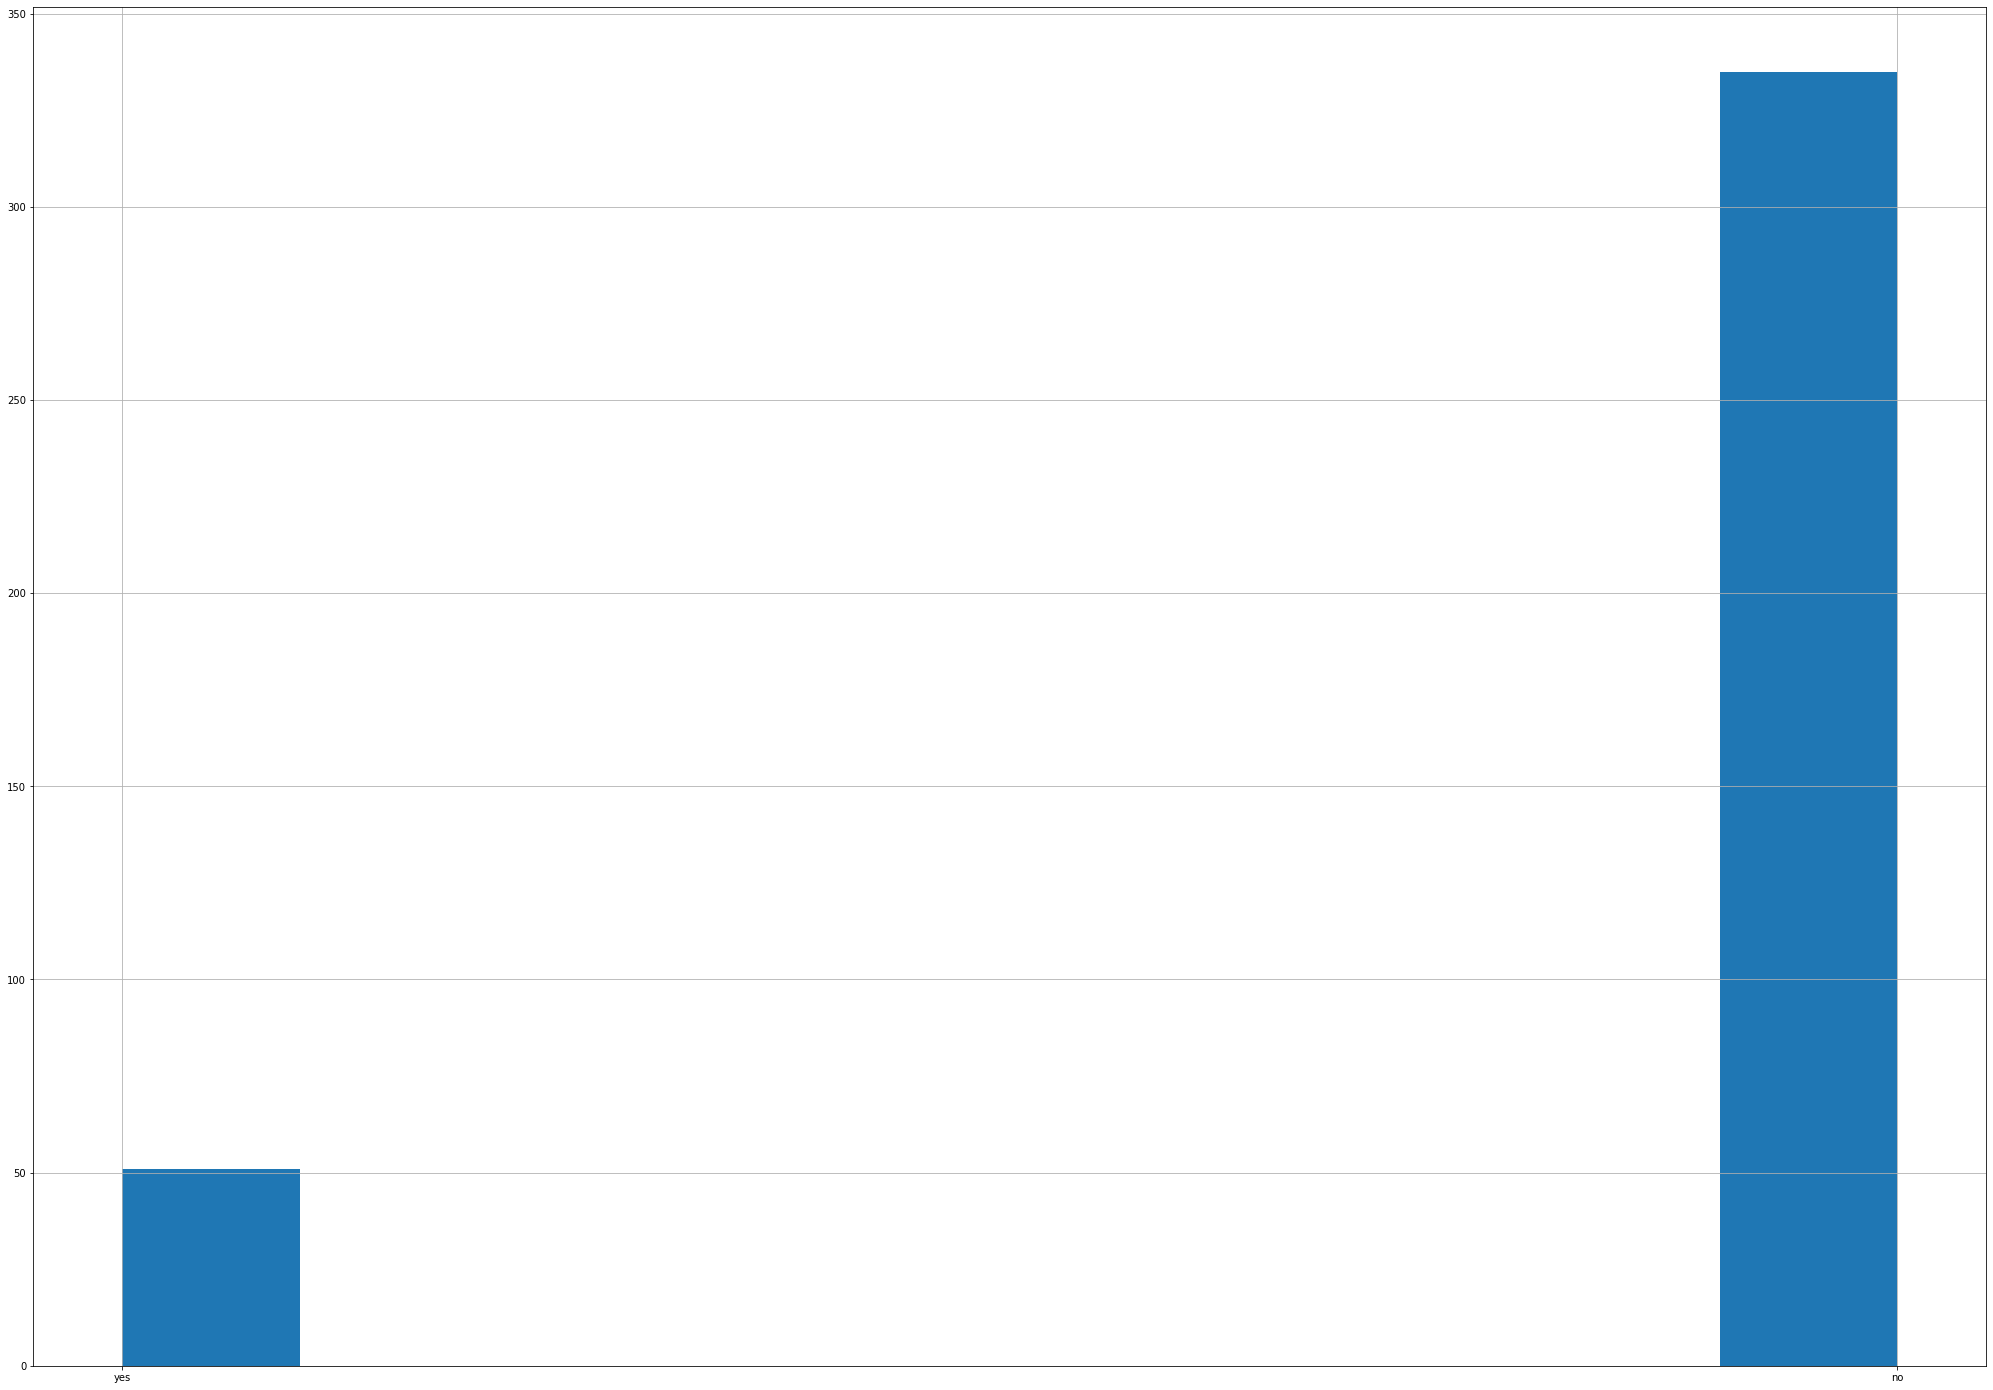

In [182]:
stud.schoolsup.hist();
print(stud.schoolsup.value_counts())
stud.schoolsup.isnull().sum()

In [183]:
schoolsup_null_idx = stud.loc[(stud.schoolsup.isnull())].index
stud.loc[schoolsup_null_idx, 'schoolsup'] = 'no'

# Проверка после замены
stud.schoolsup.isnull().sum()

0

##### Выводы по колонке schoolsup
- Исходя из вида распределения, все пропуски заменены на значение = 'no', как максимально представленное

#### famsup — семейная образовательная поддержка (yes или no)

yes    219
no     137
Name: famsup, dtype: int64


39

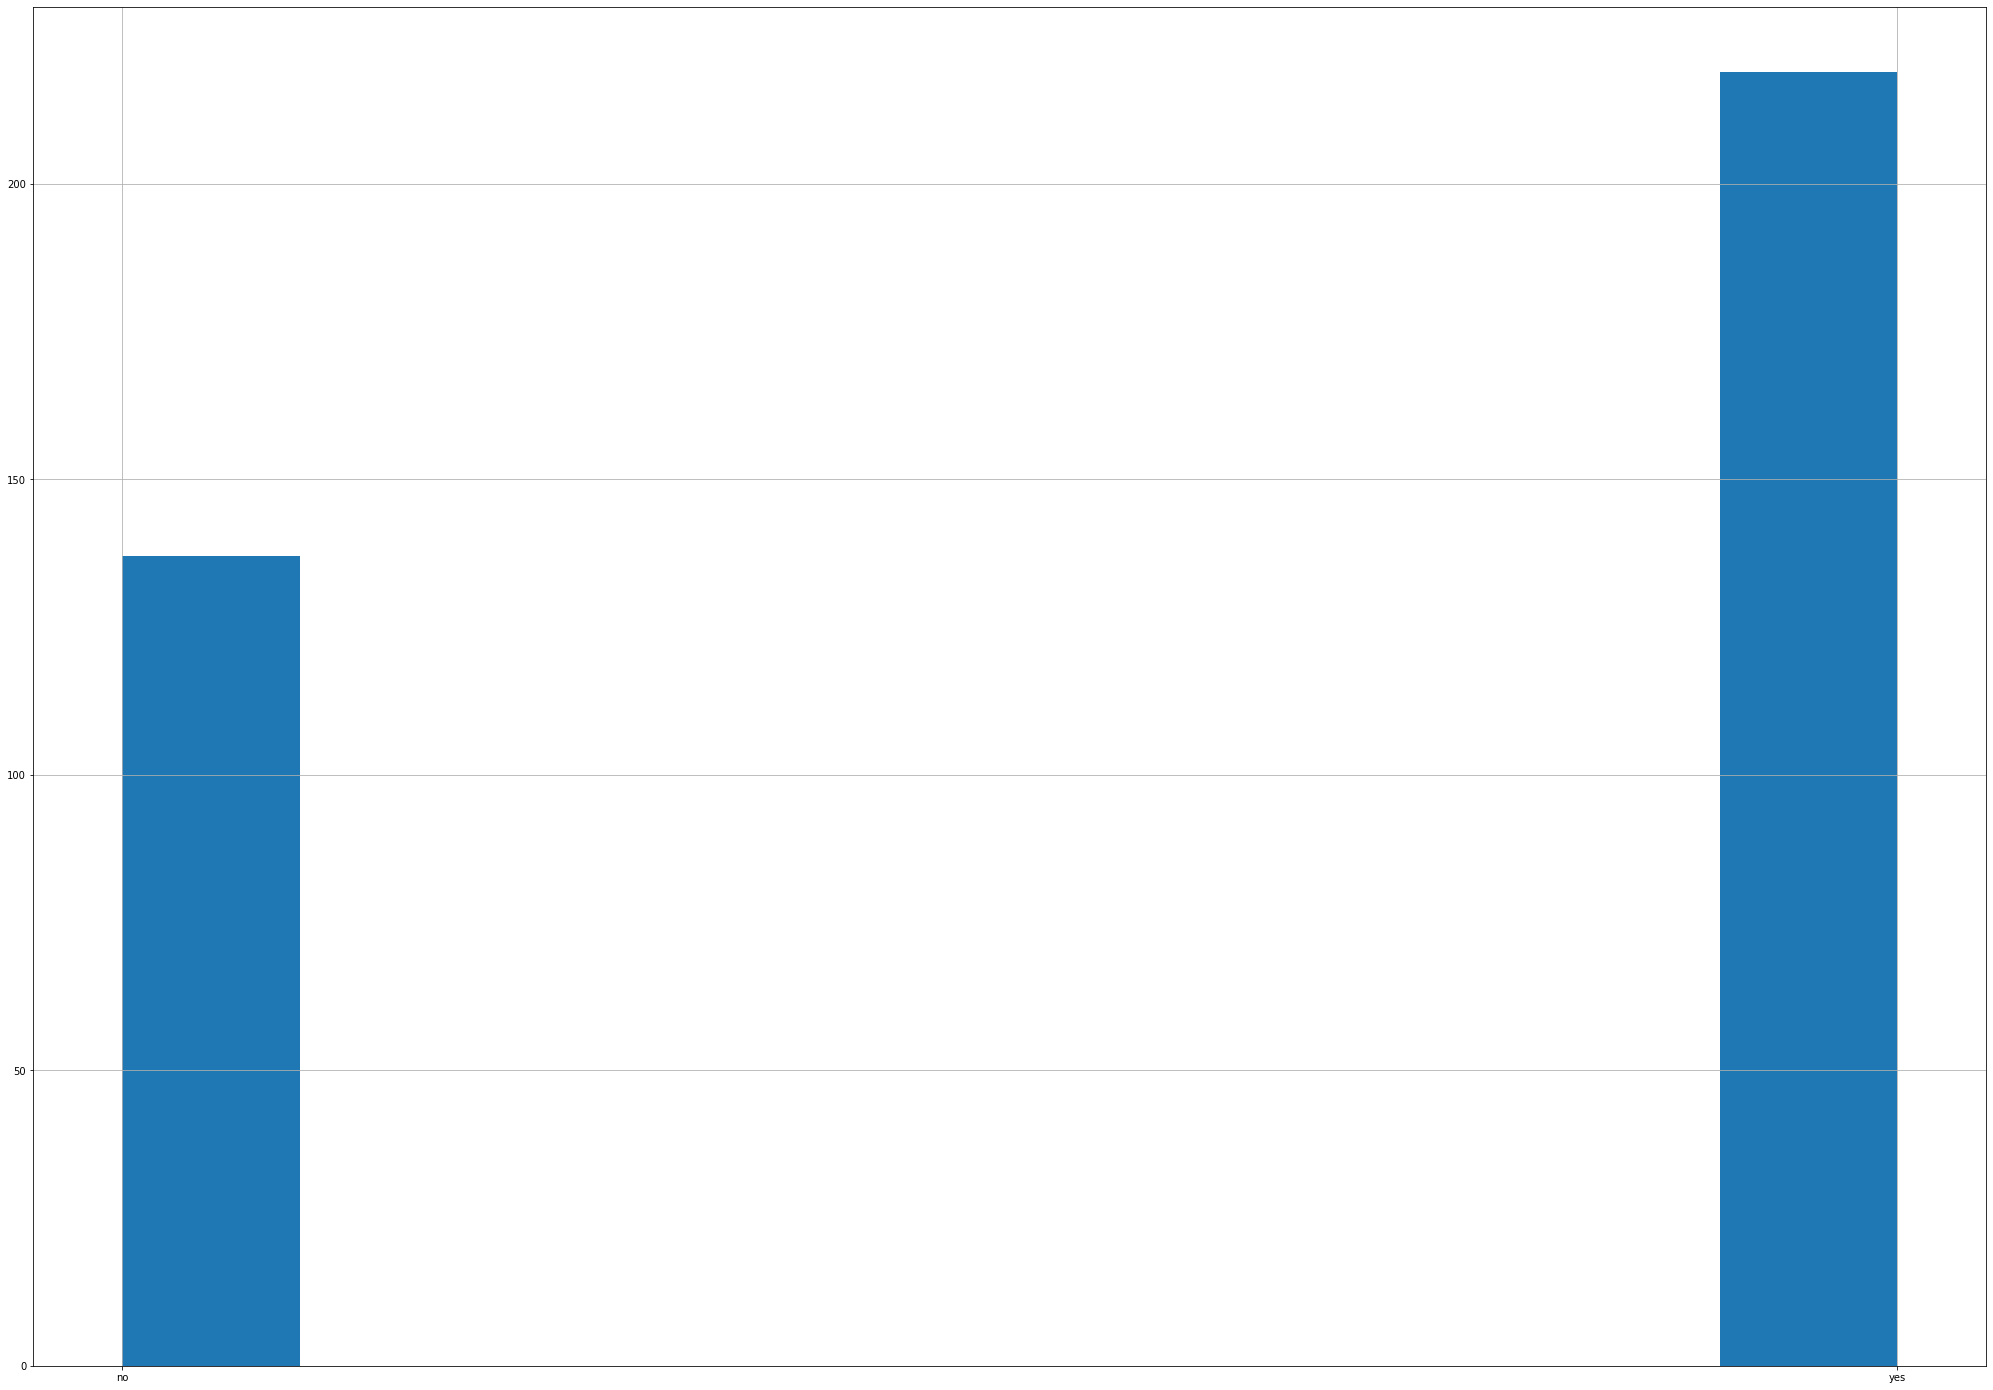

In [184]:
stud.famsup.hist();
print(stud.famsup.value_counts())
stud.famsup.isnull().sum()

Разница в кол-ве не очень существенная, поэтому посмотрим связь с колонкой school

In [185]:
stud.groupby(['school', 'famsup']).famsup.count()

school  famsup
GP      no        109
        yes       202
MS      no         28
        yes        17
Name: famsup, dtype: int64

In [186]:
famsup_null_GP_idx = stud.loc[(stud.famsup.isnull()) & (stud.school == 'GP')].index
stud.loc[famsup_null_GP_idx, 'famsup'] = 'yes'

famsup_null_MS_idx = stud.loc[(stud.famsup.isnull()) & (stud.school == 'MS')].index
stud.loc[famsup_null_MS_idx, 'famsup'] = 'no'

# Проверка после замены
stud.famsup.isnull().sum()

0

##### Выводы по колонке famsup
- Исходя из распределения:
    - Если школа = 'GP', пропуск заполняем значением = 'yes'
    - Если школа = 'MS', пропуск заполняем значением = 'no'

#### 18 paid — дополнительные платные занятия по математике (yes или no)

no     200
yes    155
Name: paid, dtype: int64


40

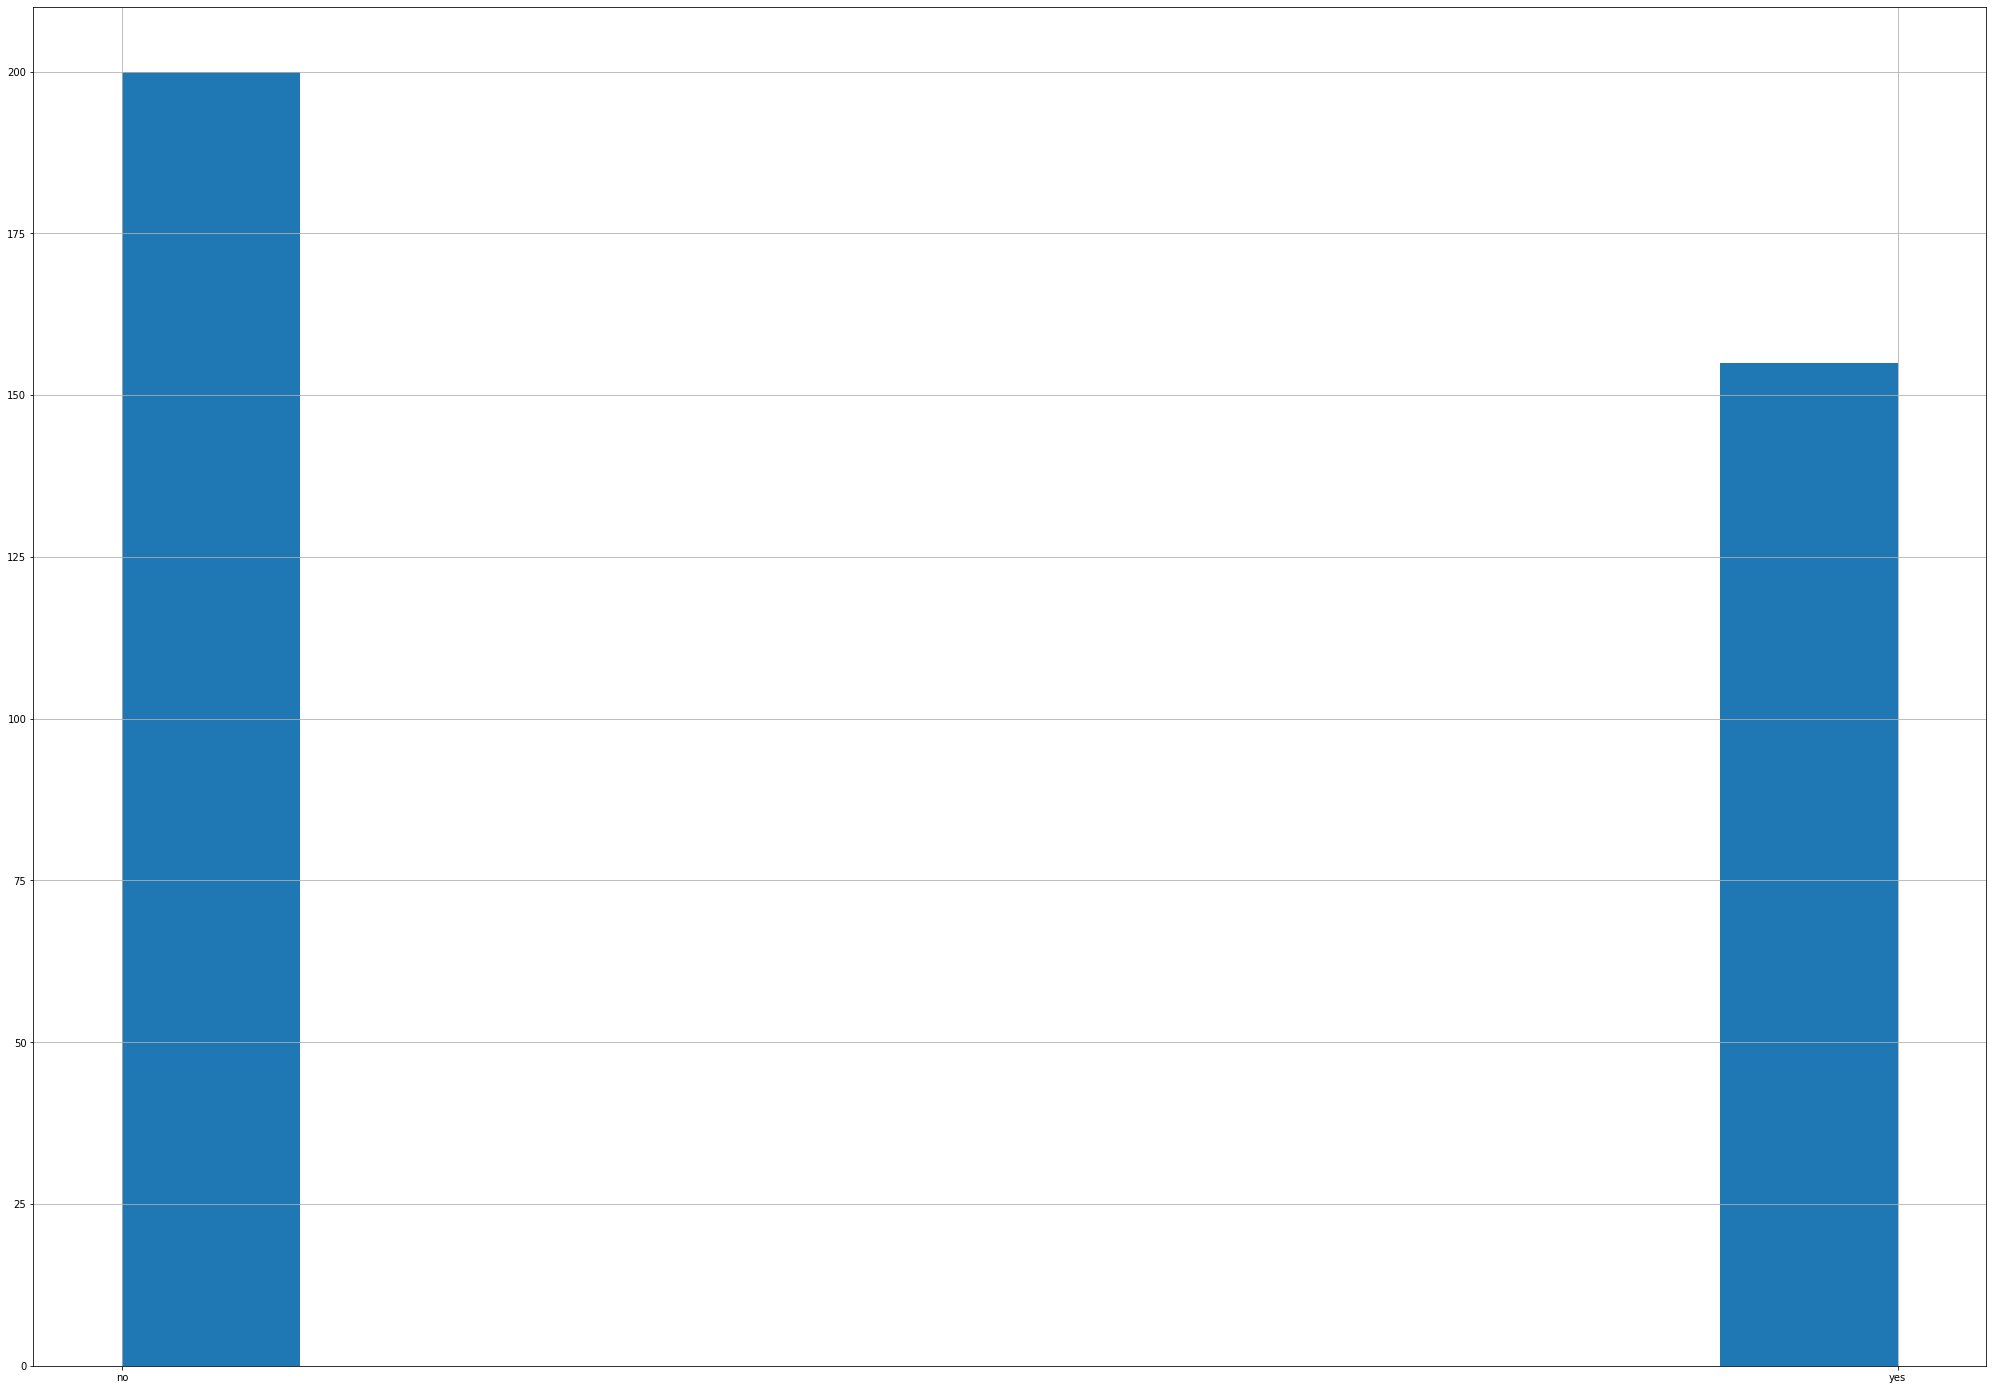

In [187]:
stud.paid.hist();
print(stud.paid.value_counts())
stud.paid.isnull().sum()

Разница в кол-ве не очень существенная, поэтому посмотрим связь с колонкой school

In [188]:
stud.groupby(['school', 'paid']).paid.count()

school  paid
GP      no      174
        yes     138
MS      no       26
        yes      17
Name: paid, dtype: int64

От типа школы не зависит. А от пола?

In [189]:
stud.groupby(['sex', 'paid']).paid.count()

sex  paid
F    no       97
     yes      92
M    no      103
     yes      63
Name: paid, dtype: int64

Тоже не зависит. Осталось проверить связь с возрастом.

In [190]:
stud.groupby(['age', 'paid']).paid.count()

age  paid
15   no      41
     yes     31
16   no      52
     yes     43
17   no      48
     yes     37
18   no      40
     yes     36
19   no      16
     yes      6
20   no       1
     yes      2
21   no       1
22   no       1
Name: paid, dtype: int64

За исключением одного случая, где превышение "yes" над "no" мала, во всех остальных случаях значение "no" выделяется. На него и заменим пропуски.

In [191]:
paid_null_idx = stud.loc[(stud.paid.isnull())].index
stud.loc[paid_null_idx, 'paid'] = 'no'

# Проверка после замены
stud.paid.isnull().sum()

0

##### Выводы по колонке paid
- Исходя из вида распределений, все пропуски заменены на значение = 'no', как максимально представленное

#### 19 activities — дополнительные внеучебные занятия (yes или no)

yes    195
no     186
Name: activities, dtype: int64


14

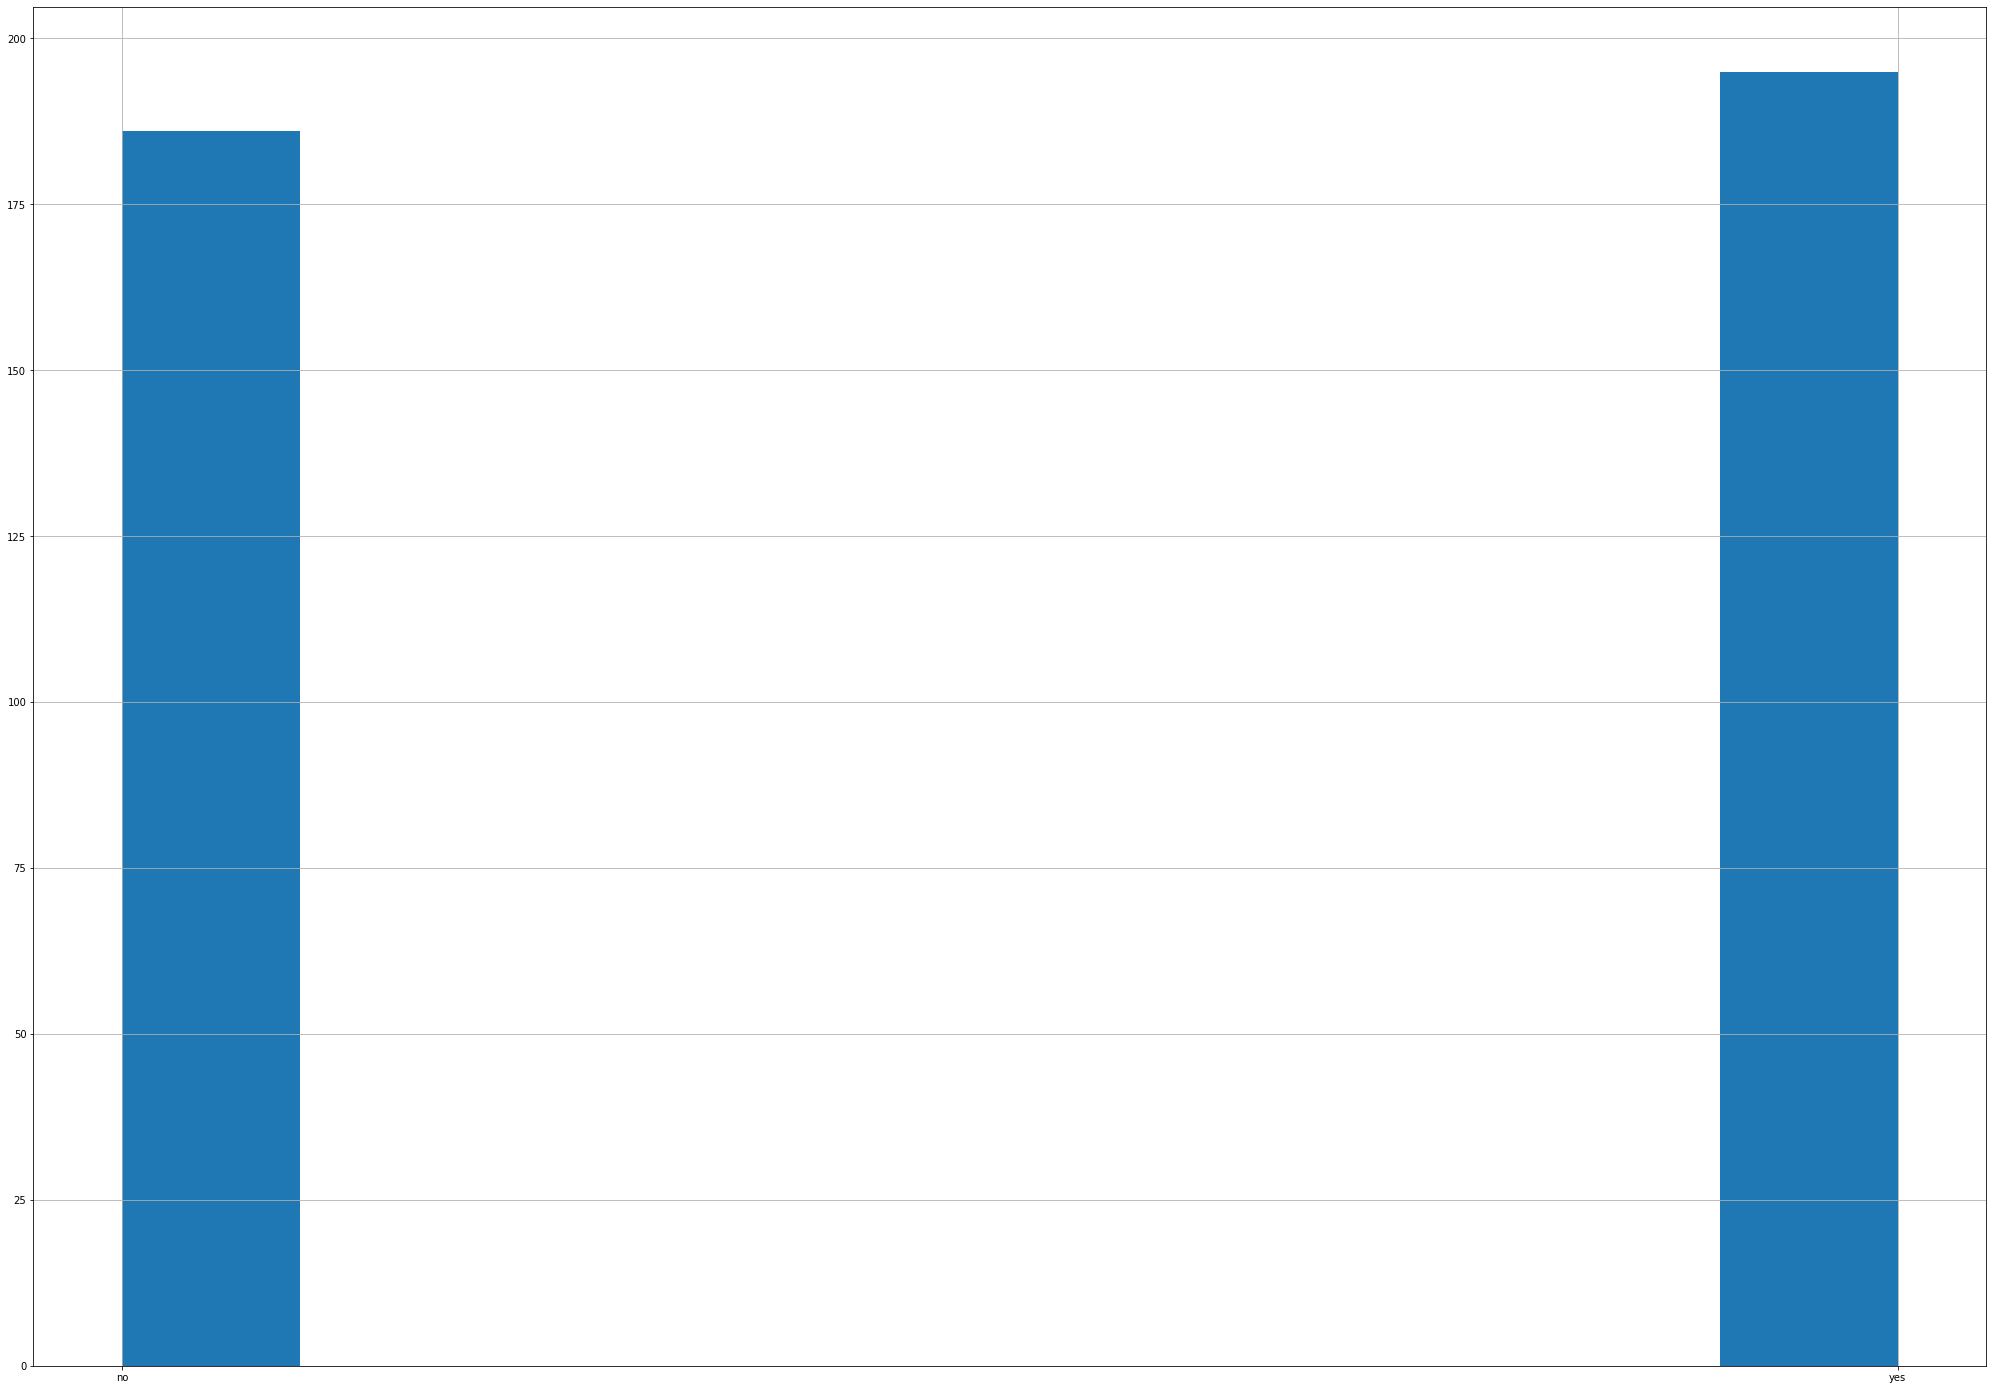

In [192]:
stud.activities.hist();
print(stud.activities.value_counts())
stud.activities.isnull().sum()

Начинаем сравнение с первыми тремя колонками

In [193]:
stud.groupby(['school', 'activities']).activities.count()

school  activities
GP      no            157
        yes           179
MS      no             29
        yes            16
Name: activities, dtype: int64

In [194]:
stud.groupby(['sex', 'activities']).activities.count()

sex  activities
F    no            109
     yes            93
M    no             77
     yes           102
Name: activities, dtype: int64

In [195]:
stud.groupby(['age', 'activities']).activities.count()

age  activities
15   no            35
     yes           41
16   no            40
     yes           59
17   no            50
     yes           46
18   no            43
     yes           38
19   no            14
     yes           10
20   no             2
     yes            1
21   no             1
22   no             1
Name: activities, dtype: int64

In [196]:
activities_null_le17_idx = stud.loc[(stud.activities.isnull()) & (stud.age < 17)].index
stud.loc[activities_null_le17_idx, 'activities'] = 'yes'

activities_null_gteq17_idx = stud.loc[(stud.activities.isnull()) & (stud.age >= 17)].index
stud.loc[activities_null_gteq17_idx, 'activities'] = 'no'

# Проверка после замены
stud.activities.isnull().sum()

0

##### Выводы по колонке activities
- При заполнении пропусков ориентируемся на зависимость от возраста:
    - (кол-во пропусков) < 17 - заполняем "yes"
    - (кол-во пропусков) >= 17 - "no"

#### 20 nursery — посещал детский сад (yes или no)

yes    300
no      79
Name: nursery, dtype: int64


16

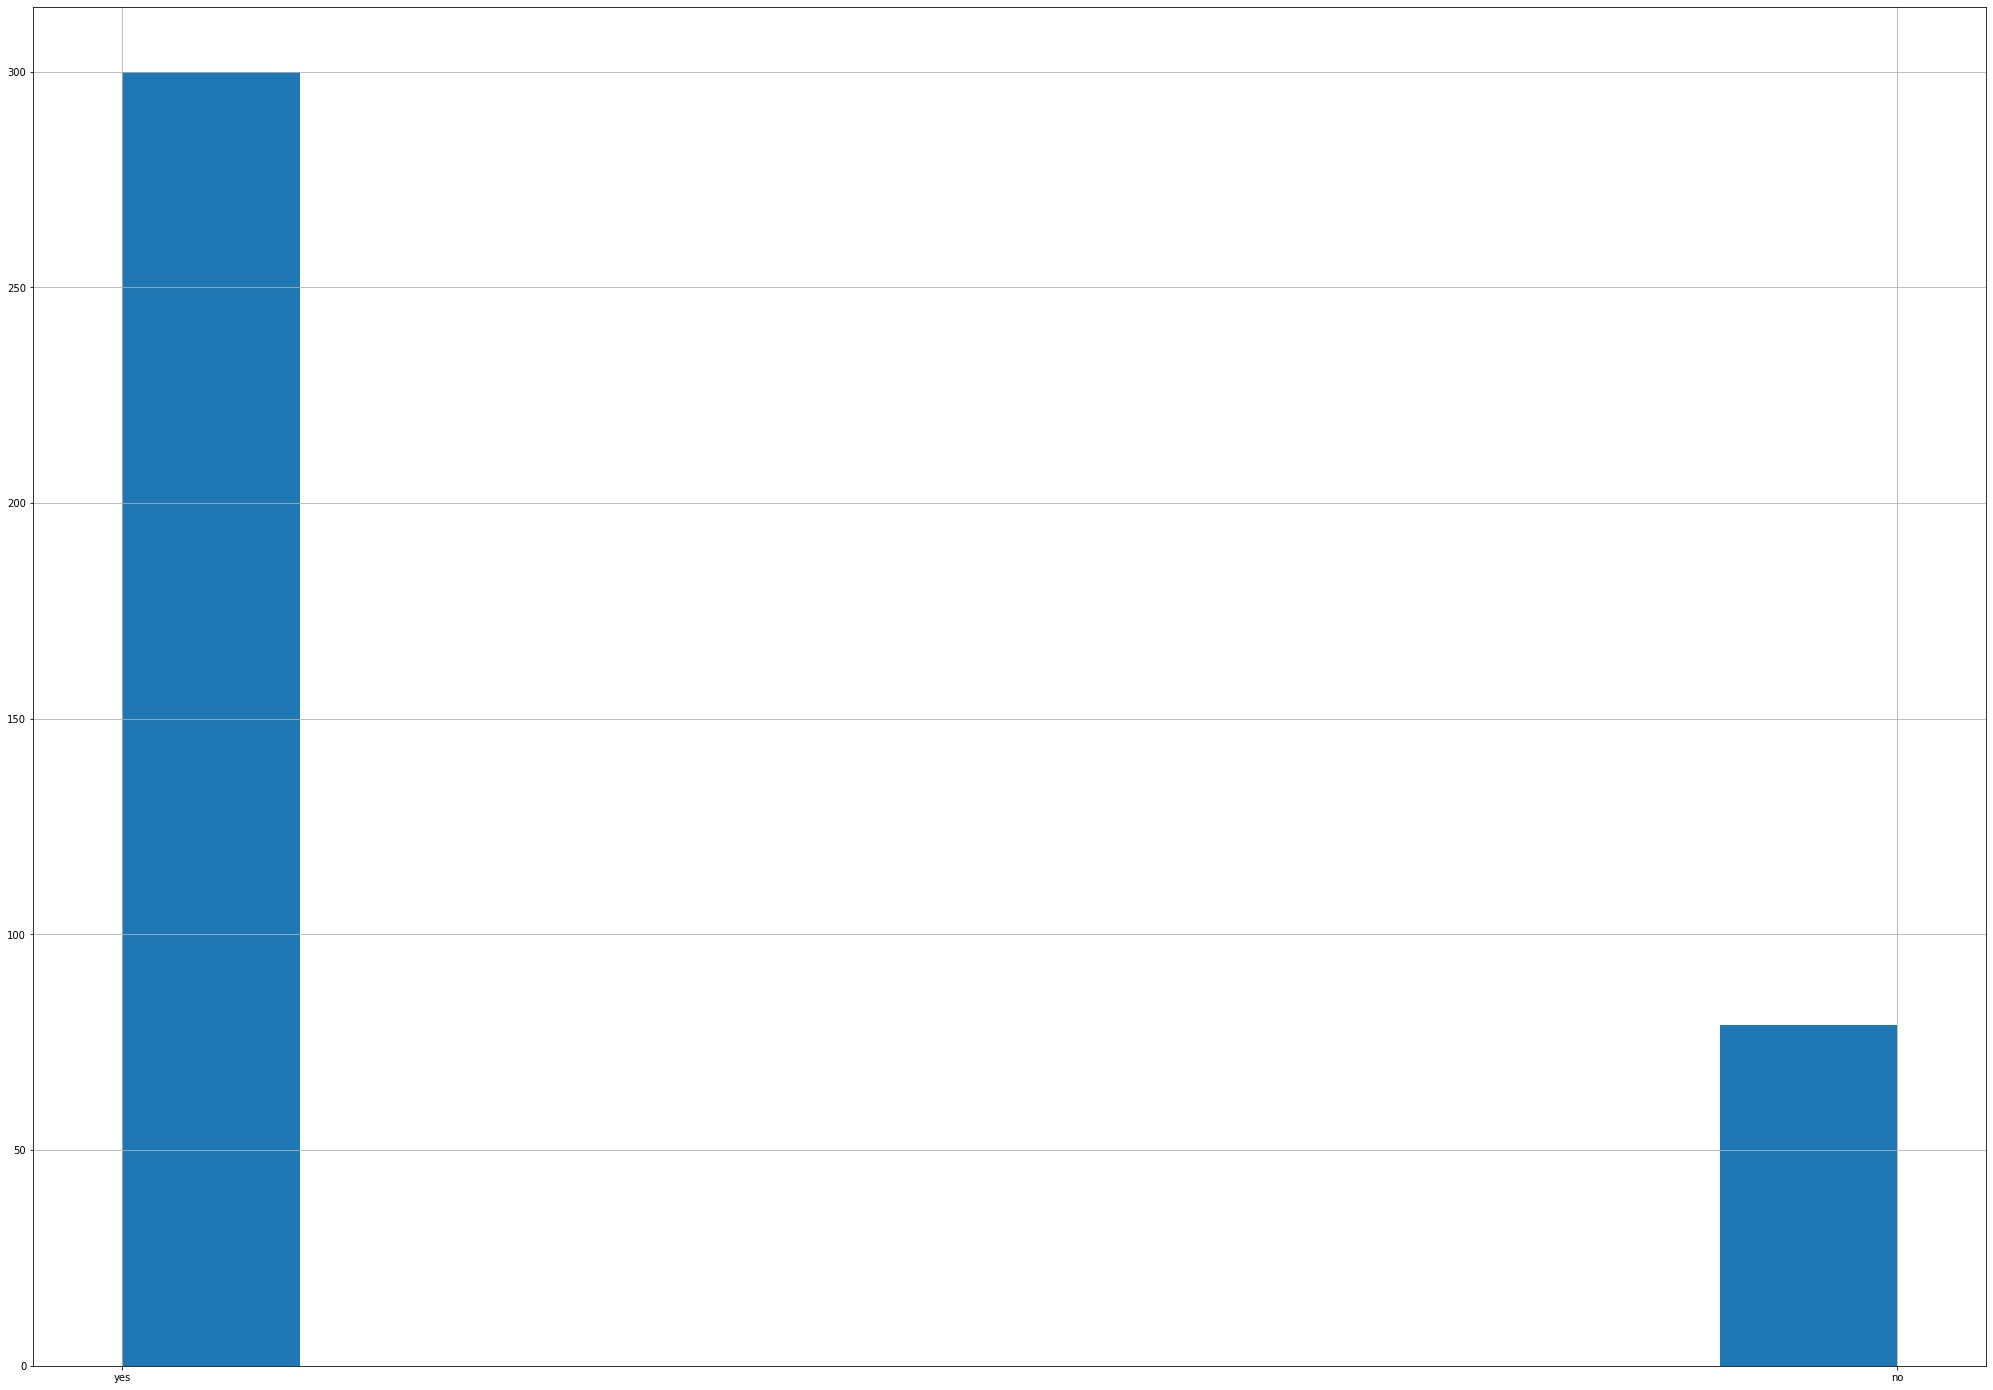

In [197]:
stud.nursery.hist();
print(stud.nursery.value_counts())
stud.nursery.isnull().sum()

In [198]:
nursery_null_idx = stud.loc[(stud.nursery.isnull())].index
stud.loc[nursery_null_idx, 'nursery'] = 'yes'

# Проверка после замены
stud.nursery.isnull().sum()

0

##### Выводы по колонке nursery
- Пропуски заполнены максимально представленным значением - "yes"

#### 21 higher — хочет получить высшее образование (yes или no)

yes    316
no      79
Name: nursery, dtype: int64


0

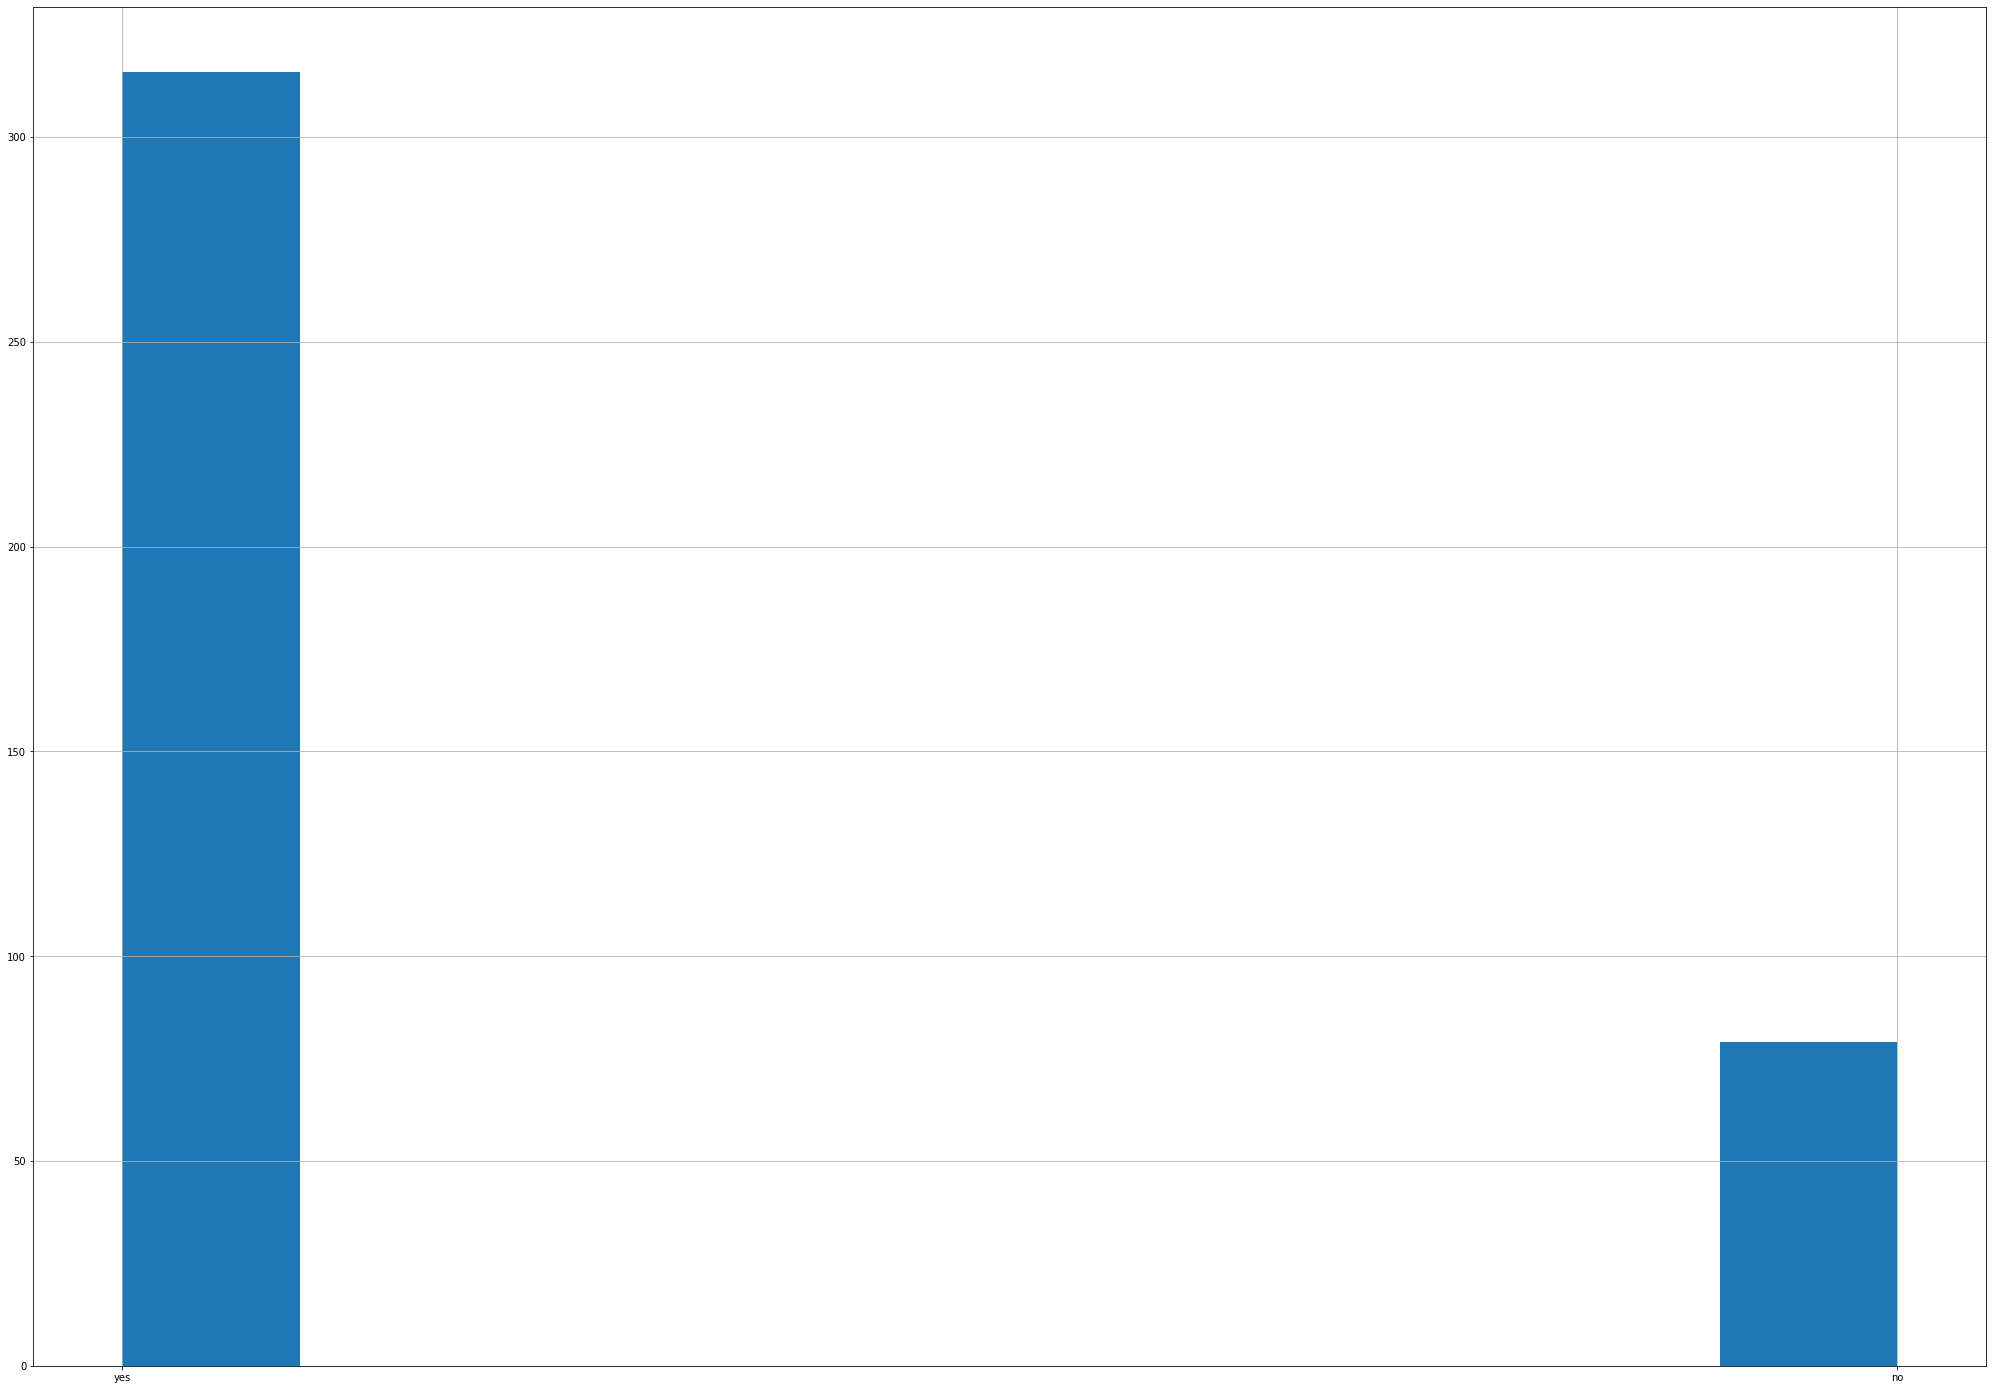

In [199]:
stud.nursery.hist();
print(stud.nursery.value_counts())
stud.nursery.isnull().sum()

In [200]:
higher_null_idx = stud.loc[(stud.higher.isnull())].index
stud.loc[higher_null_idx, 'higher'] = 'yes'

# Проверка после замены
stud.higher.isnull().sum()

0

##### Выводы по колонке higher
- Пропуски заполнены максимально представленным значением - "yes"

#### 22 internet — наличие интернета дома (yes или no)

yes    305
no      56
Name: internet, dtype: int64


34

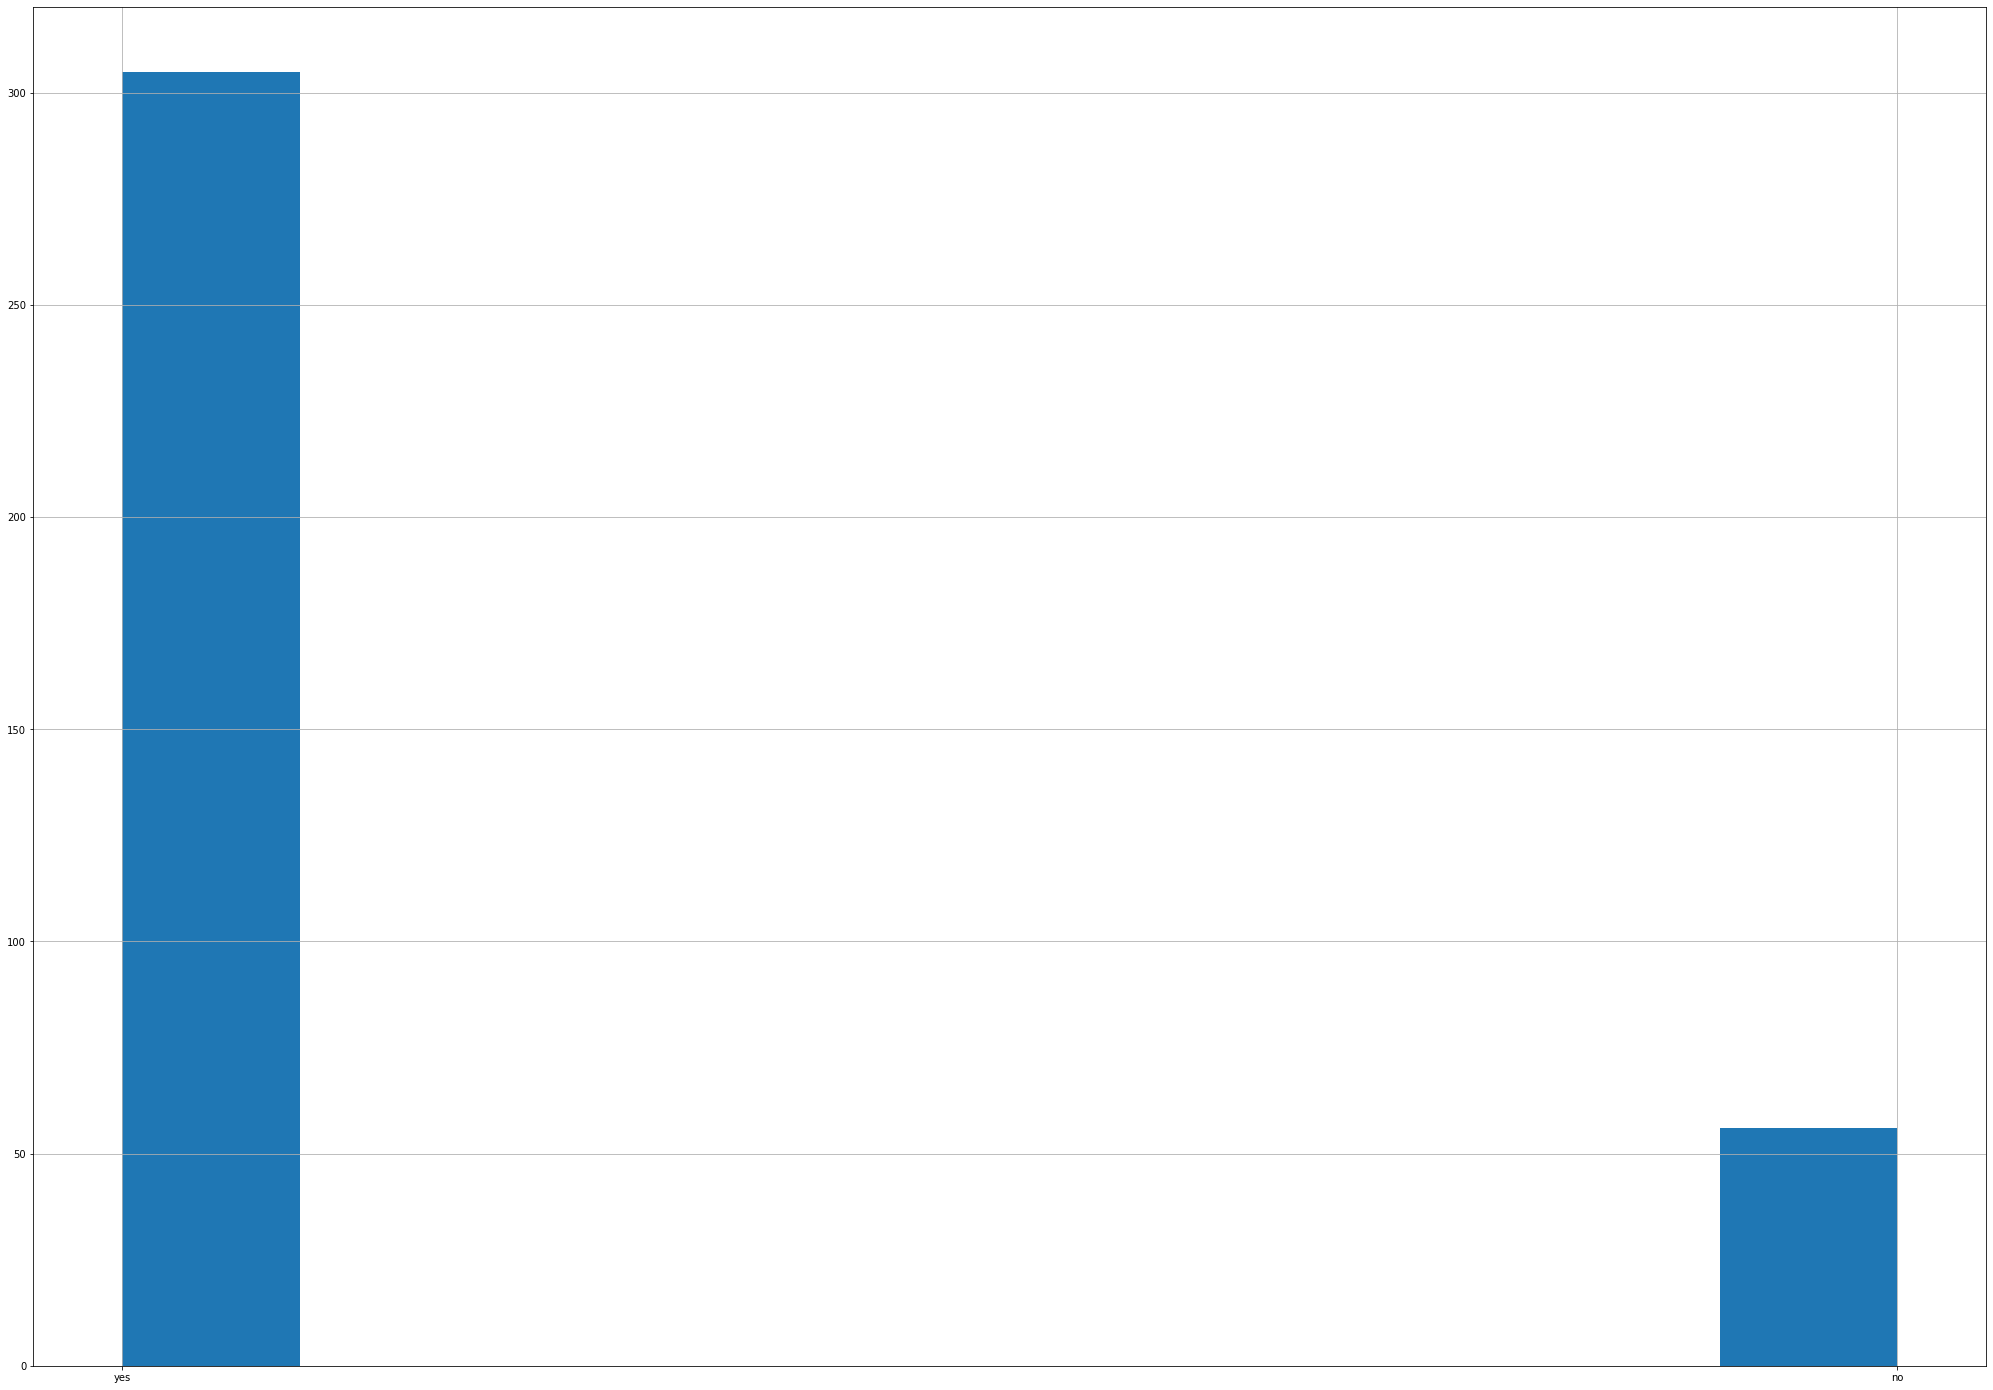

In [201]:
stud.internet.hist();
print(stud.internet.value_counts())
stud.internet.isnull().sum()

In [202]:
internet_null_idx = stud.loc[(stud.internet.isnull())].index
stud.loc[internet_null_idx, 'internet'] = 'yes'

# Проверка после замены
stud.internet.isnull().sum()

0

##### Выводы по колонке internet
- Пропуски заполнены максимально представленным значением - "yes"

#### 23 romantic — в романтических отношениях (yes или no)

no     240
yes    124
Name: romantic, dtype: int64


31

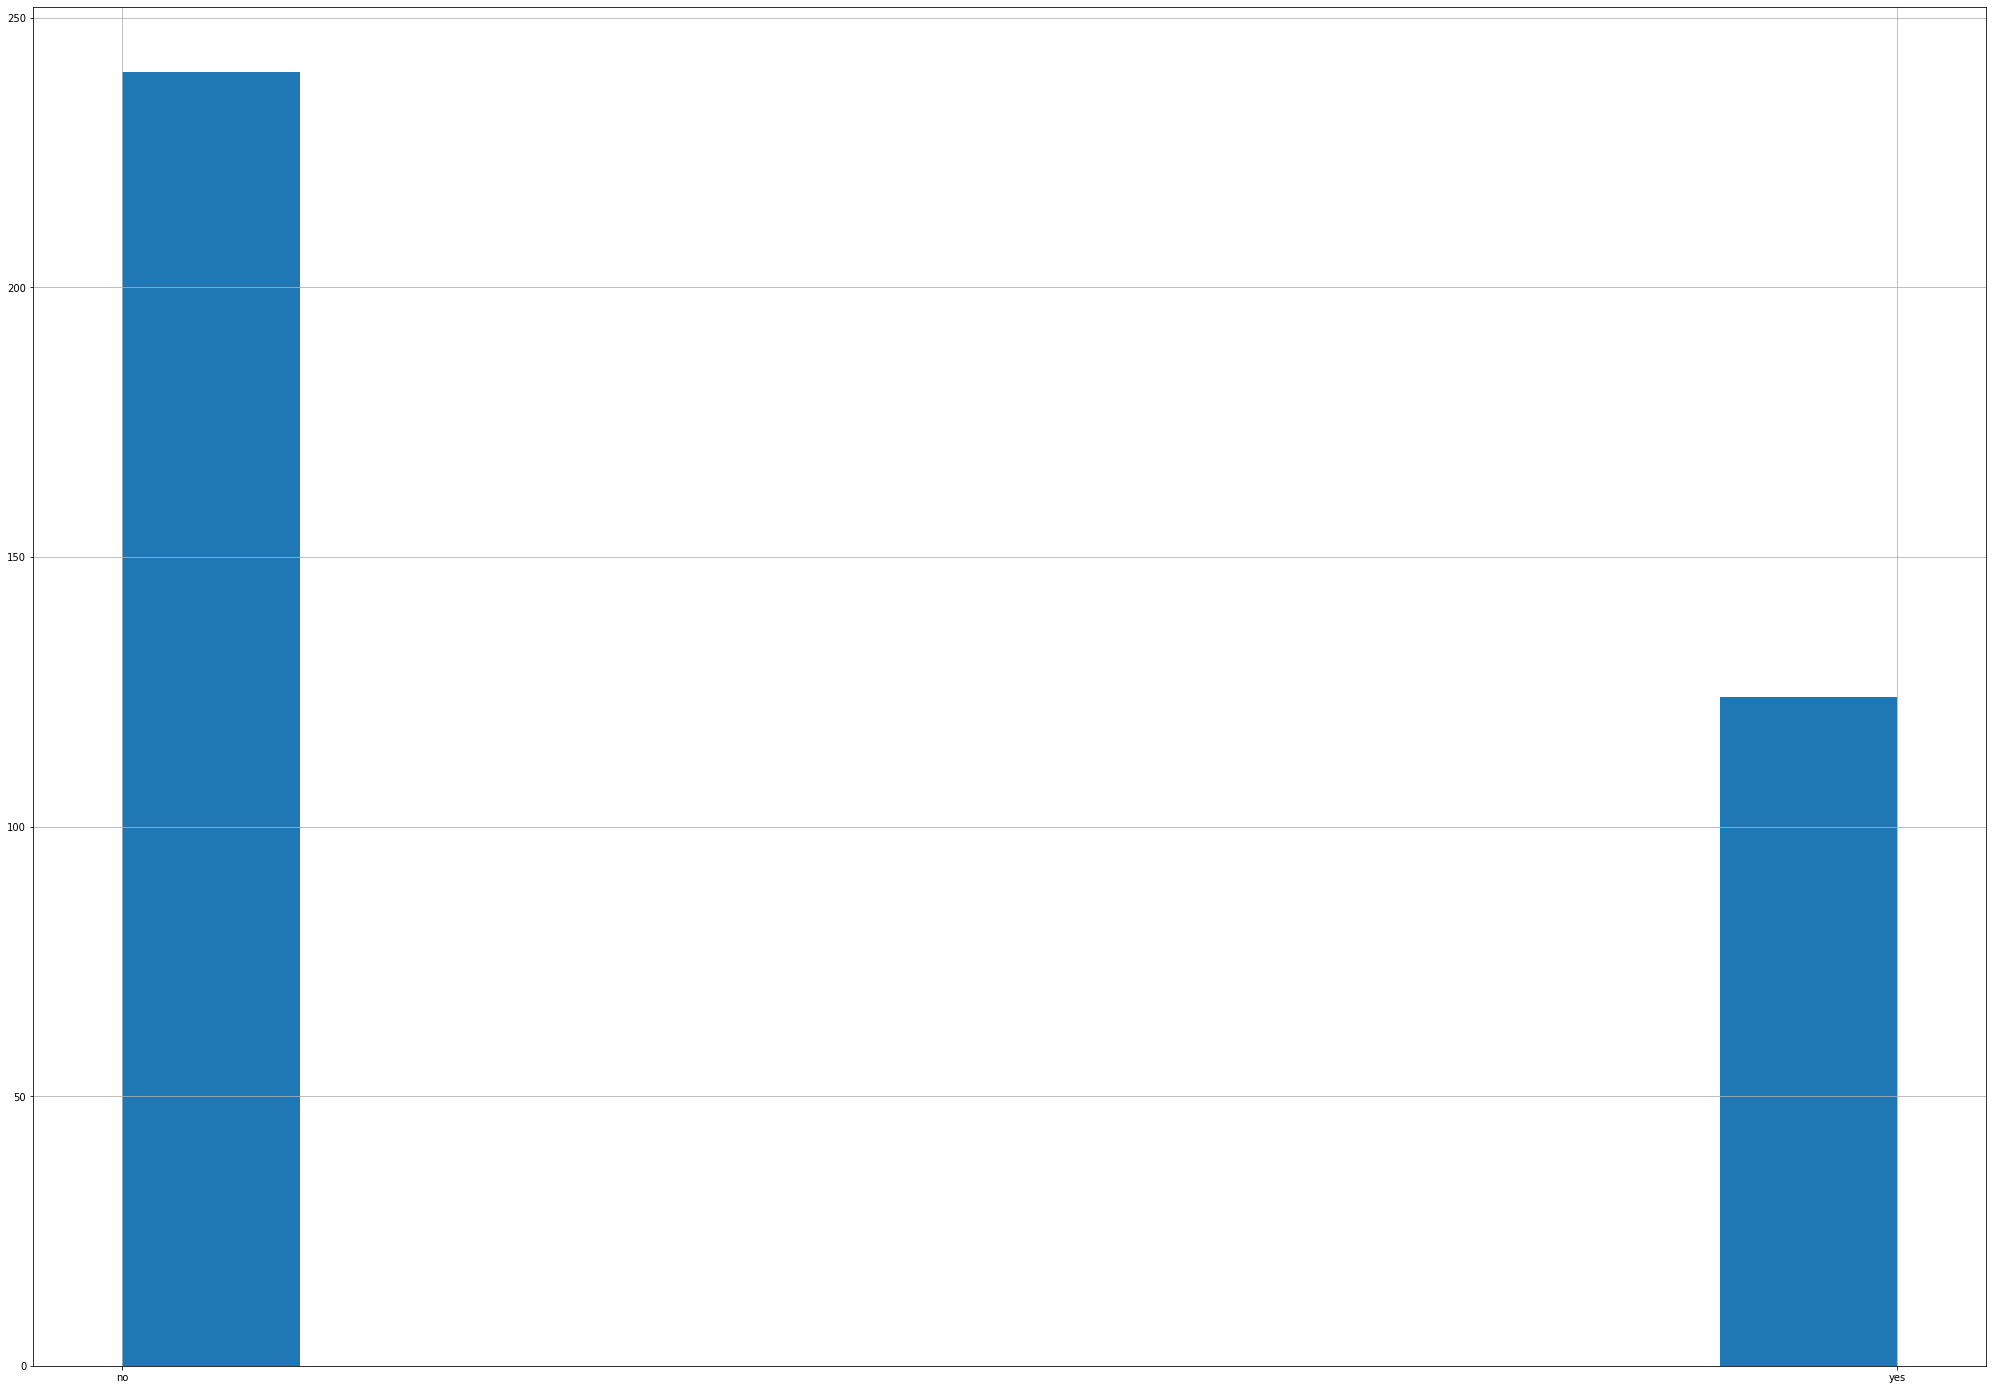

In [203]:
stud.romantic.hist();
print(stud.romantic.value_counts())
stud.romantic.isnull().sum()

In [204]:
stud.groupby(['school', 'romantic']).romantic.count()

school  romantic
GP      no          215
        yes         106
MS      no           25
        yes          18
Name: romantic, dtype: int64

In [205]:
stud.groupby(['sex', 'romantic']).romantic.count()

sex  romantic
F    no          117
     yes          78
M    no          123
     yes          46
Name: romantic, dtype: int64

In [206]:
stud.groupby(['age', 'romantic']).romantic.count()

age  romantic
15   no          53
     yes         18
16   no          70
     yes         27
17   no          58
     yes         34
18   no          43
     yes         33
19   no          13
     yes         10
20   no           2
     yes          1
21   no           1
22   yes          1
Name: romantic, dtype: int64

Зависимость одинаковая - значений "no" больше, чем "yes"

In [207]:
romantic_null_idx = stud.loc[(stud.romantic.isnull())].index
stud.loc[romantic_null_idx, 'romantic'] = 'no'

# Проверка после замены
stud.romantic.isnull().sum()

0

##### Выводы по колонке romantic
- Пропуски заполнены максимально представленным значением - "no"

#### 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64


27

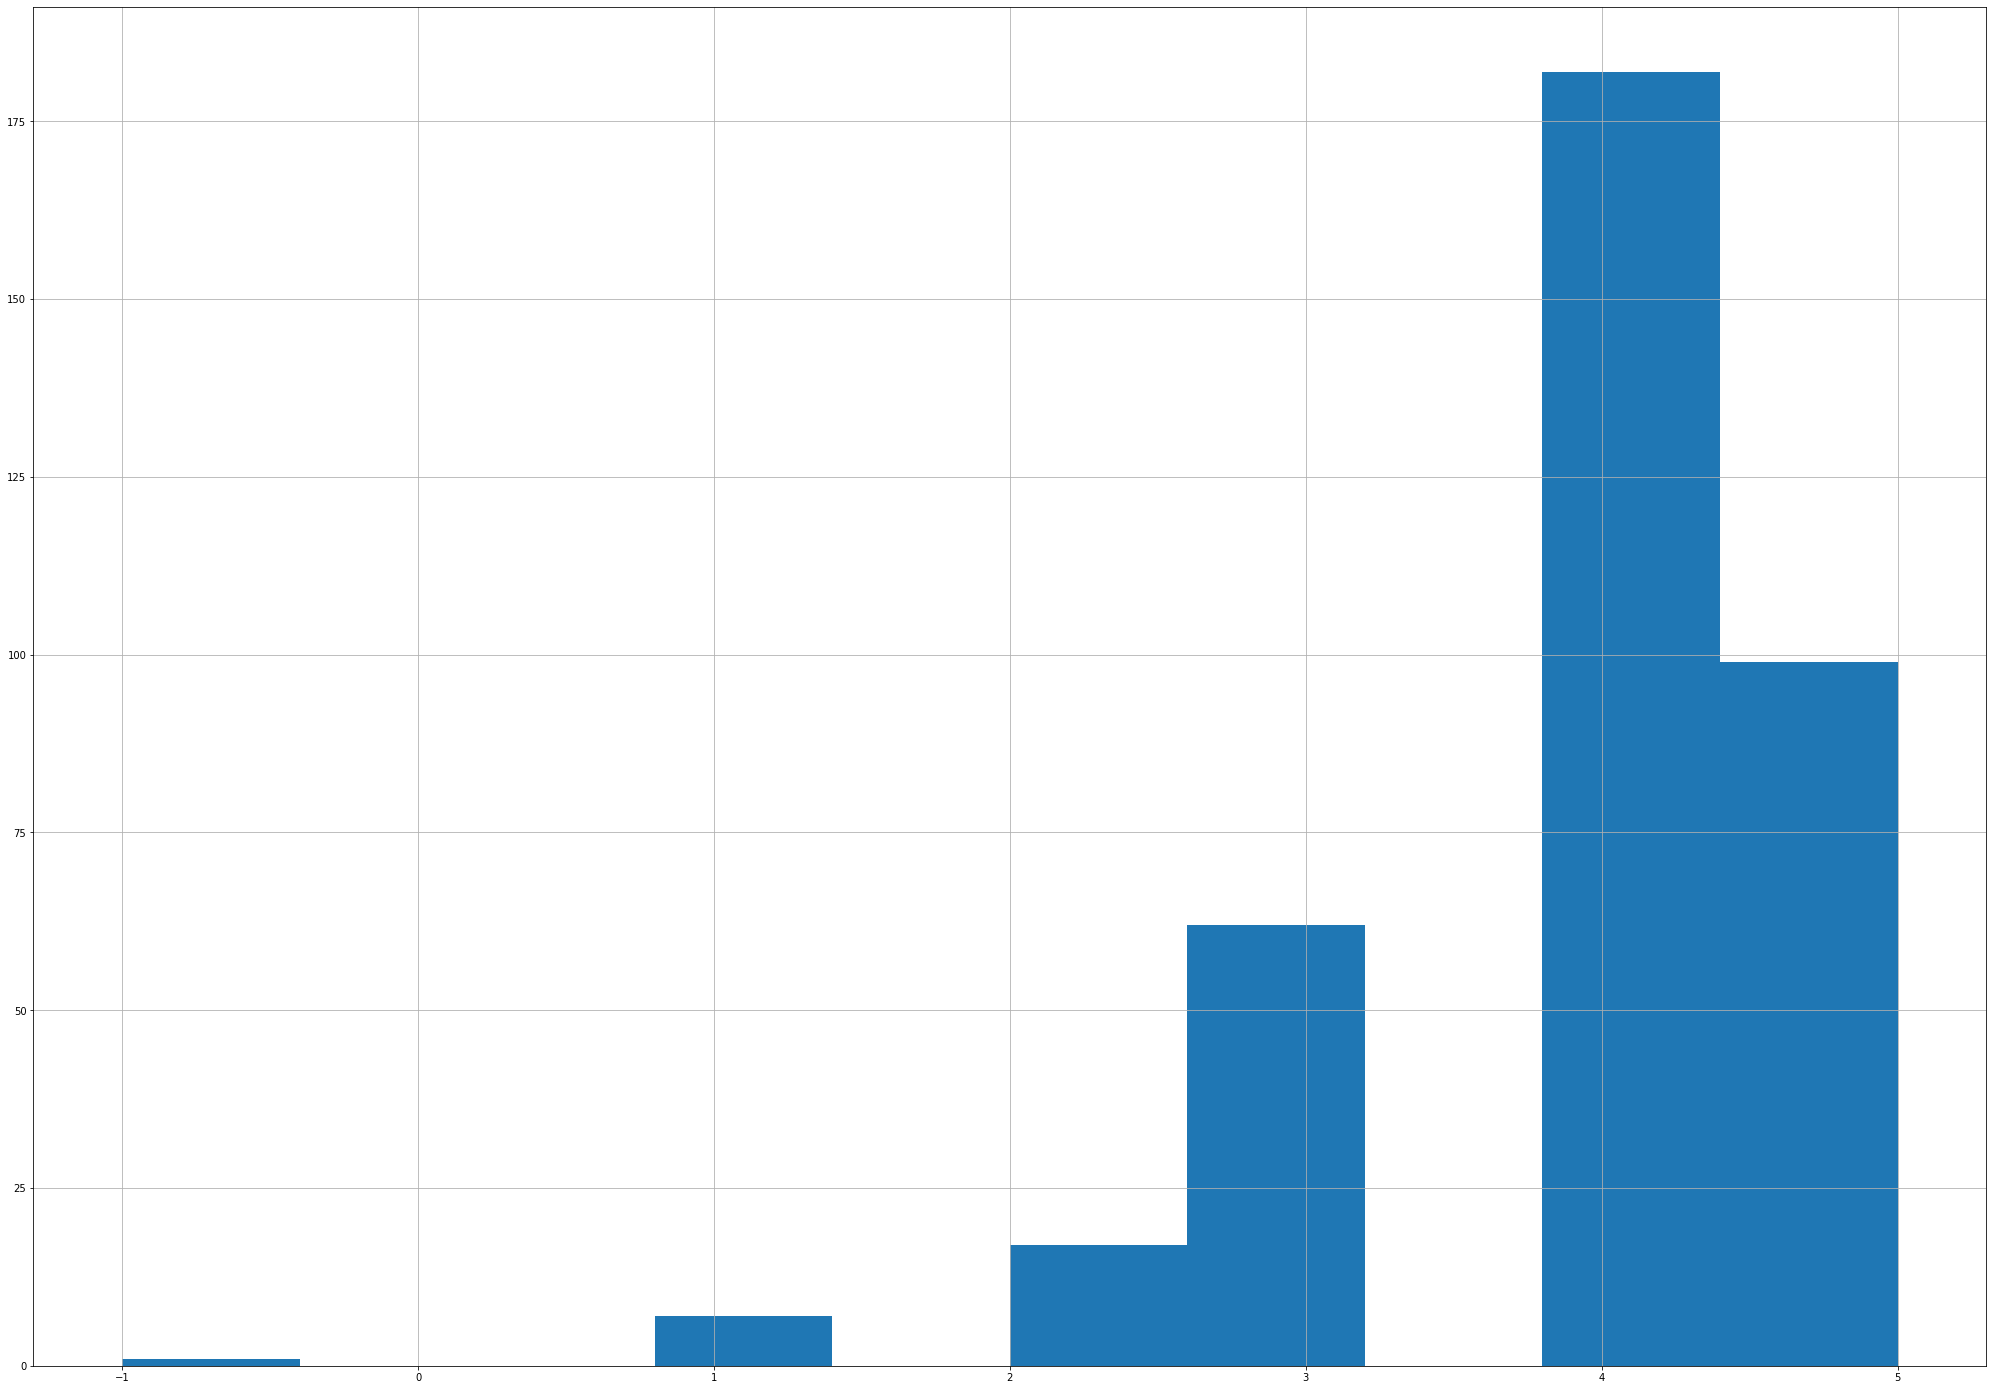

In [208]:
stud.famrel.hist();
print(stud.famrel.value_counts())
stud.famrel.isnull().sum()

Один выброс = -1. Предположим, что знак "минус" проставлен по ошибке. Исправим на +1

In [209]:
stud.loc[stud.famrel == -1, 'famrel'] = 1

4.0    182
5.0     99
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64


27

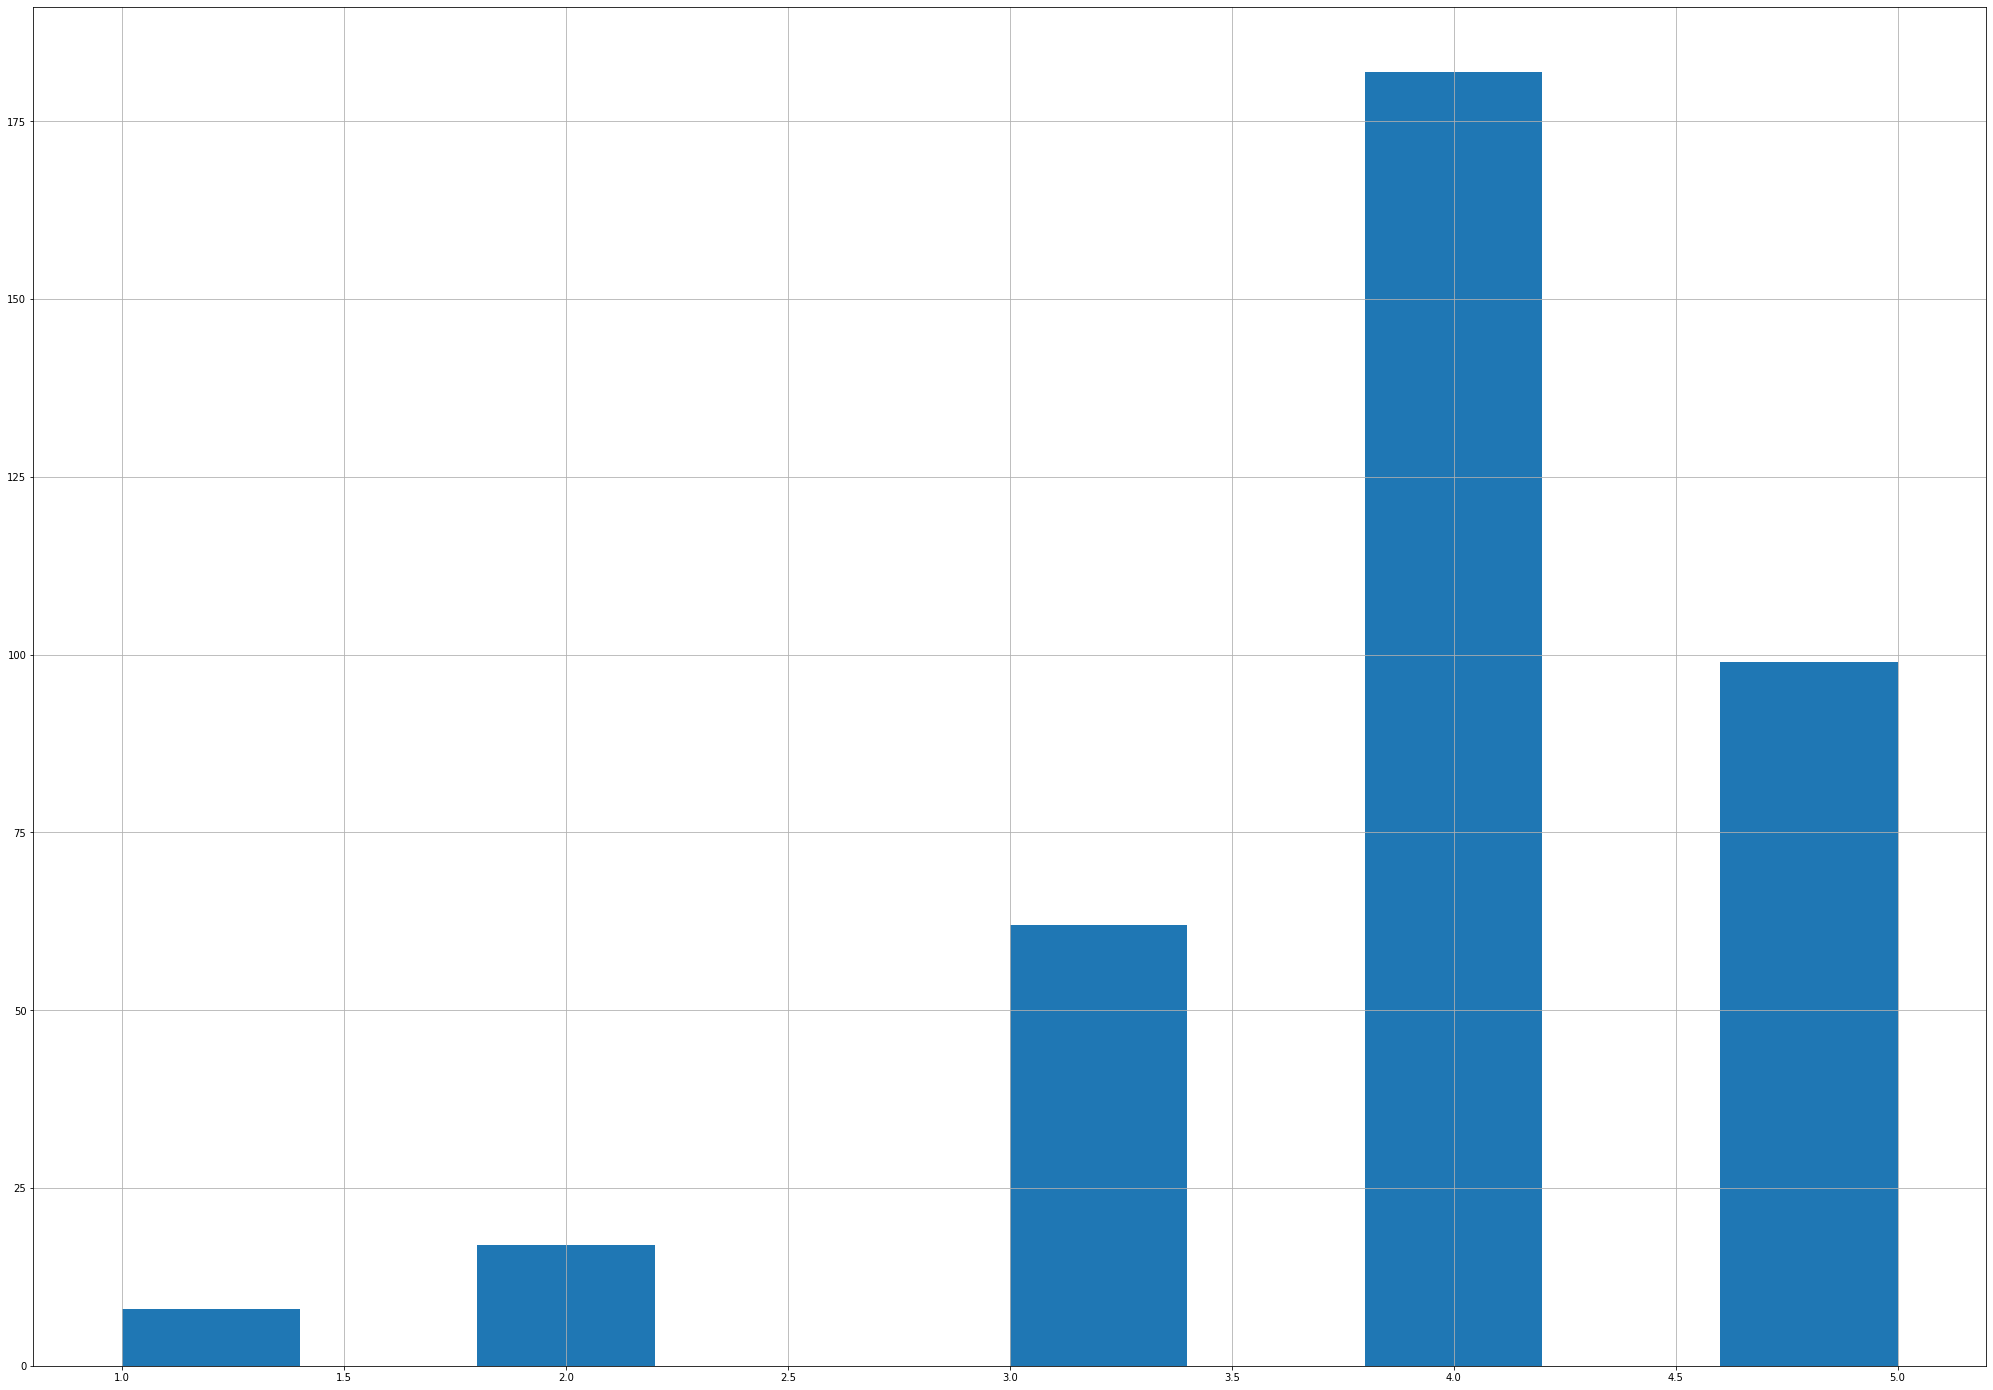

In [210]:
stud.famrel.hist();
print(stud.famrel.value_counts())
stud.famrel.isnull().sum()

In [211]:
famrel_null_idx = stud.loc[(stud.famrel.isnull())].index
stud.loc[famrel_null_idx, 'famrel'] = 4

# Проверка после замены
stud.famrel.isnull().sum()

0

##### Выводы по колонке famrel
- У значения, соответствующего выбросу = -1 исправлен знак на "+"
- Пропуски заменены на макс. представленное значение = 4

#### 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64


11

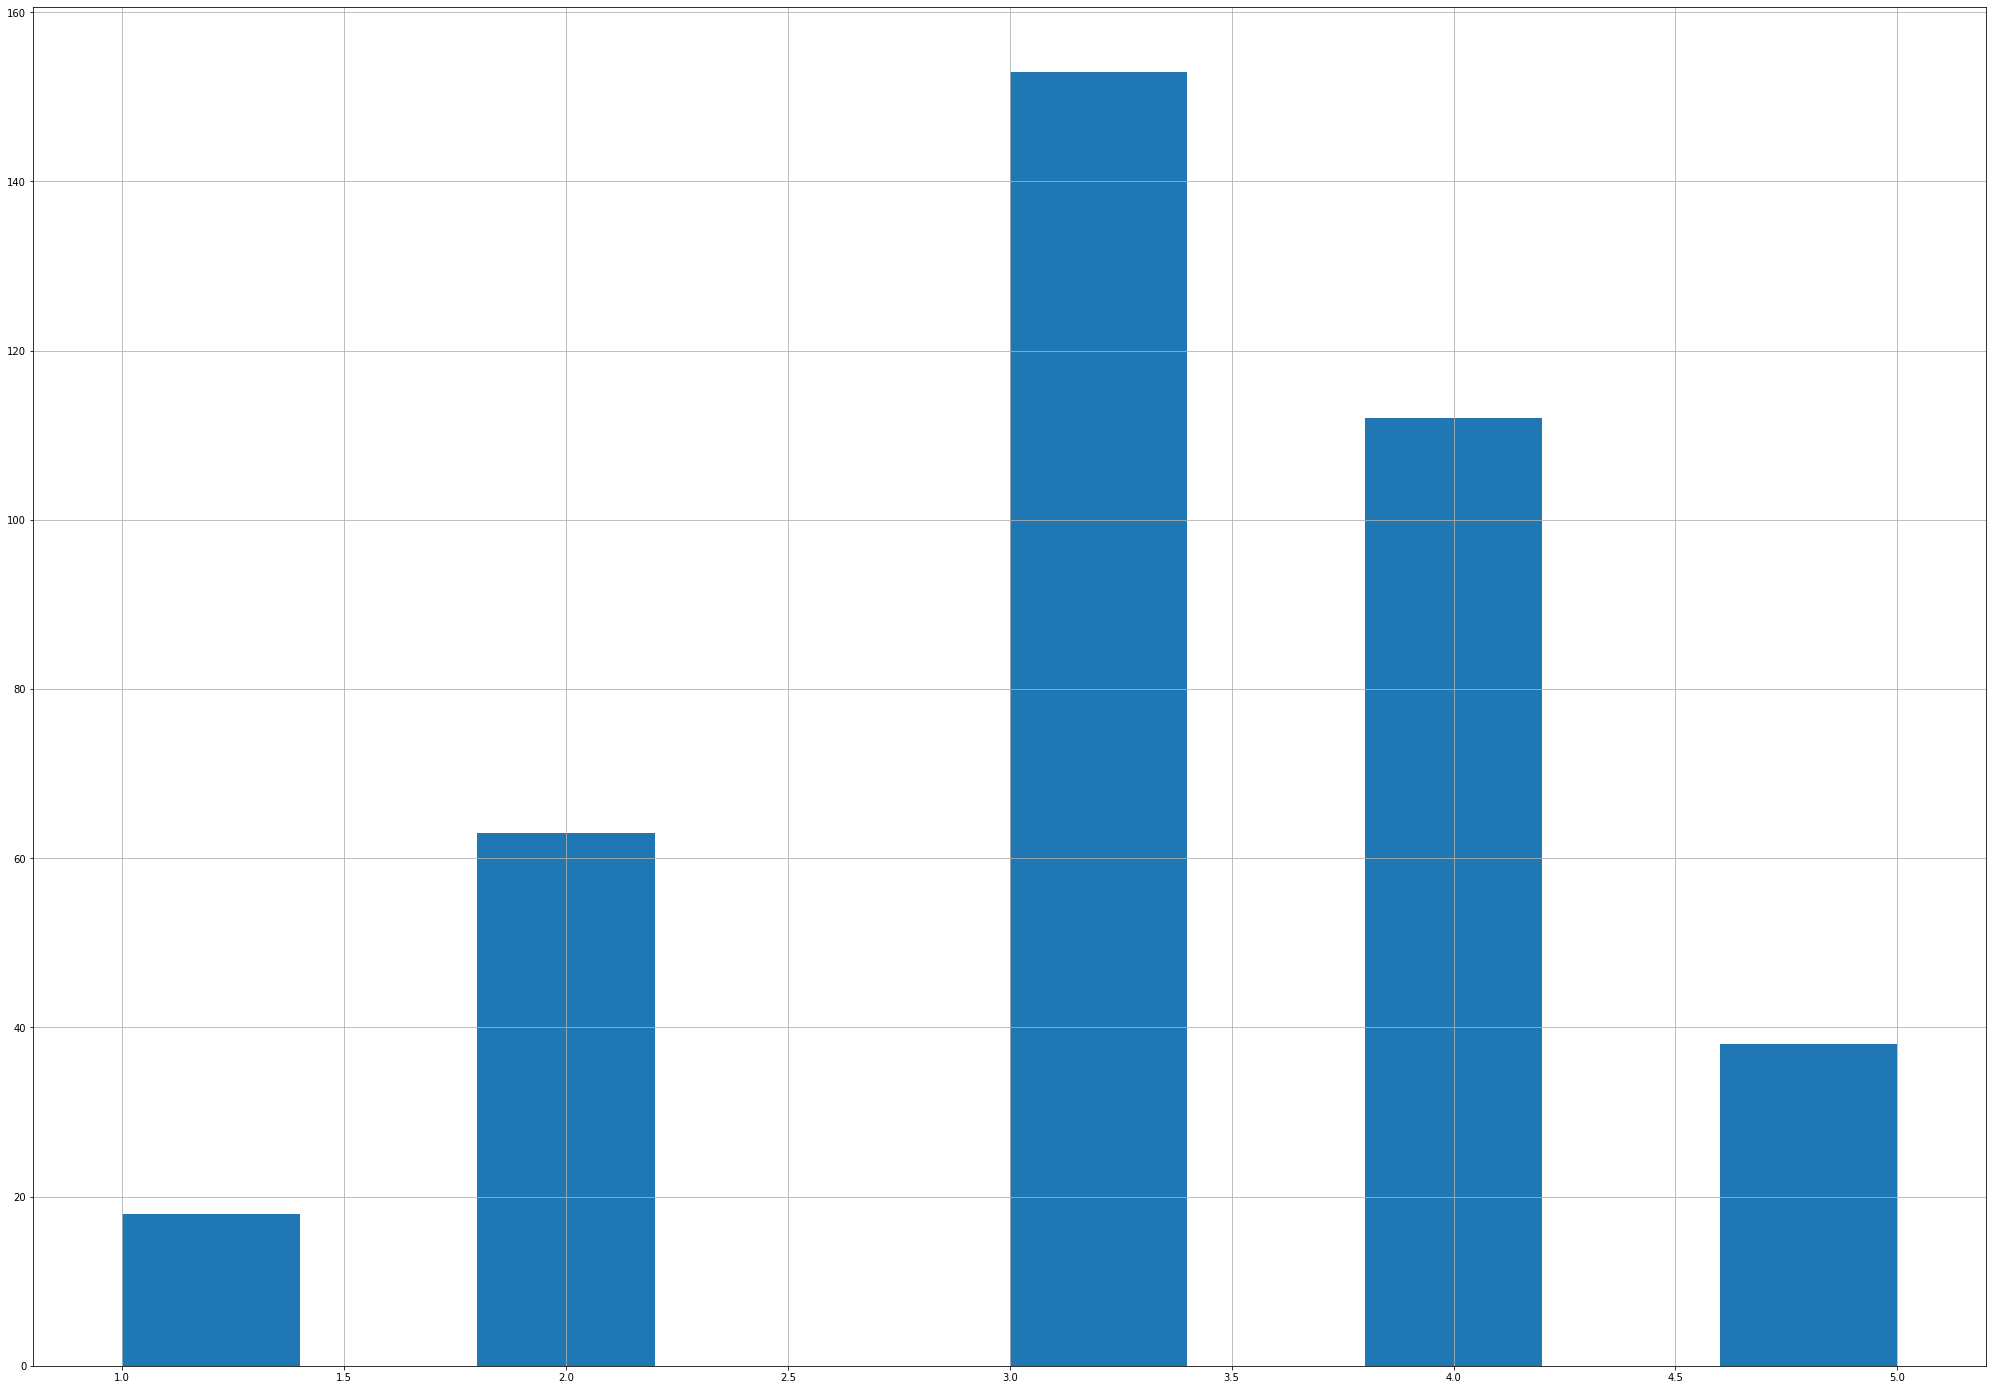

In [212]:
stud.freetime.hist();
print(stud.freetime.value_counts())
stud.freetime.isnull().sum()

Этот признак по идее должен обратно коррелировать с признаком studytime. Проверим

2.0    201
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64


0

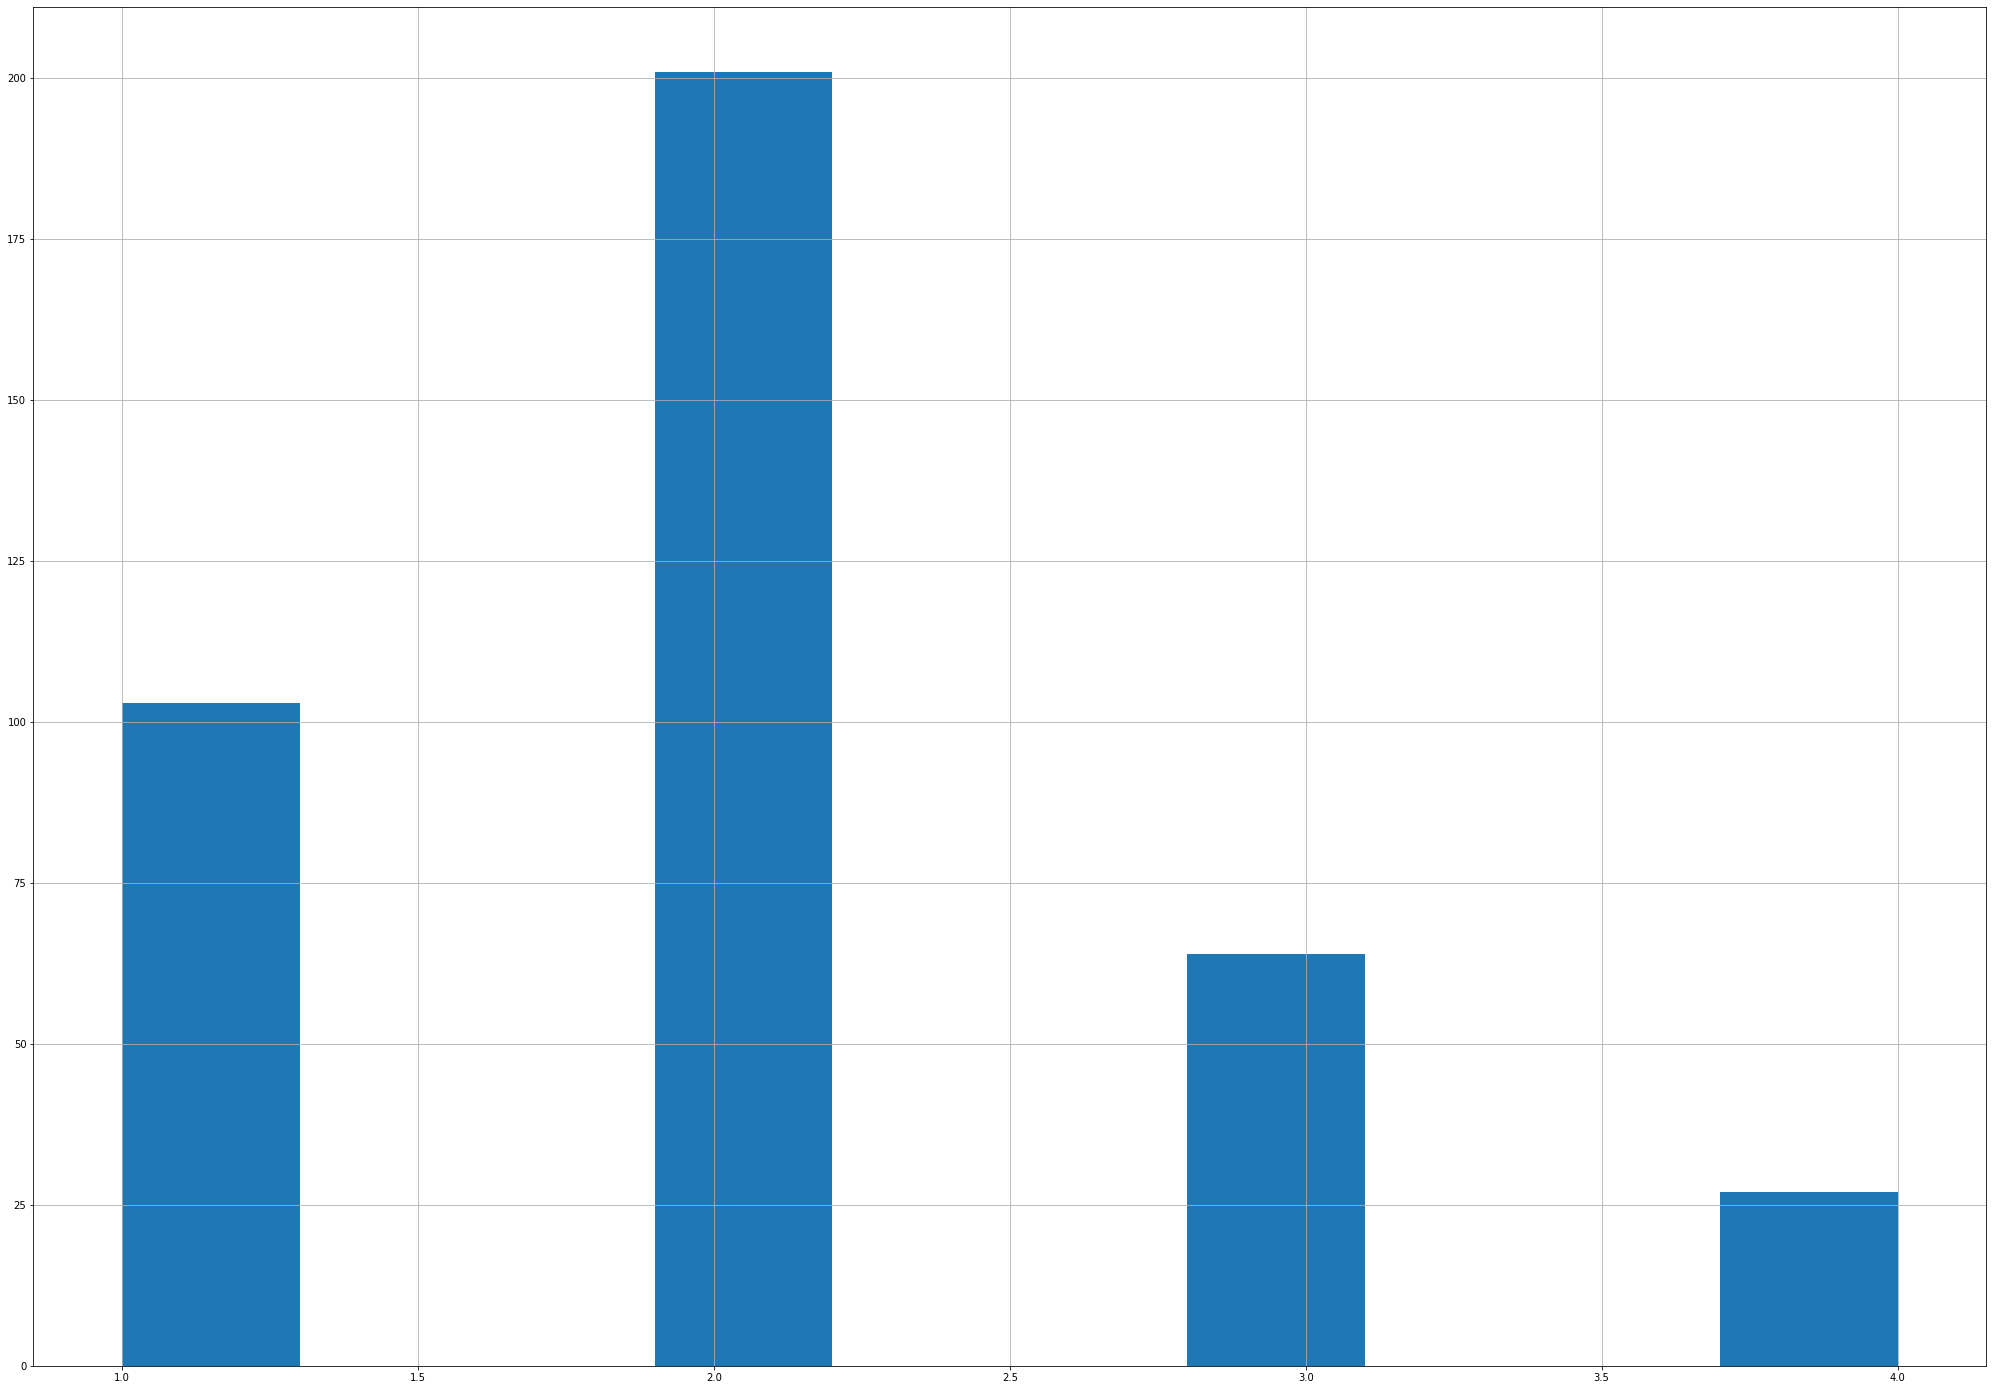

In [213]:
stud.studytime.hist();
print(stud.studytime.value_counts())
stud.studytime.isnull().sum()

Отрицательная корреляция на первый взгляд есть, но было бы лучше, если бы кол-во диапазонов разбиения в обоих случаях было одинаковым

In [214]:
freetime_null_idx = stud.loc[(stud.freetime.isnull())].index
stud.loc[freetime_null_idx, 'freetime'] = 3

# Проверка после замены
stud.freetime.isnull().sum()

0

##### Выводы по колонке freetime
- Пропуски заменены на макс. представленное значение = 3

#### 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64


8

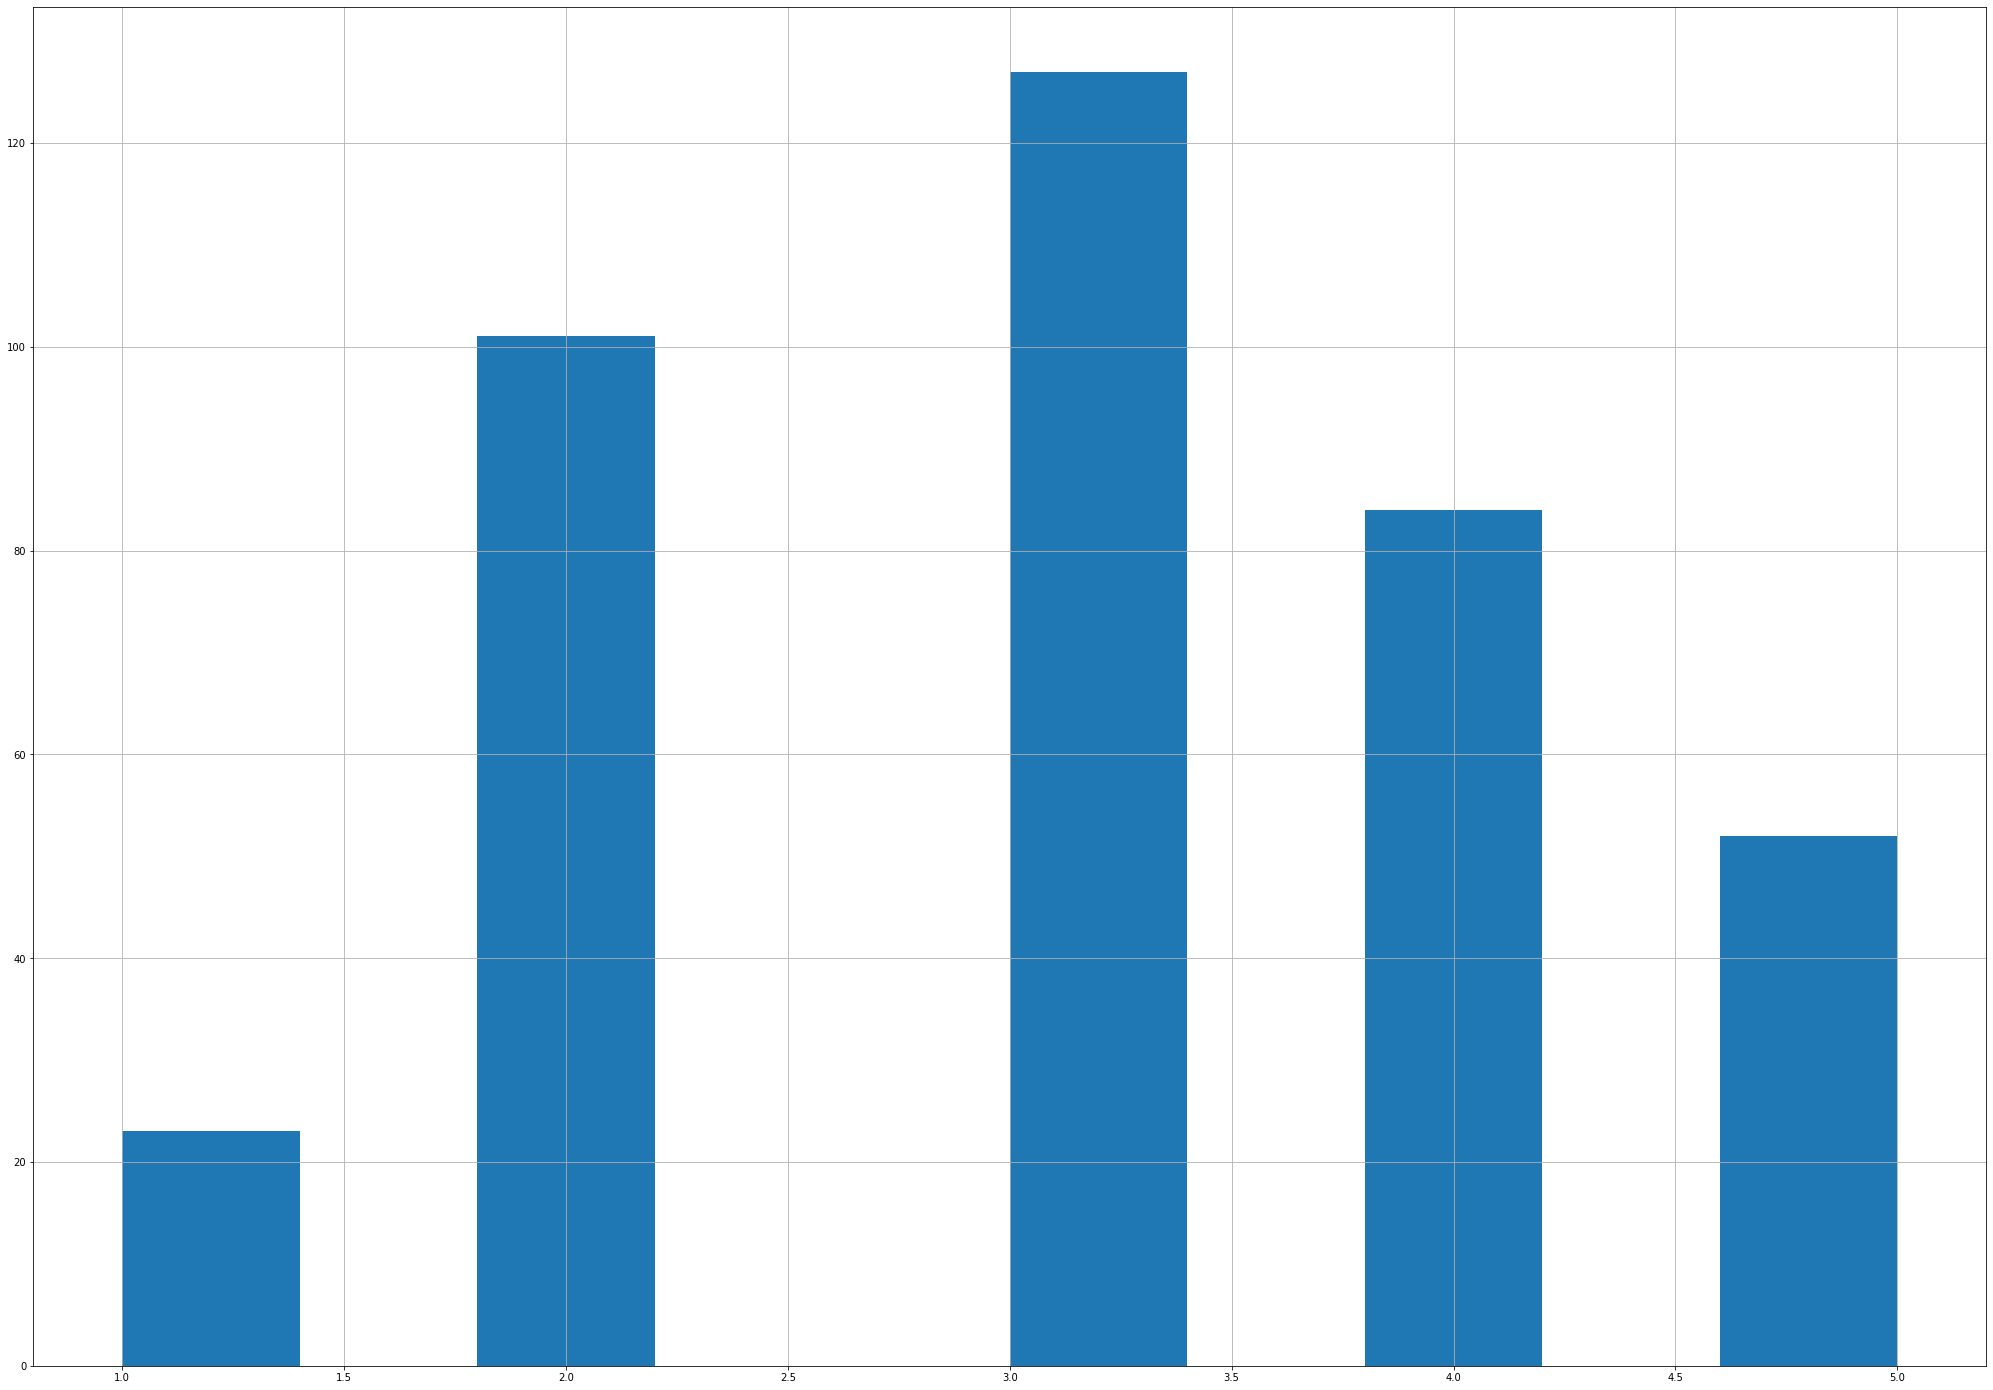

In [215]:
stud.goout.hist();
print(stud.goout.value_counts())
stud.goout.isnull().sum()

In [216]:
goout_null_idx = stud.loc[(stud.goout.isnull())].index
stud.loc[goout_null_idx, 'goout'] = 3

# Проверка после замены
stud.goout.isnull().sum()

0

##### Выводы по колонке goout
- Пропуски заменены на макс. представленное значение = 3

#### 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64


15

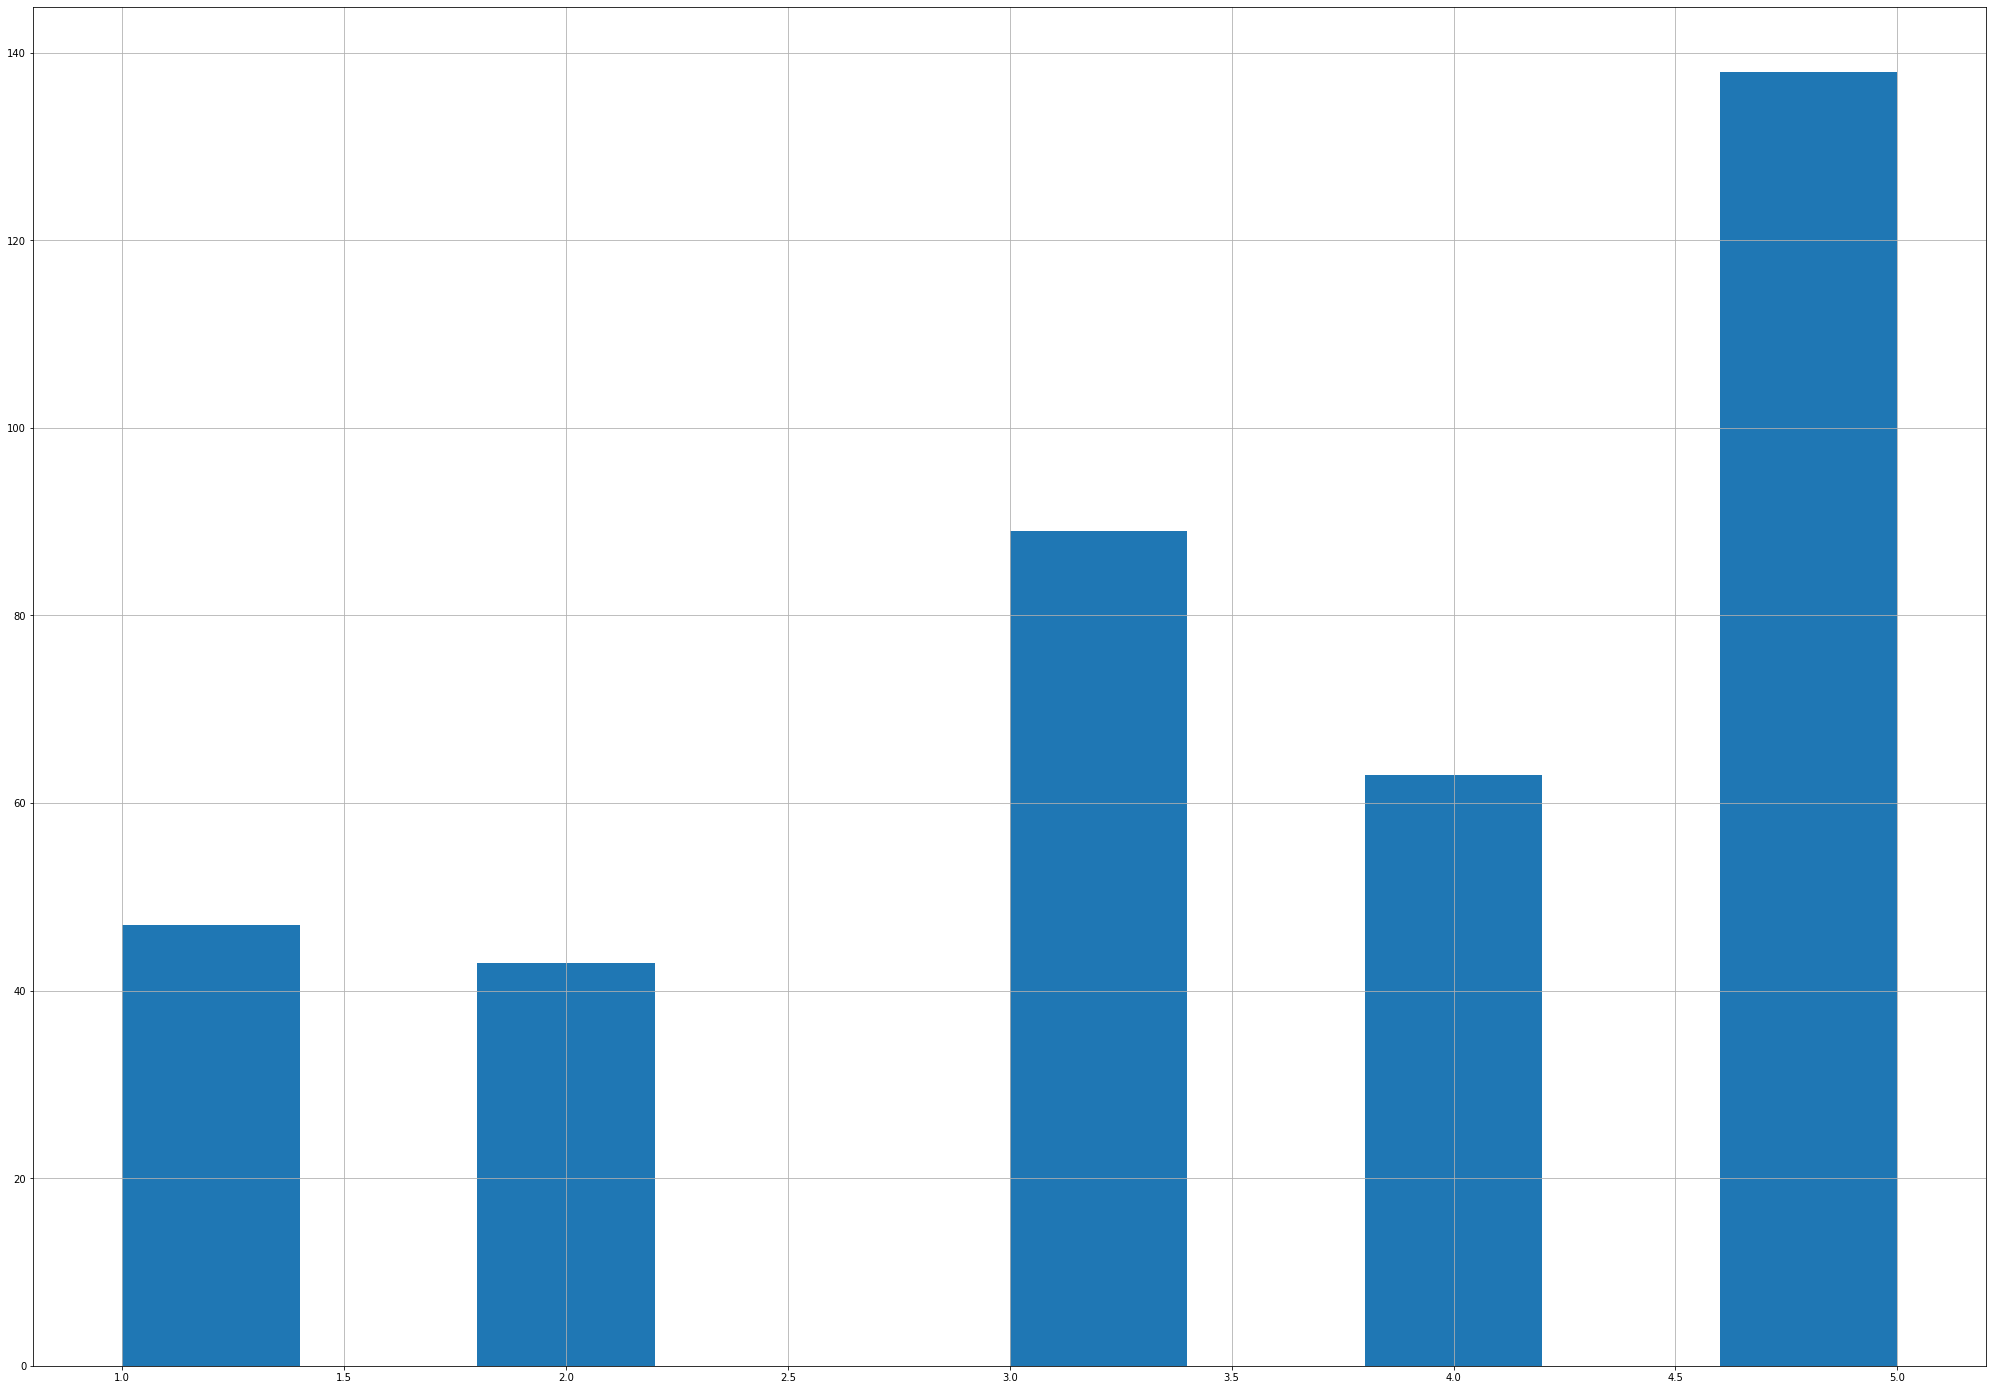

In [217]:
stud.health.hist();
print(stud.health.value_counts())
stud.health.isnull().sum()

In [218]:
health_null_idx = stud.loc[(stud.health.isnull())].index
stud.loc[health_null_idx, 'health'] = 3

# Проверка после замены
stud.health.isnull().sum()

0

##### Выводы по колонке health
- Пропуски заменены на среднее значение = 3

#### 28 absences — количество пропущенных занятий

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64


12

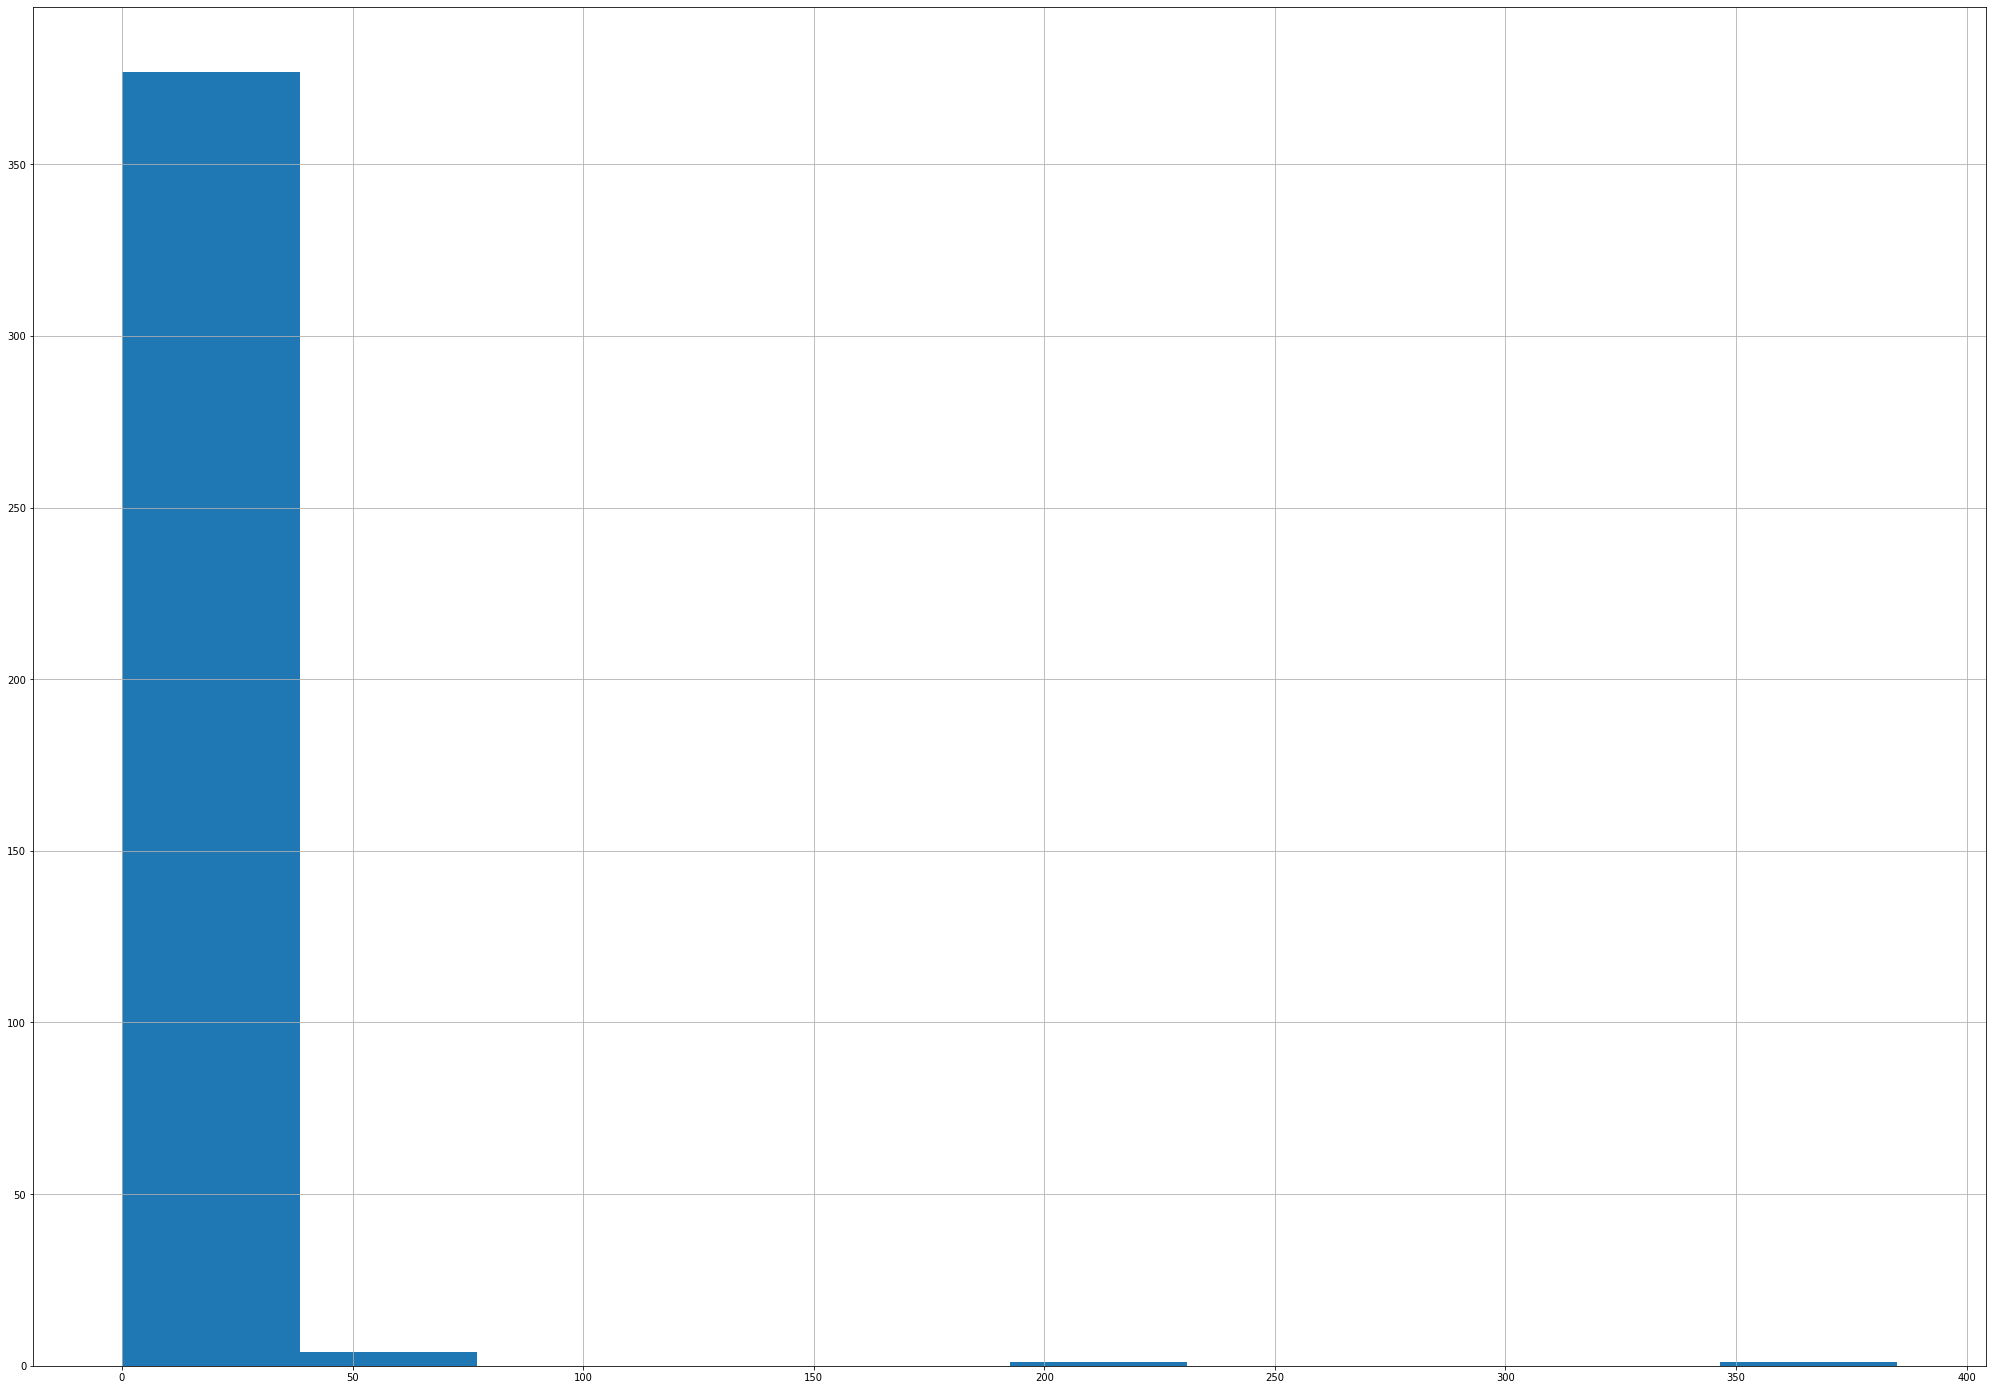

In [219]:
stud.absences.hist();
print(stud.absences.value_counts())
stud.absences.isnull().sum()

Все значения >= 180 (20 учебных дней в месяц * 9 месяцев) будем считать выбросами. Посмотрим на них отдельно

In [220]:
stud.loc[stud.absences >= 180]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,mother,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


Заменим выбросы на макс. кол-во пропусков, которое меньше 180

In [221]:
stud.loc[stud.absences < 180].absences.max()

75.0

In [222]:
stud.loc[stud.absences >= 180, 'absences'] = stud.loc[stud.absences < 180].absences.max()

0.0     111
2.0      60
4.0      53
6.0      31
8.0      21
10.0     17
12.0     12
14.0     12
3.0       8
16.0      7
7.0       6
5.0       5
18.0      5
20.0      4
75.0      3
1.0       3
22.0      3
9.0       3
15.0      2
13.0      2
11.0      2
25.0      1
17.0      1
54.0      1
26.0      1
56.0      1
23.0      1
28.0      1
21.0      1
30.0      1
19.0      1
38.0      1
40.0      1
24.0      1
Name: absences, dtype: int64


12

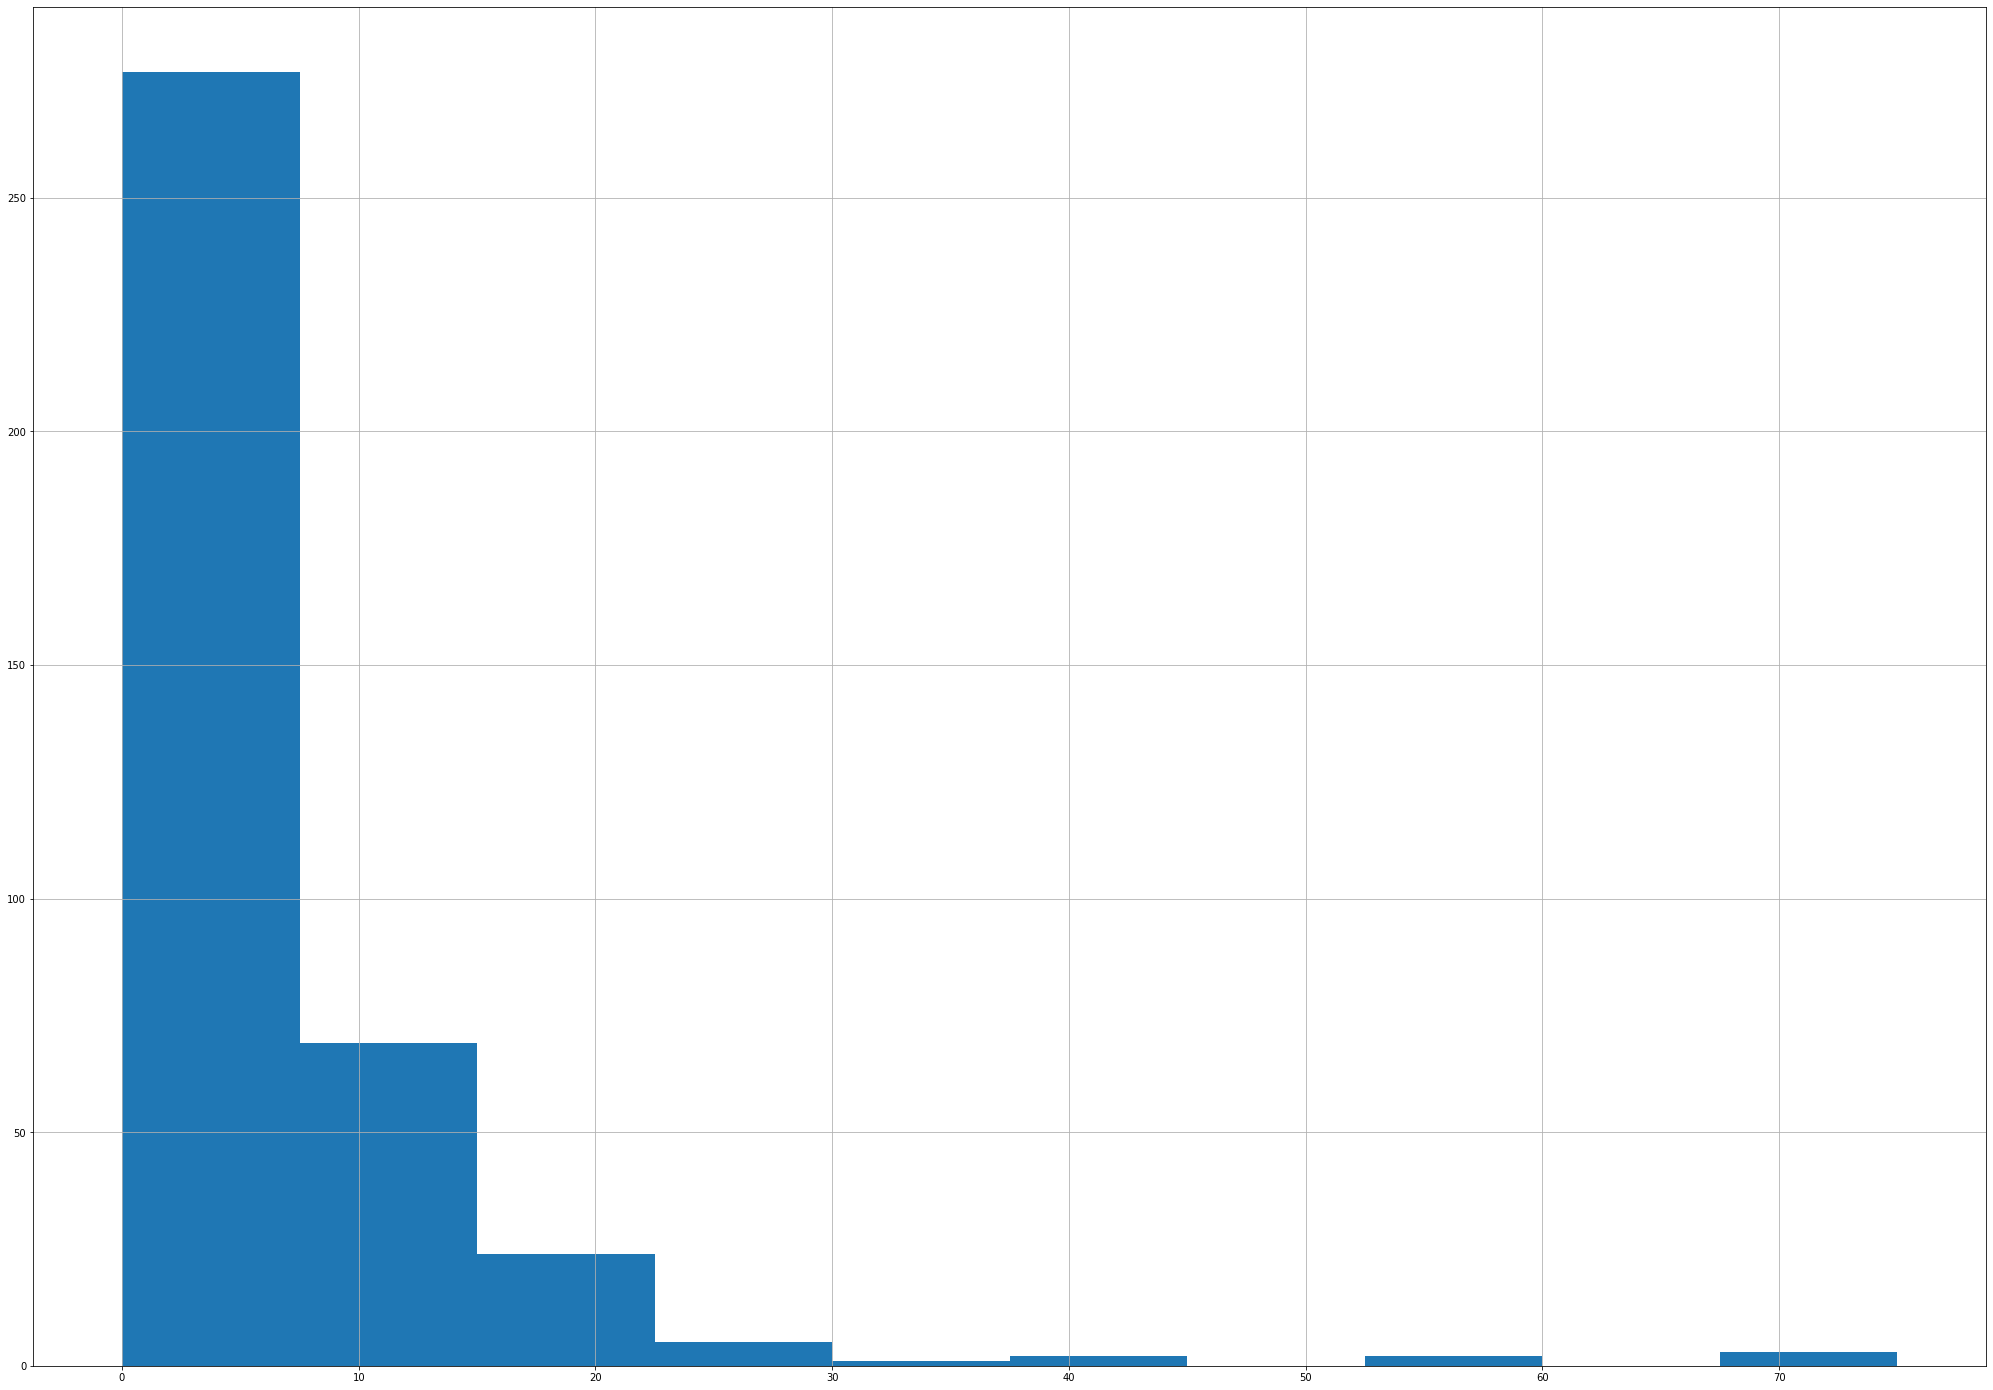

In [223]:
stud.absences.hist();
print(stud.absences.value_counts())
stud.absences.isnull().sum()

In [224]:
absences_null_idx = stud.loc[(stud.absences.isnull())].index
stud.loc[absences_null_idx, 'absences'] = round(stud.absences.mean())

# Проверка после замены
stud.absences.isnull().sum()

0

##### Выводы по колонке absences
- Заменили выбросы на макс. кол-во пропусков, которое меньше 180 (=75)
- Пропуски заменили на среднее кол-во пропусков = 6

#### 29 score — баллы по госэкзамену по математике

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


6

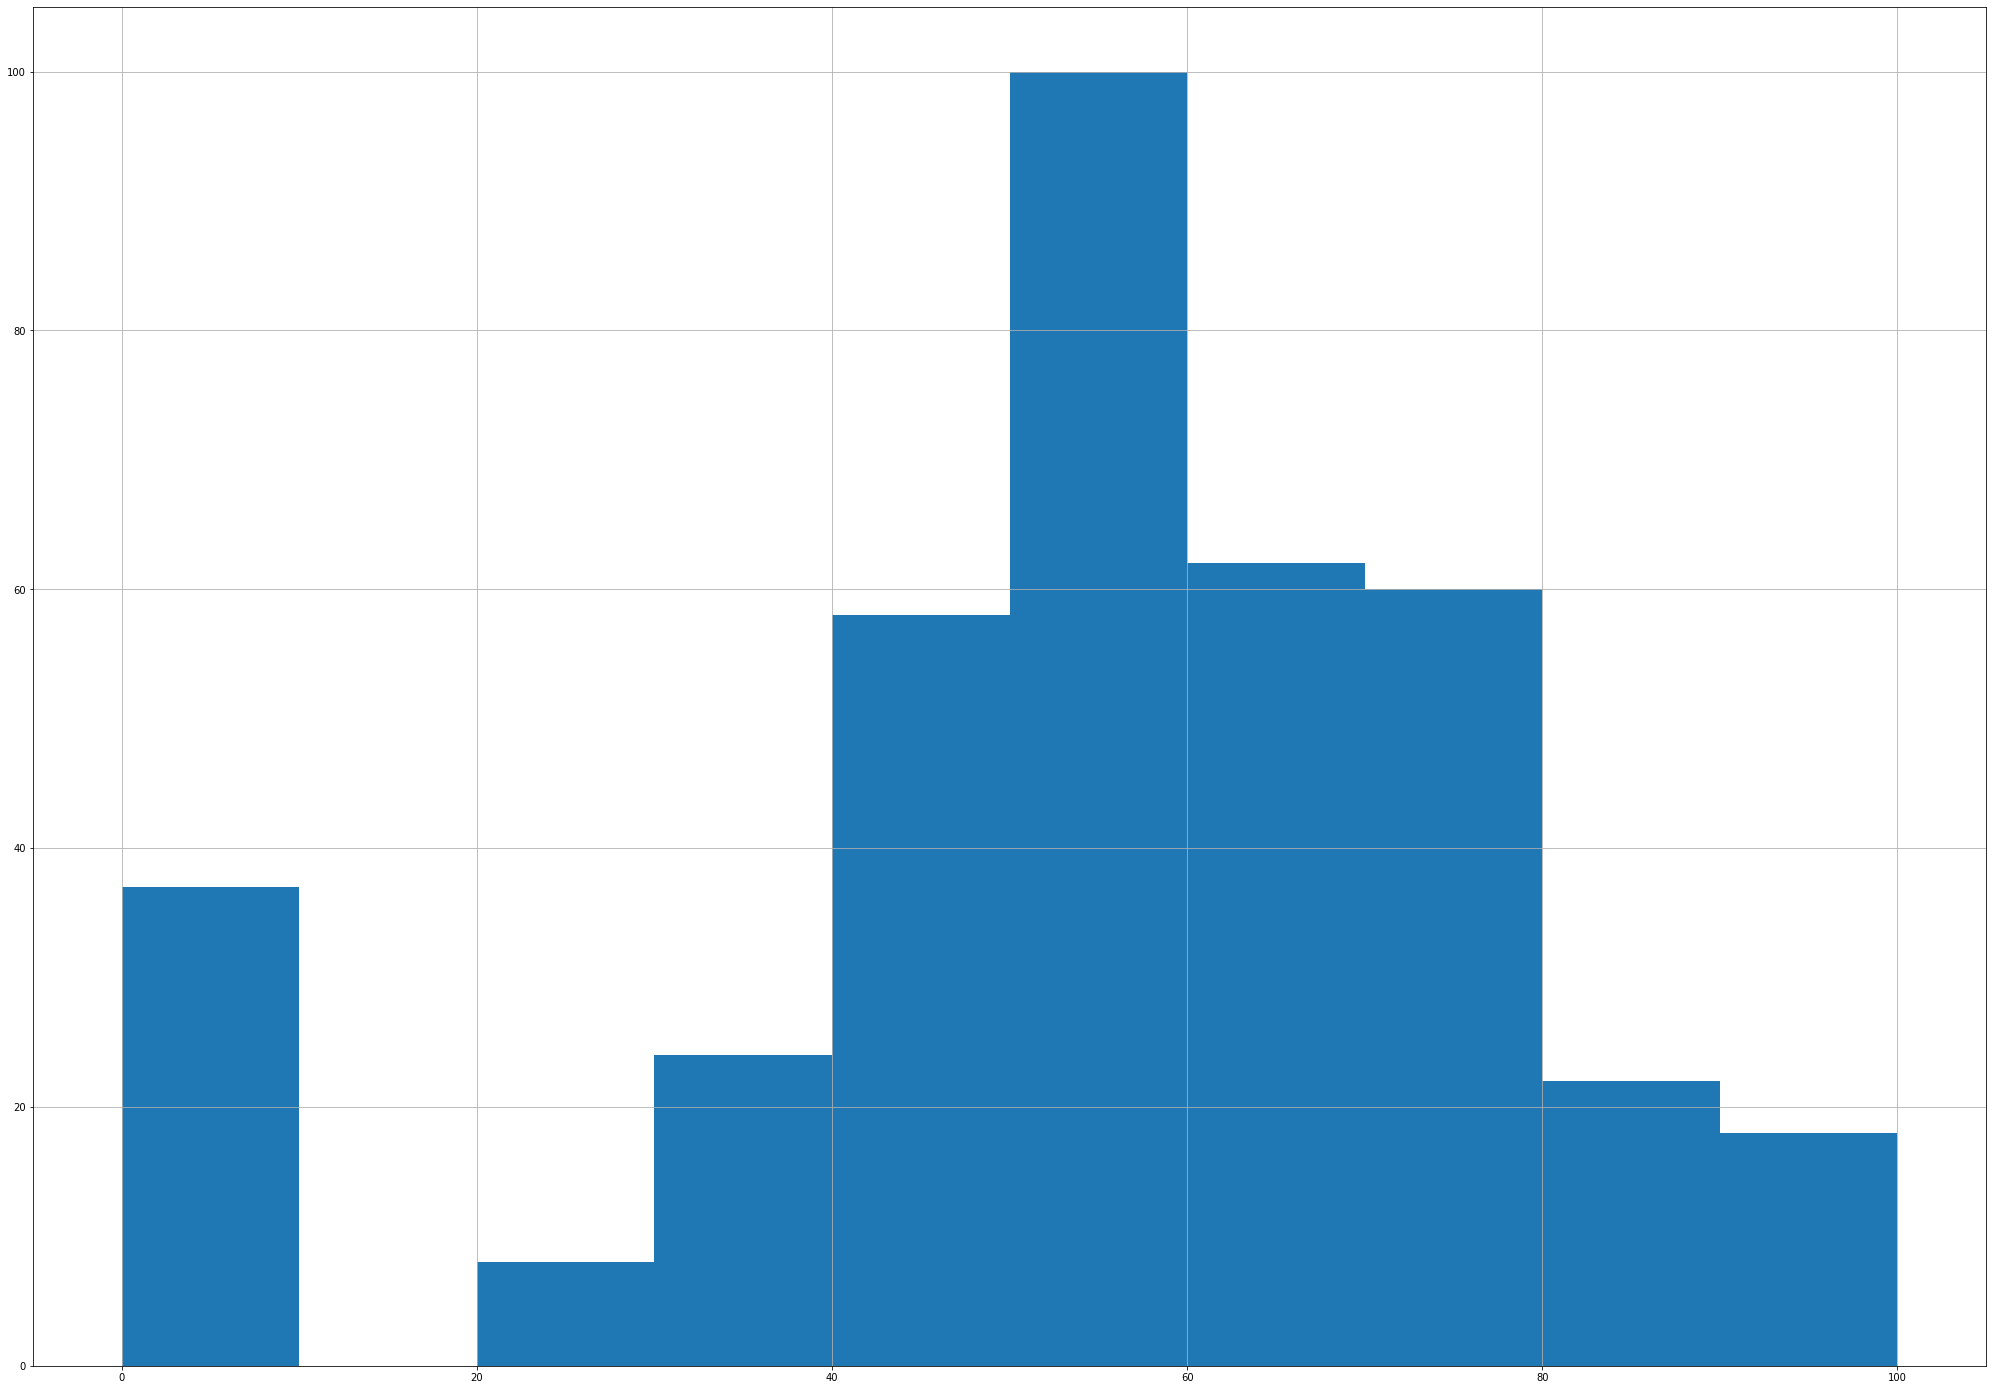

In [225]:
stud.score.hist();
print(stud.score.value_counts())
stud.score.isnull().sum()

In [226]:
score_null_idx = stud.loc[(stud.score.isnull())].index
stud.loc[score_null_idx, 'score'] = round(stud.score.mean())

# Проверка после замены
stud.score.isnull().sum()

0

##### Выводы по колонке score
- Выбросов нет
- Пропуски заменили на среднее кол-во пропусков = 6

#### 30 studytime, granular — назначение колонки пока неизвестно

In [227]:
# Переименуем колонку "studytime, granular" в колонку "studytime_gran"
stud.columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 
    'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 
    'paid', 'activities', 'nursery', 'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
    'freetime', 'goout', 'health', 'absences', 'score']
stud.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime_gran, dtype: int64


7

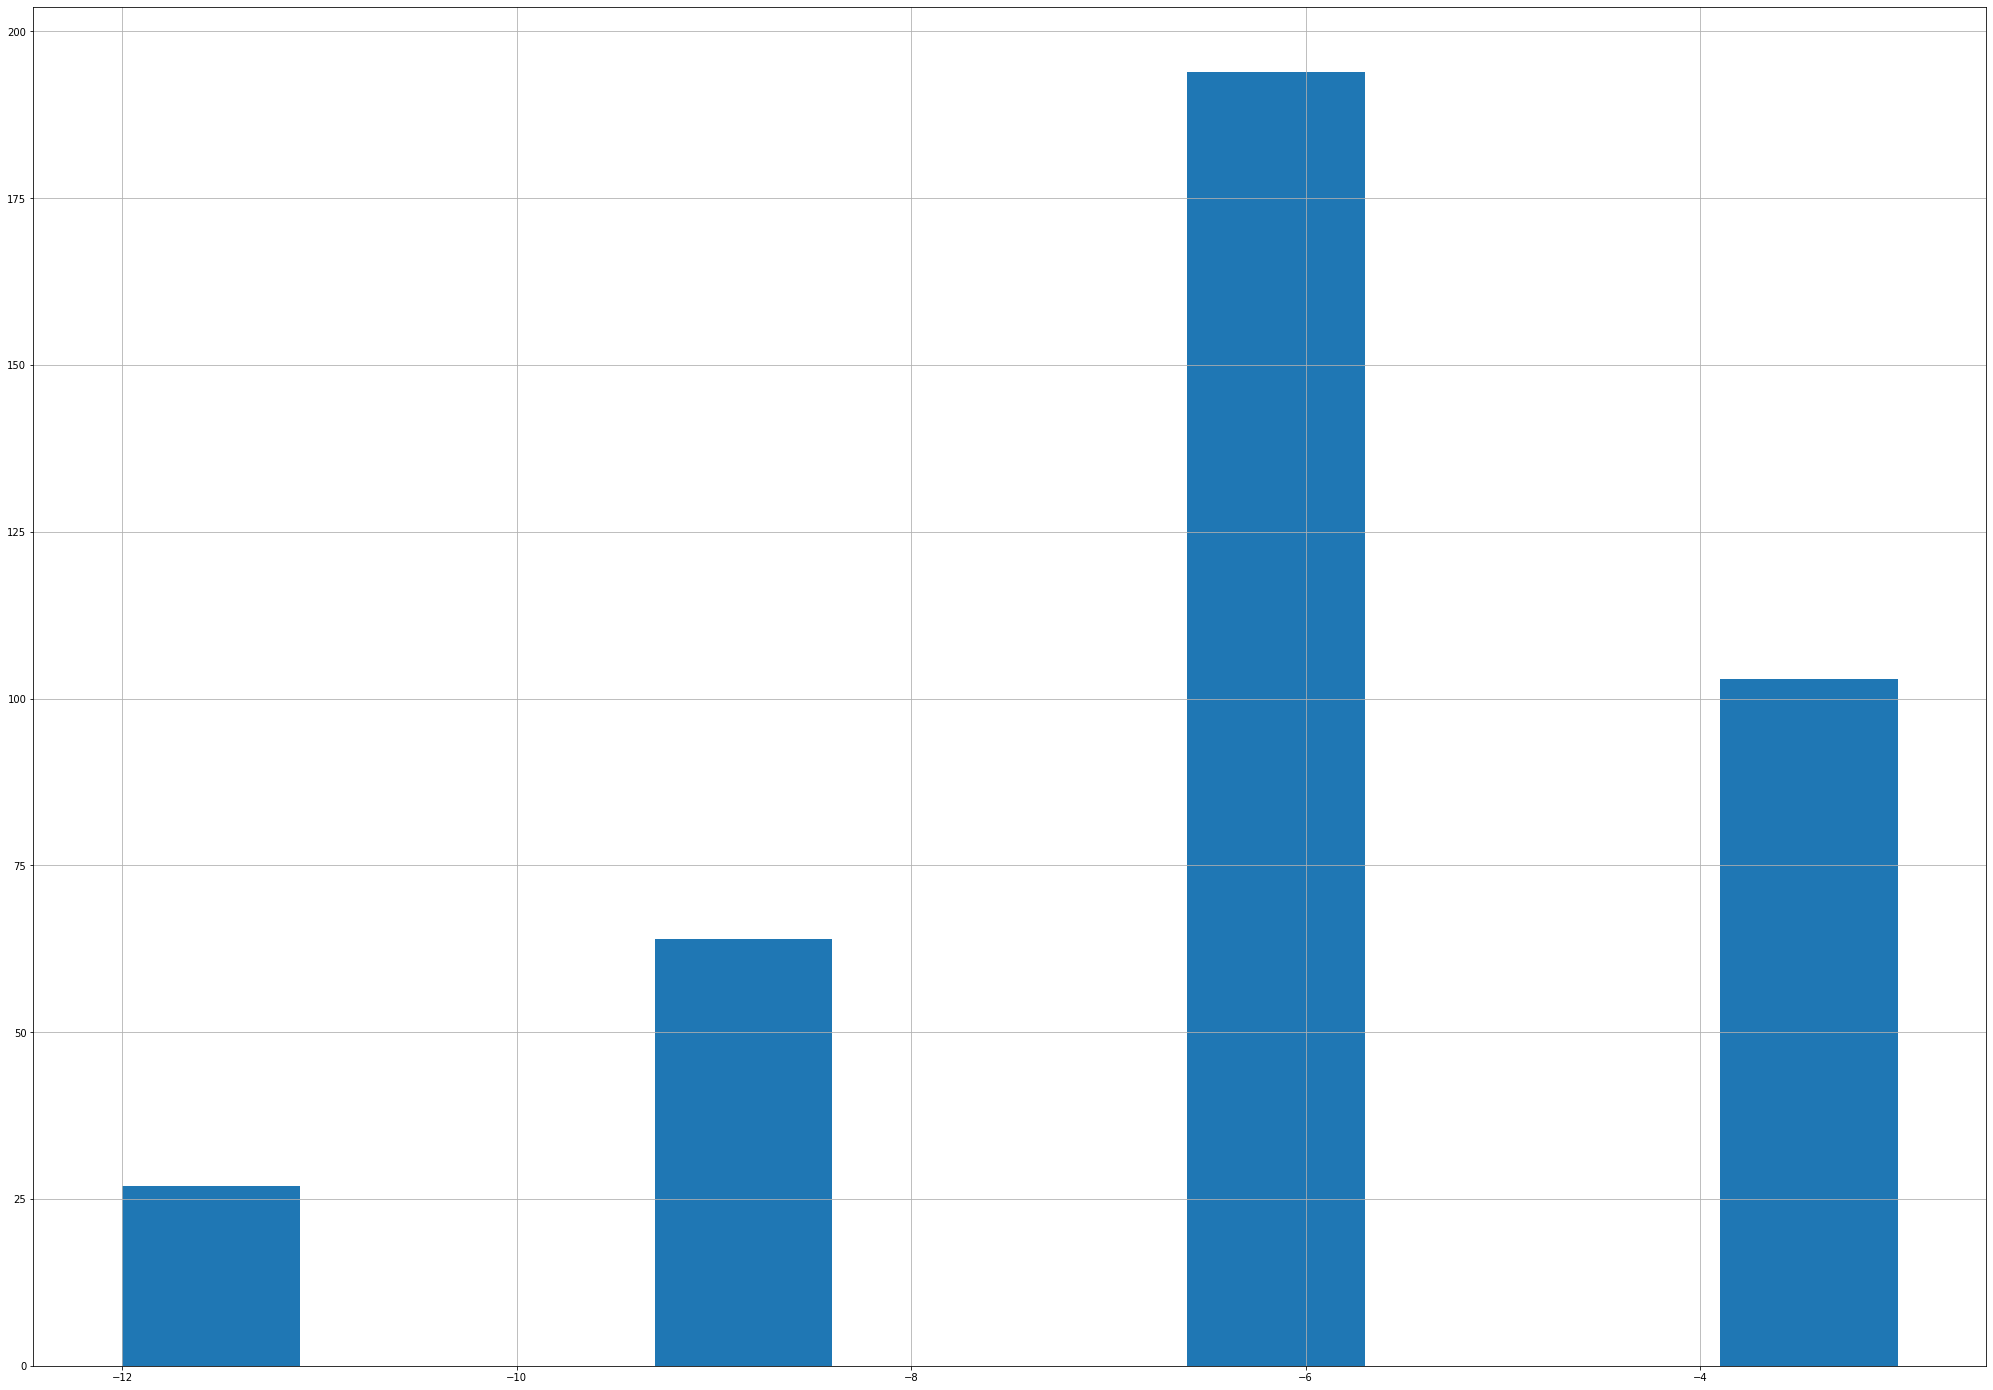

In [228]:
stud.studytime_gran.hist();
print(stud.studytime_gran.value_counts())
stud.studytime_gran.isnull().sum()

In [229]:
# Зависимость между колонками studytime и studytime_gran
stud.groupby(['studytime', 'studytime_gran']).studytime_gran.count()

studytime  studytime_gran
1.0        -3.0              103
2.0        -6.0              194
3.0        -9.0               64
4.0        -12.0              27
Name: studytime_gran, dtype: int64

Налицо линейная зависимость с коэффициентом = -3.

Кол-во пропусков ровно столько же, сколько было в колонке studytime. Заполним пропуски аналогично же, т.е. для заполнения возьмем свое "среднее" значение = -6.

In [230]:
studytime_gran_null_idx = stud.loc[(stud.studytime_gran.isnull())].index
stud.loc[studytime_gran_null_idx, 'studytime_gran'] = -6.0

# Проверка после замены
stud.studytime_gran.isnull().sum()

0

##### Выводы по колонке studytime_gran
- Все малочисленные пропуски заменяем на "среднее" значение = -6
- Предположение о смысловой нагрузке колонки studytime_gran:

Если посмотреть на соответствие с колонкой studytime в таком виде:

studytime: .... (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
    
studytime_gran: .......-3, .........-6, ...........-9, ...........-12

и принять во внимание, что рабочих/учебных дней в месяце = 20-22, т.е. среднее кол-во = 21, тогда делаем предположение, что в колонке studytime_gran указан недоотдых (например, недосып) ученика в течение рабочего месяца.

- Поскольку есть однозначное соответствие между двумя рассмотренными колонками, для дальнейшего исследования можно оставить одну из них - studytime.

## Окончательные преобразования строковых колонок в числовые

In [231]:
# Составим список всех нечисловых колонок
col_cat = []
for c in stud.columns:
    if stud[str(c)].dtype == 'object':
        print(c, ': values = ', stud[str(c)].unique())
        col_cat.append(str(c))
# col_cat

school : values =  ['GP' 'MS']
sex : values =  ['F' 'M']
address : values =  ['U' 'R']
famsize : values =  ['GT3' 'LE3']
Pstatus : values =  ['A' 'T']
Mjob : values =  ['at_home' 'health' 'other' 'services' 'teacher']
Fjob : values =  ['teacher' 'other' 'health' 'services' 'at_home']
reason : values =  ['course' 'other' 'home' 'reputation']
guardian : values =  ['mother' 'father' 'other']
schoolsup : values =  ['yes' 'no']
famsup : values =  ['no' 'yes']
paid : values =  ['no' 'yes']
activities : values =  ['no' 'yes']
nursery : values =  ['yes' 'no']
higher : values =  ['yes' 'no']
internet : values =  ['yes' 'no']
romantic : values =  ['no' 'yes']


In [232]:
# Перейдем к использованию нового датафрейма, чтобы оставить первоначальный как есть
st_modif = stud.copy()
st_modif

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,yes,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,no,no,yes,-6.0,yes,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,mother,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,75.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,no,-3.0,yes,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


# Преобразуем строковые колонки с двумя уникальными значениями в числовые с значениями 0/1

In [233]:
st_modif.school = stud.school.apply(lambda x: 0 if x == 'GP' else 1)
st_modif.sex = stud.sex.apply(lambda x: 0 if x == 'F' else 1)
st_modif.address = stud.address.apply(lambda x: 0 if x=='U' else 1)
st_modif.famsize = stud.famsize.apply(lambda x: 0 if x=='GT3' else 1)
st_modif.Pstatus = stud.Pstatus.apply(lambda x: 0 if x=='A' else 1)
st_modif.schoolsup = stud.schoolsup.apply(lambda x: 0 if x=='no' else 1)
st_modif.famsup = stud.famsup.apply(lambda x: 0 if x=='no' else 1)
st_modif.paid = stud.paid.apply(lambda x: 0 if x=='no' else 1)
st_modif.activities = stud.activities.apply(lambda x: 0 if x=='no' else 1)
st_modif.nursery = stud.nursery.apply(lambda x: 0 if x=='no' else 1)
st_modif.higher = stud.higher.apply(lambda x: 0 if x=='no' else 1)
st_modif.internet = stud.internet.apply(lambda x: 0 if x=='no' else 1)
st_modif.romantic = stud.romantic.apply(lambda x: 0 if x=='no' else 1)

# Колонки с несколькими значениями преобразуем к dummy-колонкам

In [234]:
# Mjob : values =  ['at_home' 'health' 'other' 'services' 'teacher']
# Fjob : values =  ['teacher' 'other' 'health' 'services' 'at_home']
# reason : values =  ['course' 'other' 'home' 'reputation']
# guardian : values =  ['mother' 'father' 'other']
col_cat_many = ['Mjob', 'Fjob', 'reason', 'guardian']
st_modif = pd.get_dummies(st_modif, columns=col_cat_many)

In [235]:
st_modif.sample(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
144,0,1,17,0,0,1,2.0,1.0,1.0,1.0,3.0,0,1,0,0,1,-3.0,1,1,0,5.0,4.0,5.0,5.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
25,0,0,16,0,0,1,2.0,2.0,1.0,1.0,2.0,0,1,1,0,0,-3.0,1,1,0,1.0,2.0,2.0,5.0,14.0,40.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
94,0,1,15,0,1,1,2.0,2.0,1.0,4.0,0.0,0,1,0,1,1,-12.0,1,1,0,4.0,3.0,4.0,4.0,6.0,70.0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0
85,0,0,15,0,0,1,4.0,4.0,2.0,2.0,2.0,0,0,1,0,1,-6.0,1,1,1,4.0,4.0,4.0,5.0,6.0,40.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
204,0,0,16,1,0,1,2.0,2.0,2.0,4.0,0.0,0,1,1,1,0,-12.0,1,1,0,5.0,3.0,5.0,5.0,6.0,55.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
151,0,1,16,0,1,1,2.0,1.0,1.0,1.0,1.0,0,0,0,1,1,-3.0,1,0,1,4.0,4.0,4.0,5.0,6.0,70.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
152,0,0,15,1,0,1,3.0,3.0,2.0,3.0,2.0,0,1,1,1,1,-9.0,1,1,1,4.0,2.0,1.0,3.0,8.0,50.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
299,0,1,18,0,1,1,4.0,4.0,1.0,1.0,0.0,0,1,1,0,1,-3.0,1,1,1,1.0,4.0,2.0,1.0,5.0,80.0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
236,0,1,17,0,1,1,2.0,2.0,1.0,2.0,0.0,0,0,0,1,0,-6.0,1,1,1,4.0,4.0,2.0,3.0,4.0,65.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
195,0,0,17,0,0,1,2.0,2.0,1.0,2.0,0.0,0,1,0,1,1,-6.0,1,1,1,4.0,3.0,2.0,5.0,0.0,75.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0


# Итоги преобразований колонок
- school. Заменили строковые значения на числовые: GP=0, MS=1
- sex. Заменили строковые значения на числовые: F=0, M=1
- address. Заменили строковые значения на числовые: U=0, R=1
- famsize. Заменили строковые значения на числовые: GT3=0, LE3=1
- Pstatus. Заменили строковые значения на числовые: A=0, T=1
- schoolsup. Заменили строковые значения на числовые: no=0, yes=1
- famsup. Заменили строковые значения на числовые: no=0, yes=1
- paid. Заменили строковые значения на числовые: no=0, yes=1
- activities. Заменили строковые значения на числовые: no=0, yes=1
- nursery. Заменили строковые значения на числовые: no=0, yes=1
- higher. Заменили строковые значения на числовые: no=0, yes=1
- internet. Заменили строковые значения на числовые: no=0, yes=1
- romantic. Заменили строковые значения на числовые: no=0, yes=1
- Mjob. Преобразовали к dummy-колонкам
- Fjob. Преобразовали к dummy-колонкам
- reason. Преобразовали к dummy-колонкам
- guardian. Преобразовали к dummy-колонкам

# Корреляционный анализ

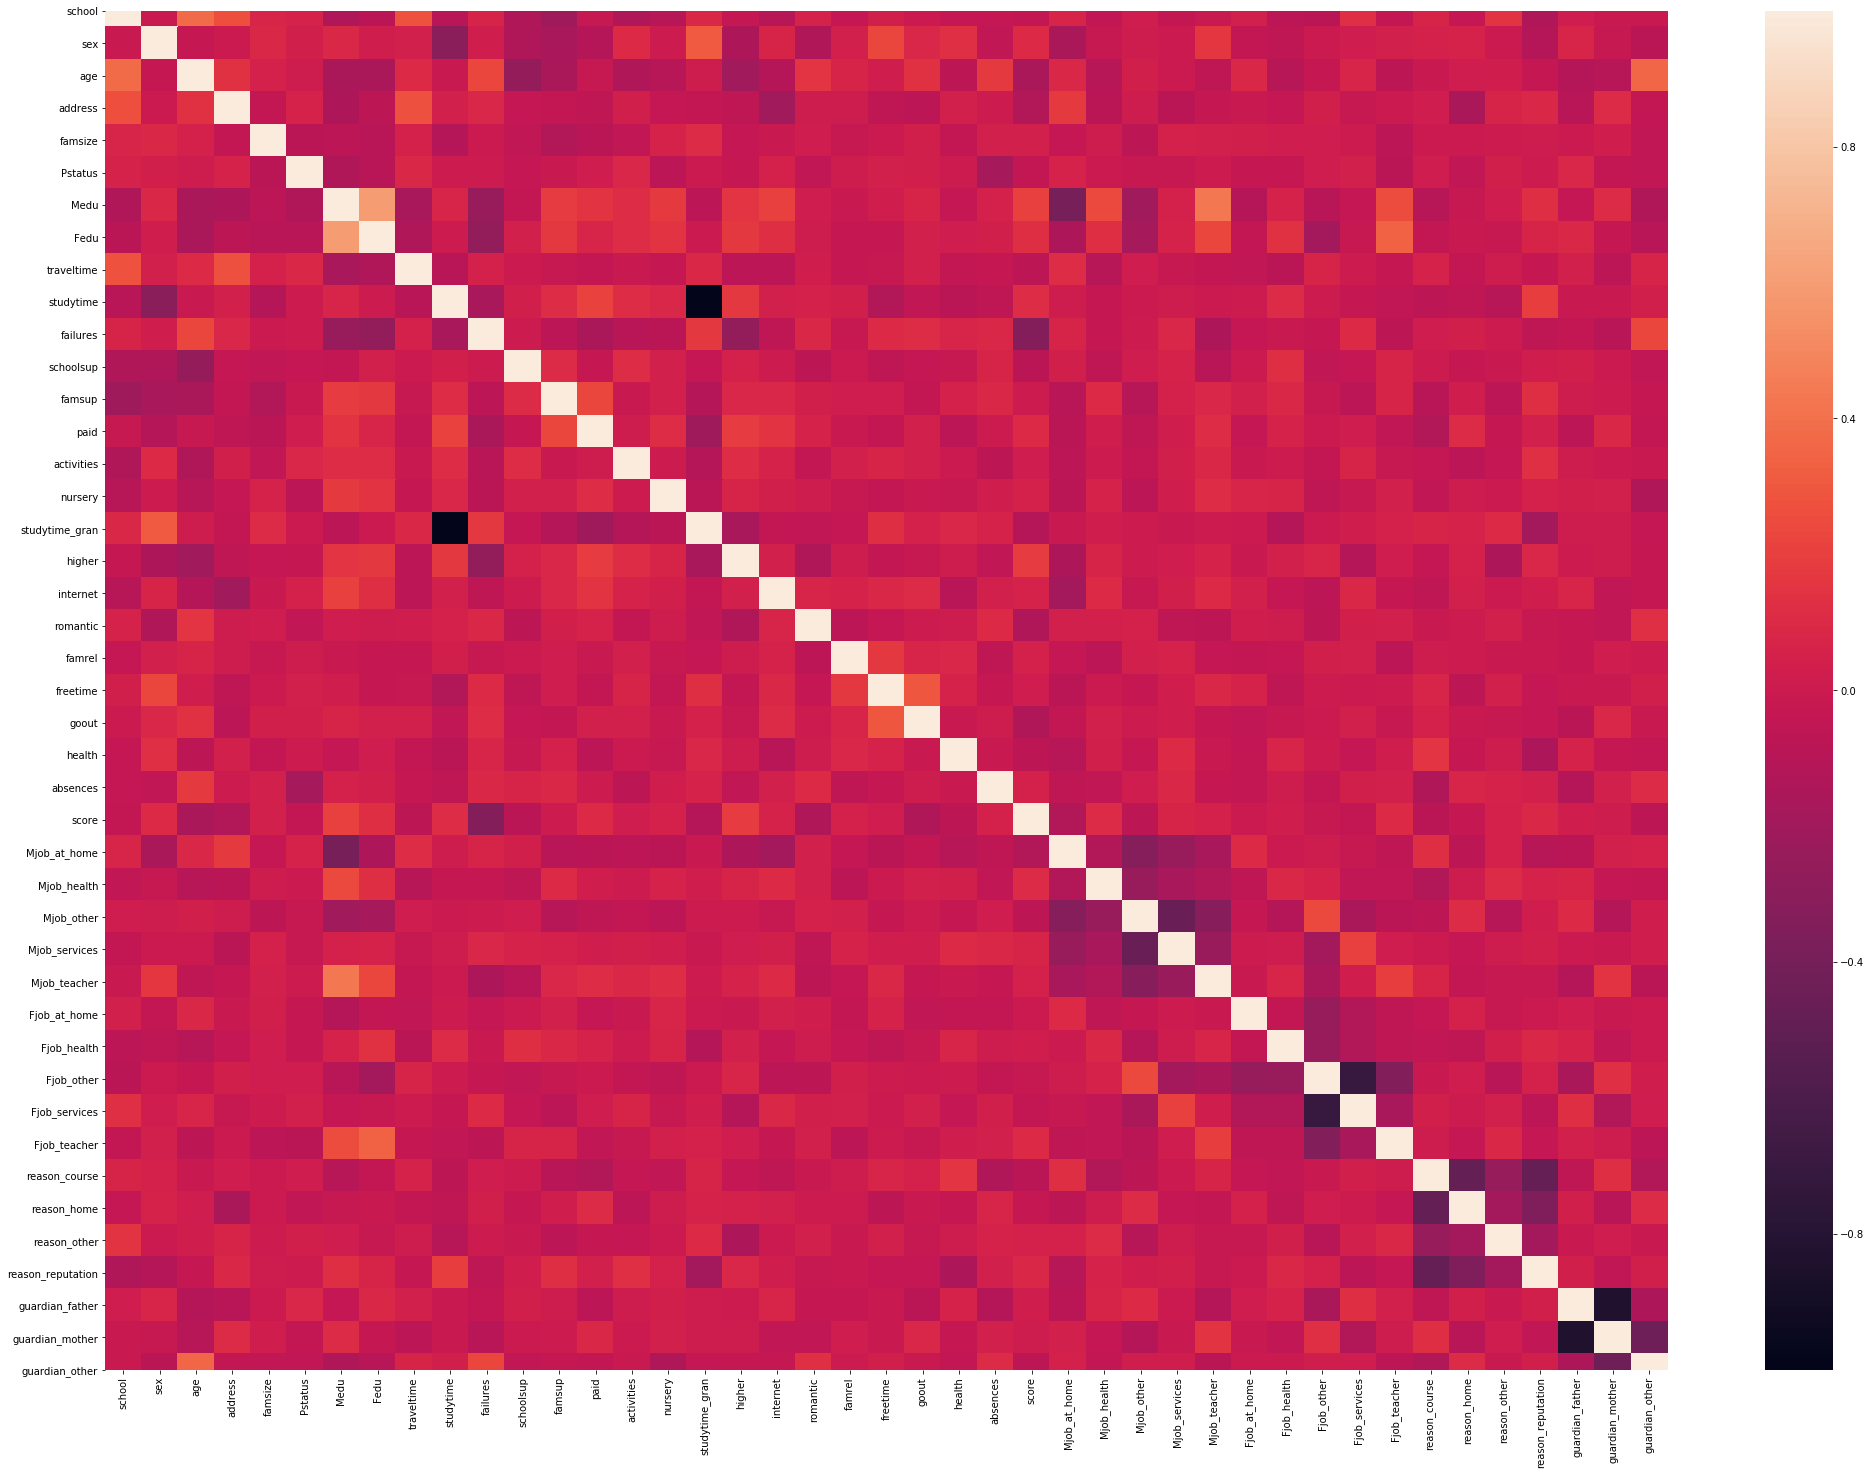

In [236]:
plt.rcParams['figure.figsize'] = (35, 25)
sns.heatmap(st_modif.corr(),);

In [237]:
st_modif[['studytime', 'studytime_gran', 'guardian_mother', 'guardian_father']].corr()

,studytime,studytime_gran,guardian_mother,guardian_father
studytime,1.000000,-1.000000,-0.011200,-0.009316
studytime_gran,-1.000000,1.000000,0.011200,0.009316
guardian_mother,-0.011200,0.011200,1.000000,-0.828268
guardian_father,-0.009316,0.009316,-0.828268,1.000000


Как и ожидалось, у колонок studytime и studytime_gran четкая отрицательная корреляция. В дальнейшем анализе колонку studytime_gran принимать во внимание не будем.

У других колонок - guardian_mother и guardian_father - хоть и наблюдается высокая корреляция, но здравый смысл подсказывает, что оставить надо их обе.

# Итоговые выводы
1. В данных достаточно мало пропусков. Все найденные пропуски заполнены подходящими значениями (см. выводы по ходу анализа каждой колонки).
2. Выбросы в единичных случаях. Все выбросы устранены путем замены значений на подходящие (см. выводы по ходу анализа колонок с выбросами).
3. Выявлена отрицательная корреляция между колонками studytime и studytime_gran. Колонка studytime_gran из дальнейшего анализа будет исключена.
4. Строковые колонки с двумя уникальными значениями преобразованы в числовые с значениями 0/1.
5. Строковые колонки с количеством уникальных значений больше двух преобразованы в dummies-колонки.
6. Все колонки за исключением studytime_gran в дальнейшем будут использованы в модели.

Переходим к построению модели.

# Обучение модели

In [238]:
col_for_X = list(set(st_modif.columns) - set({'studytime_gran', 'score'}))
X = st_modif[col_for_X]
y = st_modif.score

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predLR = lr.predict(X_test)

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)
y_predKNN = KNN.predict(X_test)

print('LR error:', np.sqrt(mean_squared_error(y_test, y_predLR)))
print('KNN error:', np.sqrt(mean_squared_error(y_test, y_predKNN)))
# LR error: 20.942372431699894
# KNN error: 28.138446152883677

LR error: 20.942372431699894
KNN error: 28.138446152883677


Сходу видно, что при дефолтных параметрах линейная регрессия дает лучше результат, чем метод ближайших соседей.

Наверняка, если "подкрутить", модель выдаст результат еще лучше.

In [241]:
lr.coef_

array([-1.42819199, -3.01782201, -5.09790932, -2.95205173, -1.09390234,
        6.82819432, -3.6237481 ,  0.49544435, -2.24061817, -2.65354432,
        2.70181192,  0.5647624 , -4.68807385, -0.50191854,  1.51826377,
        2.57207705, -2.60780026, -1.82964888,  1.7278911 ,  0.63911309,
        1.30670359,  4.41485693,  1.76594882, -1.8340412 , -6.97941801,
        0.43867781,  1.00593696,  5.44724054, -1.56263503, -1.51133068,
        2.60523302,  0.2067638 ,  2.57158124,  0.31710275, -0.32459228,
        0.28414622, -8.462399  ,  8.17036899, -6.4301624 , -1.29874628,
        2.68006518])

# Основные итоги работы

1. Выполнен анализ данных, учитывающий корреляцию колонок между собой.
2. Заполнены все пропуски.
3. Устранены выбросы.
4. Построена и обучена модель.
5. Для модели использованы все колонки за исключением study_gran. Все строковые колонки преобразованы к числовым.

# *Дополнительно:
Нет комментариев

In [240]:
# 23.05.2020 - 3 ч.
# 24.05.2020 - 1 ч.
# 25.05.2020 - 1.5 ч.
# 26.05.2020 - 2.5 ч.
# 27.05.2020 - 3 ч.